In [1]:
import os
os.chdir("/home/nickj/vl-hallucination")
os.environ["CUDA_VISIBLE_DEVICES"]="4"
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
device = "cuda"

In [3]:
from src.gpt.utils import map_hallucination_annotations_to_words
import json
from sklearn.decomposition import SparseCoder

import requests
from PIL import Image
from io import BytesIO
import numpy as np
import spacy
import pandas as pd

import matplotlib.pyplot as plt
import requests
import random
from PIL import Image
from io import BytesIO
import torch
from transformers import LlamaTokenizer
from tqdm import tqdm
from src.caption.instruct_blip_engine import InstructBLIPVicuna13B

# from experiments.embeddings import captioner, load_image, get_image_embeddings, get_vocab_embeddings

In [4]:
# Load in the weights for InstrcutBLIP

captioner = InstructBLIPVicuna13B(device="cuda", return_embeds=True)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.0.intermediate_query.dense.bias', 'bert.encoder.layer.0.intermediate_query.dense.weight', 'bert.encoder.layer.0.output_query.LayerNorm.bias', 'bert.encoder.layer.0.output_query.LayerNorm.weight', 'bert.encoder.layer.0.output_query.dense.bias', 'bert.encoder.layer.0.output_query.d

In [5]:
llm_tokenizer = LlamaTokenizer.from_pretrained(
            "/home/spetryk/large_model_checkpoints/llm/vicuna-7b-v1.1", use_fast=False, truncation_side="left"
        )
TOKEN_UNDERSCORE = chr(9601) # a lot of tokens have _rain, etc. but the underscore in front is not normal

def apply_layernorm(residual):
    residual_mean = residual.mean(dim=-1, keepdim=True)
    residual_std = (residual.var(dim=-1, keepdim=True, unbiased=False) + 0.00001).sqrt()

    residual = (residual - residual_mean) / residual_std
    return residual

def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

def get_image_embeddings(image_file, layernorm = False):
    image = load_image(image_file)
    baseline_caption, inputs_embeds, inputs_query, outputs = captioner(image, prompt=captioner.prompt, return_embeds=True)
    image_embeddings = inputs_embeds
    # print(outputs.shape)
    # image_embeddings = image_embeddings / torch.norm(image_embeddings)
    if layernorm:
        return apply_layernorm(image_embeddings)
    return image_embeddings

def get_vocab_embeddings():
    vocab = captioner.tokenizer.get_vocab()
    llm_tokens = torch.tensor(list(vocab.values()), dtype=torch.long).unsqueeze(0).to(captioner.device)
    token_embeddings = captioner.model.llm_model.get_input_embeddings()(llm_tokens)
    # token_embeddings = token_embeddings / torch.norm(token_embeddings)
    return token_embeddings

def seq_to_tokens(seq_string, id_to_token, tokenizer = llm_tokenizer, remove_first = True, remove_underscore=True):
    search_tokens = []
    for string in seq_string:
        start_ind = 1 if remove_first else 0
        for id in tokenizer(string)["input_ids"][start_ind:]:
            if id not in search_tokens:
                search_tokens.append(id_to_token[id])
                if remove_underscore and id_to_token[id][0] == TOKEN_UNDERSCORE and id_to_token[id][1:] in id_to_token.values():
                    search_tokens.append(id_to_token[id][1:])
                    
    return search_tokens

def cluster_embeddings_with_threshold(image_embeddings, threshold=0.8, verbose = False):
    # Calculate the cosine similarity matrix
    similarity_matrix = torch.mm(image_embeddings, image_embeddings.t())
    
    # Initialize clusters as a list of sets, each set will hold indices of embeddings in the same cluster
    clusters = []
    visited = set()

    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            similarity_matrix[i][j] = similarity_matrix[i][j] / torch.pow(torch.norm(image_embeddings[i, :]), 2)

    if verbose:
        print("Similarity matrix")
        print(similarity_matrix)
        
    for i in range(similarity_matrix.size(0)):
        if i not in visited:
            # Find indices where similarity exceeds the threshold
            similar_indices = torch.where(similarity_matrix[i] > threshold)[0].tolist()
            
            # Create a new cluster with indices that haven't been visited yet
            new_cluster = {idx for idx in similar_indices if idx not in visited}
            
            # Update the visited set
            visited.update(new_cluster)
            
            # Add the new cluster to the list of clusters
            clusters.append(new_cluster)

    return clusters

def lasso_decomposition(image_embedding, vocab_embeddings, vocabulary, l1_penalty = 3, device = "cuda:0"):
    """
    Runs LASSO decomposition on the provided image embedding,
    returning a stats summary as well as the decomposition sorted by decreasing weight magnitude

    image_embedding: (1, D), where D = dimension of each image embedding (ex. 5120)
    vocab_embeddings: (V, D), where V = vocab size
    vocabulary: Dict mapping vocab token to index into vocab_embeddings
    l1_penalty: higher value -> increased sparsity
    """

    # Use the vocab embeddings as the atomic representation
    A = vocab_embeddings.squeeze(0).T.to(torch.float64).to(device)

    # Invert vocabulary mapping
    id_to_token = dict()
    for key in vocabulary:
        id_to_token[vocabulary[key]] = key

    # Run sparse coder
    coder = SparseCoder(dictionary = A.T.to("cpu"), transform_algorithm="lasso_cd", transform_alpha = l1_penalty)
    weights = coder.transform(image_embedding.to("cpu"))
    weights_cuda = torch.from_numpy(weights).to(device)

    top_tokens = []
    for j in range(weights.shape[1]):
        top_tokens.append((weights[0][j], id_to_token[j])) 

    top_tokens.sort(key = lambda e: -abs(e[0]))

    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    reconstruction = A @ weights_cuda.T

    stats = {
        "cosine_similarity": float(cos(reconstruction.squeeze(1), image_embedding.squeeze(0))),
        "nonzero": np.sum(weights > 0),
        "decomposition": top_tokens,
        "reconstruction": reconstruction
    }

    return stats

def lasso_decomposition_no_cuda(image_embedding, vocab_embeddings, vocabulary, l1_penalty = 3):
    """
    Runs LASSO decomposition on the provided image embedding,
    returning a stats summary as well as the decomposition sorted by decreasing weight magnitude

    image_embedding: (1, D), where D = dimension of each image embedding (ex. 5120)
    vocab_embeddings: (V, D), where V = vocab size
    vocabulary: Dict mapping vocab token to index into vocab_embeddings
    l1_penalty: higher value -> increased sparsity
    """

    # Use the vocab embeddings as the atomic representation
    A = vocab_embeddings.squeeze(0).T.to(torch.float64)

    # Invert vocabulary mapping
    id_to_token = dict()
    for key in vocabulary:
        id_to_token[vocabulary[key]] = key

    # Run sparse coder
    coder = SparseCoder(dictionary = A.T.to("cpu"), transform_algorithm="lasso_cd", transform_alpha = l1_penalty)
    weights = coder.transform(image_embedding.to("cpu"))
    weights_cuda = torch.from_numpy(weights)

    top_tokens = []
    for j in range(weights.shape[1]):
        top_tokens.append((weights[0][j], id_to_token[j])) 

    top_tokens.sort(key = lambda e: -abs(e[0]))

    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    reconstruction = A @ weights_cuda.T

    stats = {
        "cosine_similarity": float(cos(reconstruction.squeeze(1), image_embedding.squeeze(0))),
        "nonzero": np.sum(weights > 0),
        "decomposition": top_tokens,
        "reconstruction": reconstruction
    }

    return stats

def vocab_similarity(token1, token2):
    ind1, ind2 = vocabulary[token1], vocabulary[token2]
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    return float(cos(vocab_embeddings[:, ind1], vocab_embeddings[:, ind2])[0])

def get_phrase_embedding(phrase, vocab_embeddings, tokenizer = llm_tokenizer, remove_first = True):
    # returns size (1, 5120)
    text_embeddings = []
    for token_id in tokenizer(phrase)["input_ids"]:
        text_embeddings.append(vocab_embeddings[:, token_id])
    if remove_first:
        text_embeddings = text_embeddings[1:]
    phrase_embedding = torch.sum(torch.concat(text_embeddings), dim = 0, keepdim = True)
    return phrase_embedding

# reshape so that image embeddings and text embeddings put together
def reshape_hidden_states(hidden_states):
    # converts hidden states into shape (layer #s, beam count, hidden state #s, dims)
    all_embeddings = []
    for i in range(len(hidden_states)):
        if i == 0: # only get the image embeddings
            all_embeddings.append(torch.stack(hidden_states[i])[:, :, :32])
        else:
            all_embeddings.append(torch.stack(hidden_states[i]))
    all_hidden_states = torch.concat(all_embeddings, dim = 2)
    return all_hidden_states

In [6]:
# vocab_embeddings = get_vocab_embeddings()
vocab_embeddings = torch.load("vocab_embeddings.pt")
vocabulary = torch.load("vocabulary.pt")

In [10]:
# image_file = "https://d1jyxxz9imt9yb.cloudfront.net/animal/112/meta_image/regular/WR202206_GiraffeTranslocation_012_360559_reduced.jpg"
# image_file = "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"
# image_file = "https://horsej.b-cdn.net/files/styles/article_large/public/pictures-videos/articles/dennyemerson1-dennyemersoncollection-mainweb.jpg"
image_file = "/home/nickj/vl-hallucination/experiments/dog_beach.jpeg"
# image_file = "/home/nickj/vl-hallucination/experiments/synthetic/black.jpg"

# image_file = "/home/nickj/vl-hallucination/experiments/dinosaur.jpg"

# image_file = "/home/nickj/vl-hallucination/experiments/synthetic/red_box.jpg"
# image_file = "/home/nickj/vl-hallucination/experiments/synthetic/blue.jpg"
# image_file = "/home/nickj/vl-hallucination/experiments/synthetic/blue_box.jpg"

In [11]:
# image_embeddings_black = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/black_box5.jpg")
# image_embeddings_red = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/red_box.jpg")
# image_embeddings_yellow = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/yellow_box.jpg")
# image_embeddings_purple = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/purple_box.jpg")
# image_embeddings_pink_circle = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/pink_circle.jpg")
# image_embeddings_pink = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/pink_box.jpg")

# image_embeddings_blank = get_image_embeddings("/home/nickj/vl-hallucination/experiments/synthetic/red_box.jpg")
image_embeddings = get_image_embeddings(image_file)

/home/nickj/miniconda3/envs/vl/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `-1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['The image features a cute brown and white dog sitting on a yellow surfboard in the middle of the ocean. The dog is wearing sunglasses, adding a playful touch to the scene. The surfboard appears to be floating on top of the water, giving the impression that the dog is enjoying a fun day at the beach.']


In [13]:
image_embeddings_beach = torch.load("dog_beach_embeddings.pt")
image_embeddings_dinosaur = torch.load("/home/nickj/vl-hallucination/experiments/long_experiments/dinosaur_embeddings.pt")

In [22]:
X = torch.cat([image_embeddings_dinosaur[:, :32].squeeze(), image_embeddings_beach[:, :32].squeeze(), vocab_embeddings_standard.squeeze()]).to("cpu").numpy()
y = torch.cat([torch.zeros(32), torch.zeros(32) + 1, torch.zeros(vocab_embeddings.shape[1]) + 2]).numpy()

In [61]:
vocab_embeddings_standard = apply_layernorm(vocab_embeddings)

In [16]:
stats = lasso_decomposition(image_embeddings[:, 0], captioner)

In [17]:
stats

{'cosine_similarity': 0.33286926806831446,
 'nonzero': 115,
 'decomposition': [(-1.031496368827771, '▁blah'),
  (1.0174118277163218, 'limp'),
  (0.7874549578067788, 'inos'),
  (0.5904783193764546, '▁conquer'),
  (0.5716778219422289, '▁resolution'),
  (0.5357015980064103, '▁pac'),
  (0.5292216469989693, '▁sind'),
  (-0.5135600148961955, 'cing'),
  (0.5059073739893263, '▁numeric'),
  (0.5040562476584936, '-\\'),
  (0.4878915767479441, '▁authentication'),
  (0.485484823296336, '▁au'),
  (0.4685781693492218, '▁interpretation'),
  (0.466076394099914, 'Rem'),
  (0.43589035726609576, 'OPT'),
  (-0.4259639761096109, '▁add'),
  (0.4104772606489082, '▁Dav'),
  (0.4012533844169326, 'ourg'),
  (0.38101819543169846, '▁deployment'),
  (-0.3723864769513951, '▁ts'),
  (-0.3712897182298482, 'cap'),
  (-0.358092826193937, '▁Always'),
  (0.3533068012652104, 'во'),
  (0.3523371228843651, 'zor'),
  (0.3503312138038437, '▁revis'),
  (0.34974186513271144, 'PK'),
  (0.3384448524542015, '▁divisions'),
  (0.326

In [56]:
unit_embeddings = torch.nn.functional.normalize(image_embeddings.squeeze(0), dim = 1).unsqueeze(0)

In [57]:
# See the clusters for the image embeddings

# Example usage
clusters = cluster_embeddings_with_threshold(unit_embeddings[:, :32, :].squeeze(), threshold=0.8)

# Print the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {list(cluster)}")

Cluster 1: [0, 1, 2, 3]
Cluster 2: [18, 4, 13]
Cluster 3: [5]
Cluster 4: [8, 6, 7]
Cluster 5: [9, 10, 23]
Cluster 6: [16, 11, 14, 22]
Cluster 7: [17, 12, 20]
Cluster 8: [25, 29, 15]
Cluster 9: [19, 30]
Cluster 10: [21]
Cluster 11: [24]
Cluster 12: [26, 27, 31]
Cluster 13: [28]


In [8]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
cos(image_embeddings_blue.squeeze(0), image_embeddings_purple.squeeze(0))

tensor([0.9989, 0.9983, 0.9974, 0.9989, 0.9929, 0.9986, 0.9975, 0.9968, 0.9918,
        0.9978, 0.9978, 0.9922, 0.9757, 0.8739, 0.9871, 0.9847, 0.8966, 0.9758,
        0.9916, 0.9894, 0.9921, 0.9806, 0.9502, 0.9978, 0.9653, 0.9968, 0.9845,
        0.9846, 0.9129, 0.9626, 0.9949, 0.9931, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], device='cuda:0')

In [23]:
def merge_embeddings(embed1, embed2, thres):
    # embed1: (1, 32, D) - think of this as the original
    # embed2: same size as embed1
    # thres for cosine similarity. Embeddings above thres will be embed1
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    embed1_copy = embed1.detach().clone()
    embed2_copy = embed2.detach().clone()
    for i in range(embed1.shape[1]):
        sim = cos(embed1[:, i, :], embed2[:, i, :])
        if sim[0] >= thres:
            embed2_copy[:, i, :].zero_()
        else:
            print(f"Substitute embed2 for embed1 at index {i} (sim {sim[0]})")
            embed1_copy[:, i, :].zero_()
    return embed1_copy + embed2_copy

In [36]:
cos(image_embeddings_blue[:, i, :], image_embeddings_pink[:, i, :])

tensor([0.], device='cuda:0')

In [44]:
cos(image_embeddings_pink.squeeze(0), image_embeddings_pink_circle.squeeze(0))

tensor([0.9918, 0.9853, 0.9887, 0.9920, 0.9479, 0.9904, 0.9874, 0.9748, 0.9363,
        0.9867, 0.9867, 0.8215, 0.9161, 0.9178, 0.9019, 0.8856, 0.9889, 0.9258,
        0.9103, 0.9158, 0.8271, 0.6913, 0.7249, 0.9867, 0.9094, 0.9805, 0.8686,
        0.8613, 0.9713, 0.7998, 0.9306, 0.9738, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], device='cuda:0')

In [ ]:
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# threshold = 0.75
# for i in range(image_embeddings_blue.shape[1]):
#     sim = cos(image_embeddings_blue[:, i, :], image_embeddings_pink[:, i, :])
#     if sim[0] < threshold:
#         print(f"Substitute black embed with red at index {i} (sim {sim[0]})")
#         image_embeddings_blue[:, i, :].zero_()
#     else:
#         image_embeddings_pink[:, i, :].zero_()

image_embeddings = merge_embeddings(image_embeddings_blue, image_embeddings_purple, 1)

In [17]:
# Produce token ids from prompt
llm_tokens = captioner.model.llm_tokenizer(
            captioner.prompt, return_tensors="pt"
        ).to("cuda")
print(llm_tokens)


{'input_ids': tensor([[    2, 14350,   263, 13173,  6139, 29889]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}


In [85]:
# Get input embeddings and attention mask
inputs_embeds = captioner.model.llm_model.get_input_embeddings()(llm_tokens.input_ids)
attention_mask = llm_tokens.attention_mask

In [75]:
# Send to text model
outputs = captioner.model.llm_model.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                num_beams=10,
                max_length=200,
                # eos_token_id=self.eos_token_id,
                output_scores=True,
                output_attentions=True,
            )

In [76]:
tokens = outputs

tokens[tokens == 0] = 2  # convert output id 0 to 2 (eos_token_id)
output_text = captioner.model.llm_tokenizer.batch_decode(tokens, skip_special_tokens=True)
print(output_text)

['<s> What do you see? What do you feel? What do you hear? What do you smell? What do you think? What do you wonder? What do you remember? What do you imagine? What do you like? What do you dislike? What do you admire? What do you criticize? What do you want? What do you need? What do you fear? What do you hope? What do you dream? What do you remember? What do you imagine? What do you like? What do you dislike? What do you admire? What do you criticize? What do you want? What do you need? What do you fear? What do you hope? What do you dream? What do you remember? What do you imagine? What do you like? What do you dislike? What do you admire? What do you criticize? What do you want? What do you need? What do you fear? What do you hope']


In [36]:
# Create dummy input for vision-language model
test_input = {"image": torch.ones(1).to("cuda"), "prompt": captioner.prompt}

In [9]:
# Use real image embeddings
image_embeddings = get_image_embeddings("/home/nickj/vl-hallucination/experiments/dog_beach.jpeg")

/home/nickj/miniconda3/envs/vl/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `-1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['A dog wearing sunglasses is sitting on a surfboard in the ocean.']
Image embeddings shape: torch.Size([1, 38, 5120])


In [37]:
# Get a random permutation
# rand_perm = torch.randperm(32)
# inputs_embeds = image_embeddings[:,rand_perm, :]

# indices_left_out = [9, 10, 17, 14, 18, 20, 23, 28]
# indices_left_out = []
# inds = [i for i in range(32) if i not in indices_left_out]

# inputs_embeds = image_embeddings[:, inds, :]
# inputs_embeds = image_embeddings
# pad_to = 32
# inputs_embeds = torch.cat([torch.zeros((1, pad_to - inputs_embeds.shape[1], inputs_embeds.shape[2])).to(inputs_embeds.device), inputs_embeds], dim = 1)
# inputs_embeds = image_embeddings_black

# inputs_embeds = merge_embeddings(image_embeddings_pink, image_embeddings_pink_circle, 0.92) # anything in blue with a similarity score less than thres will get replaced

inputs_embeds = image_embeddings[:, :32].clone()
# for i in range(11, 12):
#     if i in embedding_indices and i < inputs_embeds.shape[1]:
#         print(i)
#         inputs_embeds[:, i] = -2 * vocab_embeddings[:, vocabulary[TOKEN_UNDERSCORE + "brown"]]
#         # inputs_embeds[:, i] = torch.zeros((1, 5120))

atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)

In [ ]:
# Create "vision" embeddings

# inputs_embeds = captioner.model.llm_model.get_input_embeddings()(llm_tokens.input_ids)
# inputs_embeds = reconstruct_embeddings

inputs_embeds = apply_layernorm(image_embeddings[:, :32, :] - 20 * vocab_embeddings[:, vocabulary["dog"], :])

cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
print(cos(inputs_embeds, image_embeddings[:, :32, :]))

atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)

In [ ]:
# Create linear combinations of input embeddings
combo = ["a", "small", "alligator", "wearing", "sunglasses", "on", "a", "surfboard", "beautiful day", "a", "small", "alligator", "wearing", "sunglasses", "on", "a", "surfboard", "beautiful day", "a", "small", "alligator", "wearing", "sunglasses", "on", "a", "surfboard", "beautiful day", "a", "small", "alligator", "wearing", "sunglasses", "on", "a", "surfboard"]
combo_embedding = None
inputs_embeds = None
num_tokens = 0
for item in combo:
    llm_tokens = captioner.model.llm_tokenizer(item, return_tensors="pt").to(device)        
    inputs_embeds_item = captioner.model.llm_model.get_input_embeddings()(llm_tokens.input_ids[:, 1:])
    print(llm_tokens.input_ids)
    sum_inputs_embeds = torch.sum(inputs_embeds_item, 1, keepdim=True)
    if inputs_embeds == None:
        inputs_embeds = sum_inputs_embeds
    else:
        inputs_embeds = torch.cat([inputs_embeds, sum_inputs_embeds], dim=1)
    # num_tokens += inputs_embeds_item.shape[1]
    # combo_embedding = combo_embedding + sum_inputs_embeds if combo_embedding != None else sum_inputs_embeds

# inputs_embeds = combo_embedding / num_tokens

# # Pad the input embeddings up to 32 dimensions
# pad_to = 32
# if inputs_embeds.shape[1] < pad_to:
#     inputs_embeds = torch.cat([torch.zeros((1, pad_to - inputs_embeds.shape[1], inputs_embeds.shape[2])).to(inputs_embeds.device), inputs_embeds], dim = 1)

atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)
print(inputs_embeds)

In [38]:
out = captioner.model.generate(  # type: ignore
            test_input,
            num_beams=5,
            max_length=200,
            return_embeds=True,
            atts_vision=atts_llm,
            inputs_vision=inputs_embeds, # stick input embeddings from vision here
            return_dict=True
            # pure_llm = True # meaning only text model used
        )
print(out[0])

['<s> The image features a cute brown and white dog sitting on a yellow surfboard in the middle of the ocean. The dog is wearing sunglasses and appears to be enjoying its time on the water. There are several other dogs visible in the scene, some closer to the dog on the surfboard, while others are further away. The overall atmosphere is relaxed and fun, with the dogs enjoying their time in the sun and water.']


In [39]:
torch.save(out[4].sequences, "blue_box_sequences.pt")

In [37]:
llm_tokenizer('There is a blue square in the center of the image, surrounded by a white background. The square takes up most of the space in the image and stands out due to its vibrant blue color. There are two people in the image, one on the left side and the other on the right side of the square. They appear to be standing in front of the blue square, possibly admiring it or interacting with it in some way.')

{'input_ids': [1, 1670, 338, 263, 7254, 6862, 297, 278, 4818, 310, 278, 1967, 29892, 22047, 491, 263, 4796, 3239, 29889, 450, 6862, 4893, 701, 1556, 310, 278, 2913, 297, 278, 1967, 322, 15028, 714, 2861, 304, 967, 325, 4626, 424, 7254, 2927, 29889, 1670, 526, 1023, 2305, 297, 278, 1967, 29892, 697, 373, 278, 2175, 2625, 322, 278, 916, 373, 278, 1492, 2625, 310, 278, 6862, 29889, 2688, 2615, 304, 367, 13407, 297, 4565, 310, 278, 7254, 6862, 29892, 10075, 7336, 8491, 372, 470, 16254, 292, 411, 372, 297, 777, 982, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
out[4].attentions[0][0].shape

torch.Size([5, 40, 38, 38])

In [26]:
help(out[4])

Help on GenerateBeamDecoderOnlyOutput in module transformers.generation.utils object:

class GenerateBeamDecoderOnlyOutput(transformers.utils.generic.ModelOutput)
 |  GenerateBeamDecoderOnlyOutput(sequences: torch.LongTensor = None, sequences_scores: Optional[torch.FloatTensor] = None, scores: Optional[Tuple[torch.FloatTensor]] = None, beam_indices: Optional[torch.LongTensor] = None, attentions: Optional[Tuple[Tuple[torch.FloatTensor]]] = None, hidden_states: Optional[Tuple[Tuple[torch.FloatTensor]]] = None, past_key_values: Optional[Tuple[Tuple[Tuple[torch.FloatTensor]]]] = None) -> None
 |  
 |  Outputs of decoder-only generation models, when using beam methods.
 |  
 |  Args:
 |      sequences (`torch.LongTensor` of shape `(batch_size*num_return_sequences, sequence_length)`):
 |          The generated sequences. The second dimension (sequence_length) is either equal to `max_length` or shorter
 |          if all batches finished early due to the `eos_token_id`.
 |      sequences_scor

In [31]:
vocabulary = captioner.tokenizer.get_vocab()

In [40]:
torch.save(out[4].hidden_states, "blue_box_hidden_states.pt")

In [32]:
out[4].hidden_states[3][32].shape

torch.Size([5, 1, 4096])

In [70]:
third_set = out[4].hidden_states[0]

In [46]:
second_set = out[4].hidden_states[0]

In [ ]:
for i in range(len(second_set)):
    print(torch.dist(third_set[i][:,:32], first_set[i][:,:32]))
    print(torch.dist(third_set[i][:,:32], second_set[i][:,:32]))

In [39]:
first_set = out[4].hidden_states[0]

In [63]:
first_set[30][:, :32]

tensor([[[ 0.0261, -4.7387, -0.4769,  ...,  0.5123,  4.9504, -1.2429],
         [-0.2942, -5.3353,  0.8573,  ...,  2.3148,  4.7112, -0.6109],
         [ 0.3080, -5.0993, -0.7815,  ...,  0.5919,  6.3356, -1.0318],
         ...,
         [-0.0497, -1.9499,  1.6164,  ...,  0.0677,  1.8759, -2.3117],
         [-0.1738, -0.0549,  1.0104,  ..., -0.8763, -1.6484,  1.7827],
         [ 2.6816, -1.2877,  0.3303,  ..., -1.6244,  0.4079,  1.3934]],

        [[ 0.0261, -4.7387, -0.4769,  ...,  0.5123,  4.9504, -1.2429],
         [-0.2942, -5.3353,  0.8573,  ...,  2.3148,  4.7112, -0.6109],
         [ 0.3080, -5.0993, -0.7815,  ...,  0.5919,  6.3356, -1.0318],
         ...,
         [-0.0497, -1.9499,  1.6164,  ...,  0.0677,  1.8759, -2.3117],
         [-0.1738, -0.0549,  1.0104,  ..., -0.8763, -1.6484,  1.7827],
         [ 2.6816, -1.2877,  0.3303,  ..., -1.6244,  0.4079,  1.3934]],

        [[ 0.0261, -4.7387, -0.4769,  ...,  0.5123,  4.9504, -1.2429],
         [-0.2942, -5.3353,  0.8573,  ...,  2

In [65]:
second_set[30][:, :32]

tensor([[[ 0.0261, -4.7387, -0.4769,  ...,  0.5123,  4.9504, -1.2429],
         [-0.2942, -5.3353,  0.8573,  ...,  2.3148,  4.7112, -0.6109],
         [ 0.3080, -5.0993, -0.7815,  ...,  0.5919,  6.3356, -1.0318],
         ...,
         [-0.0463, -1.9490,  1.6192,  ...,  0.0689,  1.8763, -2.3112],
         [-0.1727, -0.0541,  1.0110,  ..., -0.8768, -1.6467,  1.7817],
         [ 2.6796, -1.2916,  0.3320,  ..., -1.6285,  0.4051,  1.3877]],

        [[ 0.0261, -4.7387, -0.4769,  ...,  0.5123,  4.9504, -1.2429],
         [-0.2942, -5.3353,  0.8573,  ...,  2.3148,  4.7112, -0.6109],
         [ 0.3080, -5.0993, -0.7815,  ...,  0.5919,  6.3356, -1.0318],
         ...,
         [-0.0463, -1.9490,  1.6192,  ...,  0.0689,  1.8763, -2.3112],
         [-0.1727, -0.0541,  1.0110,  ..., -0.8768, -1.6467,  1.7817],
         [ 2.6796, -1.2916,  0.3320,  ..., -1.6285,  0.4051,  1.3877]],

        [[ 0.0261, -4.7387, -0.4769,  ...,  0.5123,  4.9504, -1.2429],
         [-0.2942, -5.3353,  0.8573,  ...,  2

### Extract limited vocabulary

In [ ]:
vocabulary

In [550]:
import spacy

In [551]:
nlp = spacy.load("en_core_web_sm")

In [85]:
nouns = []
with open("/home/nickj/vl-hallucination/experiments/nounlist.txt", "r") as f:
    for line in f:
        nouns.append(line.strip())

In [97]:
words = []
for word in vocabulary:
    doc = nlp(word)
    
    for token in doc:
        if token.pos_ == "VERB":
            words.append(word)
            print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
                token.shape_, token.is_alpha, token.is_stop)
            break


th th VERB VB punct xx True False
re re VERB VBN ROOT xx True True
ar ar VERB VB ROOT xx True False
m m VERB VBP appos x True False
et et VERB VB ROOT xx True False
ro ro VERB VBD ROOT xx True False
m m VERB VBP appos x True False
ot ot VERB VB ROOT xx True False
ur ur VERB VB ROOT xx True False
re re VERB VBD ROOT xx True True
ve ve VERB VBP ROOT xx True False
ce ce VERB VBD ROOT xx True False
ment ment VERB VB ROOT xxxx True False
ly ly VERB VB ROOT xx True False
wh wh VERB VBP ROOT xx True False
st st VERB VBD ROOT xx True False
ir ir VERB VB ROOT xx True False
th th VERB VB ROOT xx True False
ay ay VERB VB ROOT xx True False
al al VERB VB ROOT xx True False
ate eat VERB VBD ROOT xxx True False
ere ere VERB VB ROOT xxx True False
ame ame VERB VBD ROOT xxx True False
Com com VERB VB ROOT Xxx True False
do do VERB VBP ROOT xx True True
ort ort VERB VB ROOT xxx True False
ke ke VERB VB ROOT xx True False
egin egin VERB VB ROOT xxxx True False
Comment comment VERB VB ROOT Xxxxx True Fal

### Try random permutations

In [27]:
tags = []
for i in range(100):
    rand_perm = torch.cat([torch.flip(torch.arange(32),[0])])
    # rand_perm = torch.randperm(32)
    print(rand_perm)
    inputs_embeds = image_embeddings[:,rand_perm, :]
    atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)
    out = captioner.model.generate(  # type: ignore
            test_input,
            num_beams=5,
            max_length=200,
            return_embeds=True,
            atts_vision=atts_llm,
            inputs_vision=inputs_embeds, # stick input embeddings from vision here
            # pure_llm = True # meaning only text model used
        )
    print(f"Run {i}: {out[0]}")
    tags.append((rand_perm, out[0]))

tensor([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
        13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])
Run 0: ['<s> \n\nIn this section, we’ll delve into the intricacies of writing a detailed description. To begin, it’s important to understand that a detailed description is one that provides enough information for the reader to form a clear picture of what is being described. This means that when writing a detailed description, you should focus on providing specific, concrete information about the subject at hand.\n\nFor example, if you were writing a detailed description of a person, you might include information about their physical appearance, such as their height, weight, and body shape. You might also include information about their personal characteristics, such as their sense of humor, or their interests and hobbies.\n\nIn addition to providing specific information, it’s also important to use descriptive language when writing a detailed 

KeyboardInterrupt: 

In [26]:
tags

[(tensor([ 3, 22, 31, 21,  6, 14, 23, 15, 24, 17, 30, 28, 25,  9,  1,  0, 13,  5,
          11, 10,  4,  8, 18, 27, 26,  7, 20,  2, 16, 12, 19, 29]),
  ['<s>']),
 (tensor([19,  7,  2, 17, 27,  4, 11, 20,  9,  5, 26,  3,  0, 30, 18, 29, 13, 24,
          22, 12, 28, 31, 10, 23, 16,  1, 15, 25,  8, 14, 21,  6]),
  ['<s> A dog is sitting on a surfboard in the middle of the ocean. The dog is wearing sunglasses to protect its eyes from the sun.']),
 (tensor([ 1, 10, 17, 12, 26, 28, 31, 11, 21, 30, 23, 22, 24,  5,  2,  9, 13, 18,
           6,  8, 29, 27,  3, 16,  4, 19,  7,  0, 15, 20, 14, 25]),
  ['<s>']),
 (tensor([14,  5, 18, 13, 24, 28, 25, 29, 15, 31, 19,  6, 20, 16, 10,  4,  3, 23,
           1, 12, 22, 11, 17, 26,  7,  2,  0, 30, 27,  8,  9, 21]),
  ['<s>']),
 (tensor([ 2, 30,  9, 19, 17, 27, 25, 24, 12, 26,  1, 14,  4,  3, 16,  8, 11, 15,
          21,  7, 18, 29,  0, 13, 31,  6, 22, 28, 20, 10, 23,  5]),
  ['<s> the dog is wearing sunglasses and sitting on a yellow surfboard in the

### PCA

In [63]:
X.shape

(32065, 5120)

In [65]:
# combine image embeddings with text embeddings

X = apply_layernorm(torch.cat([image_embeddings_dinosaur[:, :32].squeeze(), image_embeddings_beach[:, :32].squeeze(), vocab_embeddings.squeeze()]))
X = X.to("cpu").numpy()
y = torch.cat([torch.zeros(32), torch.zeros(32) + 1, torch.zeros(vocab_embeddings.shape[1]) + 2]).numpy()

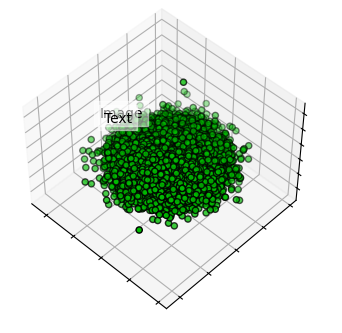

In [77]:
# Code source: Gaël Varoquaux
# License: BSD 3 clause

import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn import datasets, decomposition

np.random.seed(5)

fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
# pca = decomposition.PCA(n_components=2)

# X_r = pca.fit(X).transform(X)

# plt.figure()
# colors = ["navy", "darkorange"]
# target_names = ["Image", "Text"]
# lw = 2

# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(
#         X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
#     )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.title("PCA of IRIS dataset")
# plt.show()

pca = decomposition.PCA(n_components=3)
X_3d = pca.fit(X).transform(X)

for name, label in [("Image", 0), ("Text", 1)]:
    ax.text3D(
        X_3d[y == label, 0].mean(),
        X_3d[y == label, 1].mean() + 1.5,
        X_3d[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y_reordered = np.choose(y.astype(np.int64), [0, 2, 1]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_reordered, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

In [75]:
img_mean = np.mean(X[:64], axis = 0)
text_mean = np.mean(X[64:], axis = 0)

In [76]:
np.dot(img_mean, text_mean) / (np.linalg.norm(img_mean) * np.linalg.norm(text_mean))

0.09718855

### Decomposing image embeddings

In [ ]:
vocab_embeddings = torch.load("vocab_embeddings.pt")

In [82]:
woi = ["There is a blue square in the center of the image, surrounded by a white background. The square takes up most of the space in the image and stands out due to its vibrant blue color. There are two people in the image, one on the left side and the other on the right side of the square. They appear to be standing in front of the blue square, possibly admiring it or interacting with it in some way."]
input_ids = []
for word in woi:
    for id in captioner.tokenizer(word)["input_ids"]:
        if id not in input_ids:
            input_ids.append(id)


print(input_ids)



[2, 1670, 338, 263, 7254, 6862, 297, 278, 4818, 310, 1967, 29892, 22047, 491, 4796, 3239, 29889, 450, 4893, 701, 1556, 2913, 322, 15028, 714, 2861, 304, 967, 325, 4626, 424, 2927, 526, 1023, 2305, 697, 373, 2175, 2625, 916, 1492, 2688, 2615, 367, 13407, 4565, 10075, 7336, 8491, 372, 470, 16254, 292, 411, 777, 982]


In [91]:
len(input_ids)

58

In [39]:
# # Select specific vocab tokens
# A = torch.index_select(vocab_embeddings.squeeze(0), 0, torch.tensor(input_ids).to(device))
# A = A.T.to(torch.float64).to(device)

# Use entire vocabulary
A = vocab_embeddings.squeeze(0).T.to(torch.float64).to(device)

# Invert vocabulary mapping
id_to_token = dict()
# vocabulary = captioner.tokenizer.get_vocab()
# vocabulary = torch.load("vocabulary.pt")
for key in vocabulary:
    id_to_token[vocabulary[key]] = key


In [16]:
A.shape

torch.Size([5120, 32005])

In [41]:
vocab_embeddings = torch.load("vocab_embeddings.pt")
vocabulary = torch.load("vocabulary.pt")

phrases = ["brown horse", "man on horse", "green field", "man wearing helmet", "horse", "helmet", "riding"]
for phrase in phrases:
    phrase_embedding = get_phrase_embedding(phrase, vocab_embeddings)
    vocab_embeddings = torch.concat([vocab_embeddings, phrase_embedding.unsqueeze(0)], dim = 1)
    vocabulary[phrase] = vocab_embeddings.shape[1] - 1
    
    # input_ids.append(vocab_embeddings.shape[1] - 1) # append the last id

#### SparseCoder

In [195]:
coder = SparseCoder(dictionary = A.T.to("cpu"), transform_algorithm="lasso_lars")

In [196]:
A.T.shape

torch.Size([32001, 5120])

In [197]:
image_embeddings[:, 2, :].T.to("cpu").shape

torch.Size([5120, 1])

In [ ]:
weights = coder.transform(image_embeddings[:, 4, :].to("cpu"))

In [ ]:
print(f"Nonzero weights: {np.sum(weights > 0)}")

In [ ]:
weights.shape

In [ ]:
weights_cuda = torch.from_numpy(weights).to(device)

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
reconstruction = A @ weights_cuda.T

In [ ]:
cos(reconstruction.squeeze(1), image_embeddings[:, 0].squeeze(0))

In [ ]:
torch.dist(reconstruction.squeeze(1), image_embeddings[:, 0].squeeze(0))

In [ ]:
top_tokens = []
for j in range(weights.shape[1]):
    # top_tokens.append((weights[0][j], id_to_token[input_ids[j]])) # using subset of vocabulary
    top_tokens.append((weights[0][j], id_to_token[j])) # using entire vocabulary
top_tokens.sort(key = lambda e: -abs(e[0]))

In [ ]:
top_tokens

In [93]:
leave_out = [vocabulary["dog"], vocabulary[TOKEN_UNDERSCORE + "Dog"], vocabulary[TOKEN_UNDERSCORE + "dog"], vocabulary["ogs"]]
for i in leave_out:
    A[:, i].zero_()

In [98]:
y = torch.square(vocab_embeddings[:, vocabulary["dog"]]).T.to(torch.float64).to(device)

In [119]:
y = torch.pow(image_embeddings[:, 16], 4).T.to(torch.float64).to(device)

In [120]:
X = torch.linalg.lstsq(A, y).solution

In [121]:
top_tokens = []
for j in range(X.shape[0]):
    # top_tokens.append((X[j][0].to("cpu"), id_to_token[input_ids[j]])) # using subset of vocabulary
    top_tokens.append((X[j][0].to("cpu"), id_to_token[j])) # using entire vocabulary
top_tokens.sort(key = lambda e: -torch.abs(e[0]))

In [ ]:
top_tokens

In [135]:
torch.cat([image_embeddings[:, 5:6, :], image_embeddings[:, 8:32, :]], dim = 1)

torch.Size([1, 25, 5120])

In [39]:
blue_box_hidden_states = torch.load("/home/nickj/vl-hallucination/hidden_states_data/blue_box_hidden_states.pt")

In [93]:
img_embedding = blue_box_hidden_states[0][40]

In [94]:
img_embedding.shape

torch.Size([5, 38, 5120])

In [7]:
import multiprocessing

# Use 'multiprocessing.cpu_count()' to determine the number of available CPU cores.
cpu_count = multiprocessing.cpu_count()

In [96]:
cpu_count

64

In [101]:
stats = lasso_decomposition(img_embedding[0, 15].unsqueeze(0), vocab_embeddings.squeeze(0), vocabulary, l1_penalty = 1)

In [ ]:
stats["decomposition"]

In [103]:
stats["nonzero"]

1132

In [104]:
stats["cosine_similarity"]

0.8494476114423702

In [ ]:
# # Decompose using SparseCoder (lasso / omp)

# # Search tokens - extract rank + weight
# search_space = ["A cat and dog are peeking over the edge of a white board."]
# search_token_space = seq_to_tokens(search_space, id_to_token)
# print(f"Search tokens: {search_token_space}")

# decompositions = []

# coder = SparseCoder(dictionary = A.T.to("cpu"), transform_algorithm="lasso_cd", transform_alpha = 3)
# image_embeddings_sparse = image_embeddings
# for i in range(32):
#     weights = coder.transform(image_embeddings_sparse[:, i].to("cpu"))
#     weights_cuda = torch.from_numpy(weights).to(device)

#     top_tokens = []
#     for j in range(weights.shape[1]):
#         # top_tokens.append((weights[0][j], id_to_token[input_ids[j]])) # using subset of vocabulary
#         top_tokens.append((weights[0][j], id_to_token[j])) # using entire vocabulary

#     top_tokens.sort(key = lambda e: -abs(e[0]))

#     # Search for interesting tokens
#     for ind in range(len(top_tokens)):
#         if ind < 100: # we define (arbitrarily) that interesting tokens occur above rank 100
#             for tok in search_token_space:
#                 if top_tokens[ind][1] == tok:
#                     print(f"Token {tok} has rank {ind} with weight {top_tokens[ind][0]}")
    
#     decompositions.append(top_tokens)

#     cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
#     reconstruction = A @ weights_cuda.T
    
#     print(f"Reconstruction cosine similarity {i} ({np.sum(weights > 0)} nonzero): {cos(reconstruction.squeeze(1), image_embeddings_sparse[:, 0].squeeze(0))}")
#     print(top_tokens[:10])


In [ ]:
# Use the SparseCoder to decompose the image embedddings (LASSO)

# Search tokens - extract rank + weight
search_space = ["dog", "beach", "sunglasses", "surfboard"]
search_token_space = set(seq_to_tokens(search_space, id_to_token))
print(f"Search tokens: {search_token_space}")


image_embeddings_lasso = reshape_hidden_states(out[4].hidden_states)[40, 0, :32].unsqueeze(0)
decompositions = []

for i in range(32):
    stats = lasso_decomposition(image_embeddings_lasso[:, i], vocab_embeddings, vocabulary, l1_penalty = 3)
    top_tokens = stats["decomposition"]
    cos_similarity = stats["cosine_similarity"]
    nonzero_count = stats["nonzero"]
    decompositions.append(top_tokens)

    print(f"Reconstruction cosine similarity {i} ({nonzero_count} nonzero): {cos_similarity}")
    print(top_tokens[:25])
    # Search for interesting tokens
    interesting_token_strs = []
    for tok in search_token_space:
        vocab_pairs = []
        for ind in range(min(100, len(top_tokens))): # we only care about tokens with rank < 100
            vocab_pairs.append((vocab_similarity(tok, top_tokens[ind][1]), ind))
        vocab_pairs.sort()
        best_sim, best_ind = vocab_pairs[-1]
        if best_sim < 0.1: # we only care about tokens that bear some resemblance
            continue
        interesting_token_strs.append((best_ind, f"Caption token {top_tokens[best_ind][1]}(nearest {tok}, cos {vocab_similarity(tok, top_tokens[best_ind][1])}) has rank {vocab_pairs[-1][1]}"))
    interesting_token_strs.sort()
    for rank, string in interesting_token_strs:
        print(string)

    print("\n")

Search tokens: {'▁sur', 'ung', 'lass', 's', '▁dog', 'dog', '▁s', '▁beach', 'es', 'sur', 'board', 'f'}
Reconstruction cosine similarity 0 (162 nonzero): 0.4150454090939174
[(1.3156247562624794, '▁in'), (-1.2786079325105506, 'Holder'), (-1.270073318961701, '▁Tan'), (-1.0731191022297413, '▁guest'), (1.0401887949990525, '<s>'), (1.0234326664346487, '▁hockey'), (-0.9571695034495721, '▁internacional'), (-0.9246975965392694, 'ifest'), (-0.9164277772425561, 'halb'), (-0.8794974787367829, 'itel'), (-0.8284179425202413, 'reference'), (0.8231859330508694, '▁erstmals'), (0.8166994419954469, '▁checkbox'), (0.742501537484787, 'LAB'), (-0.7134951834282065, '▁add'), (-0.7119424250572008, 'ální'), (0.7082157776503805, '▁depending'), (-0.7060249150370876, '=""'), (-0.6971493431557488, 'зен'), (-0.681262466860146, '▁challenge'), (-0.6660203761517286, '▁Phot'), (0.6582029198436395, '置'), (-0.6088925722293821, '▁asympt'), (-0.595876819495685, '▁Urs'), (0.5860267750603096, 'ente')]
Caption token ▁island(nea

In [45]:
image_embeddings_ls.shape

torch.Size([1, 32, 5120])

In [38]:
vocab_similarity(TOKEN_UNDERSCORE + "is", TOKEN_UNDERSCORE + "sind")

0.053741455078125

In [34]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

In [35]:
cos(vocab_embeddings[:, ind1], vocab_embeddings[:, ind2])

tensor([0.0174], device='cuda:0', dtype=torch.float16)

#### Run decompositions

In [42]:
reshape_hidden_states(out[4].hidden_states)[40, 0, :32].unsqueeze(0).shape

torch.Size([1, 32, 5120])

In [43]:
# Solve least squares with ridge regression

decompositions = []

# image_embeddings_ls = apply_layernorm(image_embeddings - image_embeddings_blank)
image_embeddings_ls = reshape_hidden_states(out[4].hidden_states)[40, 0, :32].unsqueeze(0)
# image_embeddings_ls = image_embeddings[:, :32]

for i in range(image_embeddings_ls.shape[1]):
    y = image_embeddings_ls[:, i].T.to(torch.float64).to(device)
    X = torch.linalg.lstsq(A, y).solution
    # X = my_nnls(A, y, max_iter = 100)
    
    top_tokens = []
    for j in range(X.shape[0]):
        # top_tokens.append((X[j][0].to("cpu"), id_to_token[input_ids[j]])) # using subset of vocabulary
        top_tokens.append((X[j][0].to("cpu"), id_to_token[j])) # using entire vocabulary
    top_tokens.sort(key = lambda e: -torch.abs(e[0]))

    decompositions.append(top_tokens)

    # calculate cosine similarity
    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    reconstruction = A @ X
    print(f"Embedding {i} (error: {torch.dist(reconstruction, y)}, cos error: {cos(reconstruction.squeeze(1), y.squeeze(1))}): {top_tokens[:10]}")

Embedding 0 (error: 1.905742531240935e-13, cos error: 1.0000000000000004): [(tensor(-1.2381, dtype=torch.float64), '▁sizes'), (tensor(-1.2098, dtype=torch.float64), '▁rac'), (tensor(1.1818, dtype=torch.float64), '▁ball'), (tensor(1.1561, dtype=torch.float64), 'Smith'), (tensor(-1.0990, dtype=torch.float64), '▁Date'), (tensor(-1.0973, dtype=torch.float64), '▁Face'), (tensor(-1.0935, dtype=torch.float64), '▁Patrick'), (tensor(-1.0930, dtype=torch.float64), '▁Control'), (tensor(1.0843, dtype=torch.float64), '<s>'), (tensor(1.0585, dtype=torch.float64), '▁step')]
Embedding 1 (error: 1.8241164722416455e-13, cos error: 0.9999999999999997): [(tensor(-1.2481, dtype=torch.float64), '▁sizes'), (tensor(-1.2193, dtype=torch.float64), '▁rac'), (tensor(1.1796, dtype=torch.float64), '▁ball'), (tensor(1.1439, dtype=torch.float64), 'Smith'), (tensor(-1.1160, dtype=torch.float64), '▁Date'), (tensor(-1.1104, dtype=torch.float64), '▁Control'), (tensor(-1.1092, dtype=torch.float64), '▁Face'), (tensor(-1.08

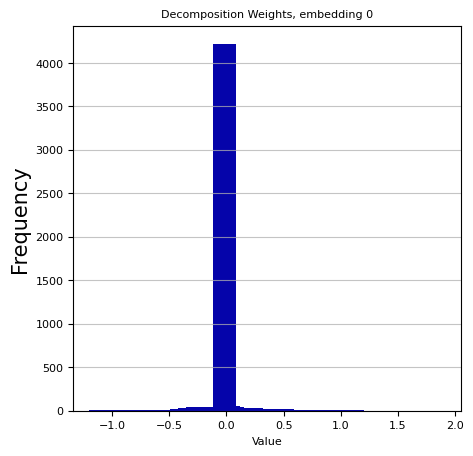

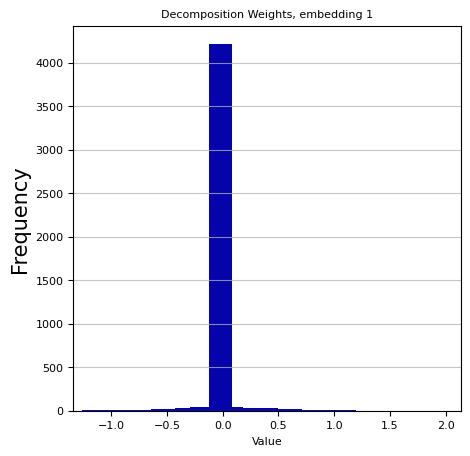

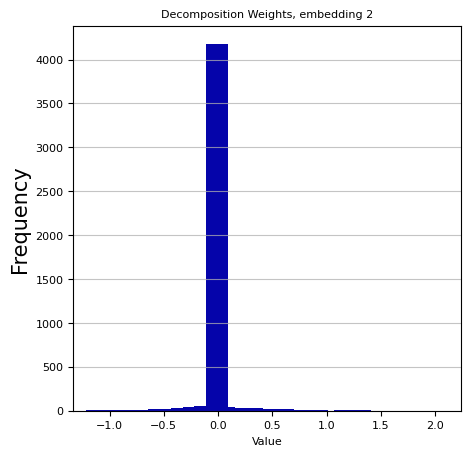

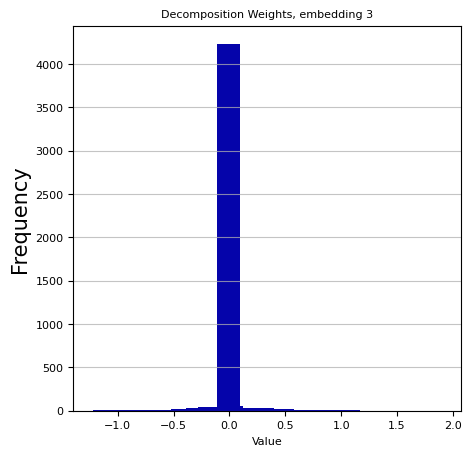

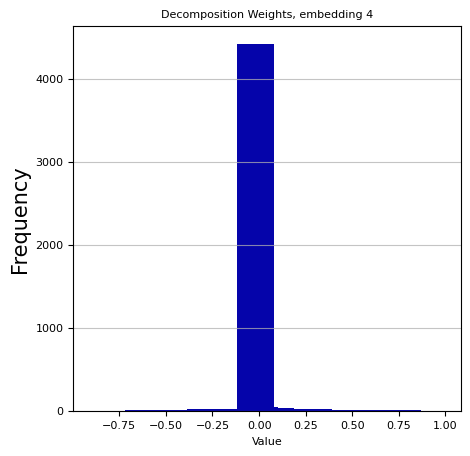

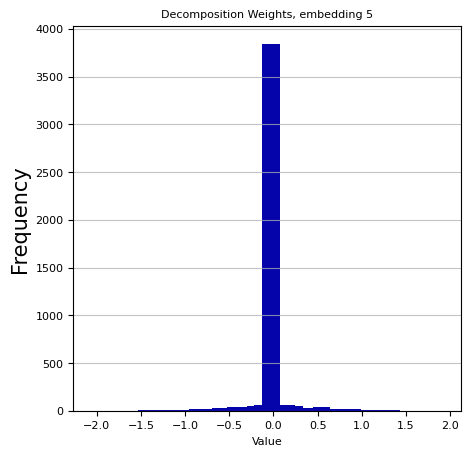

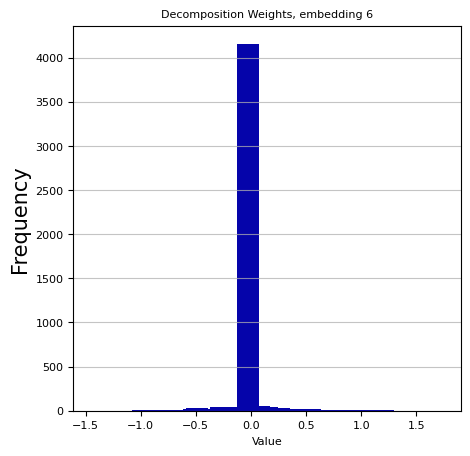

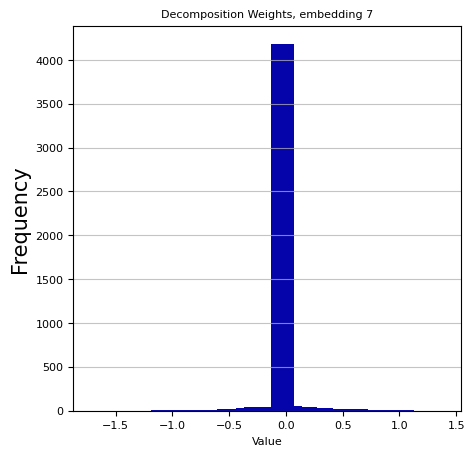

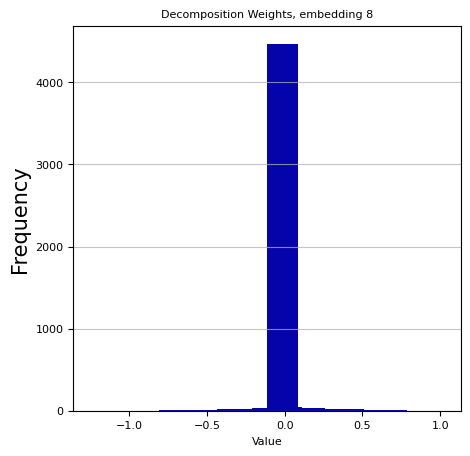

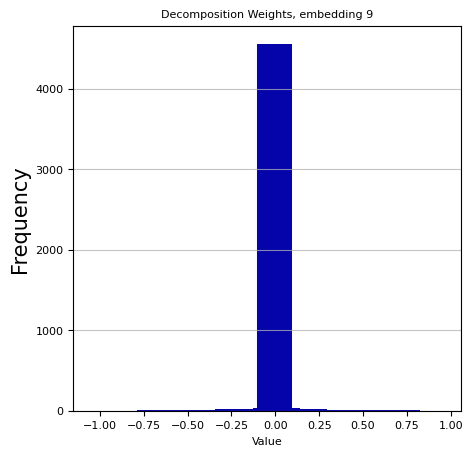

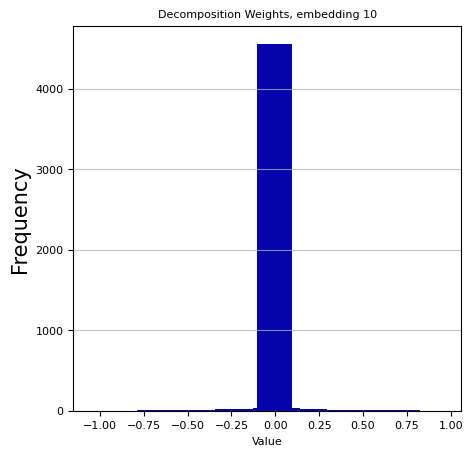

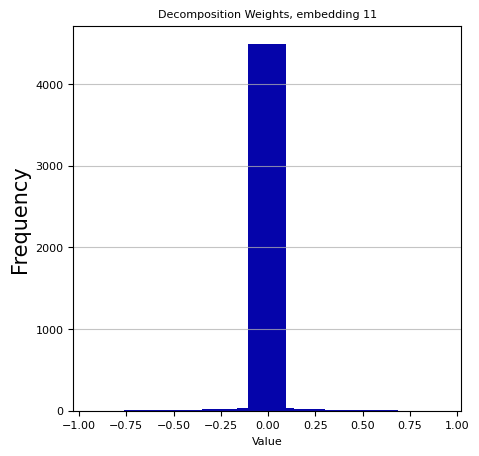

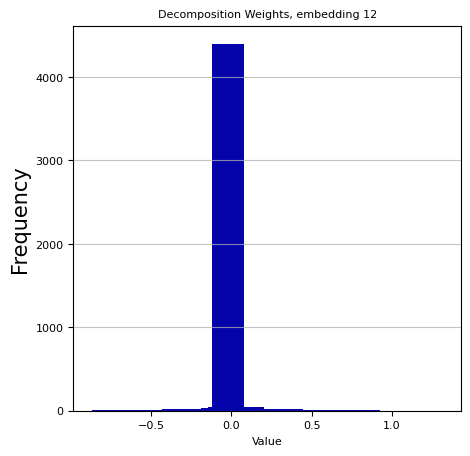

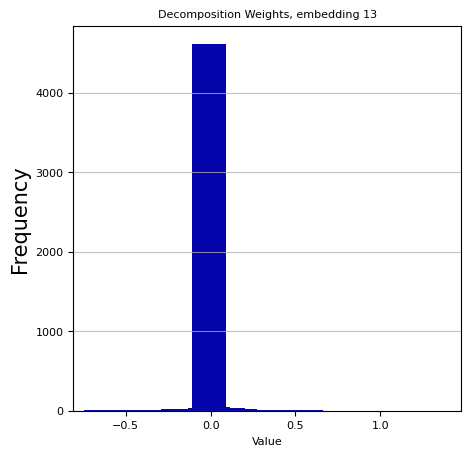

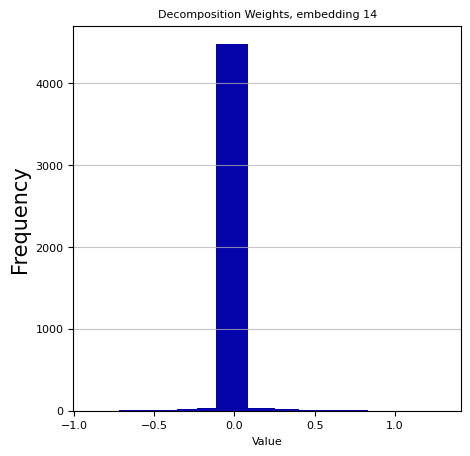

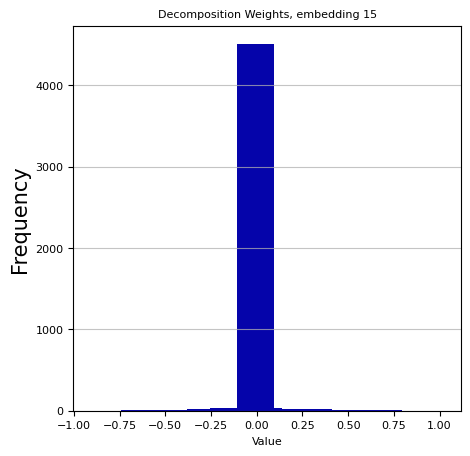

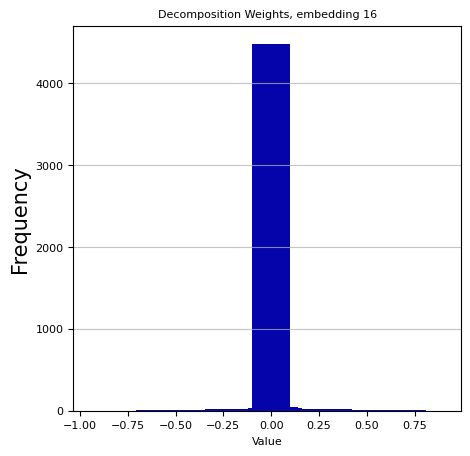

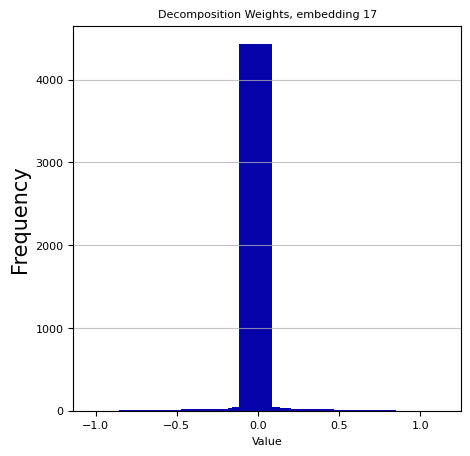

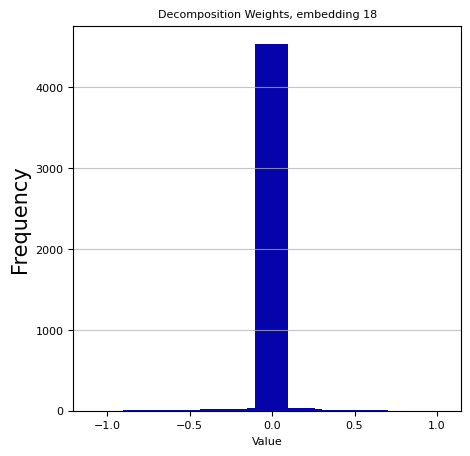

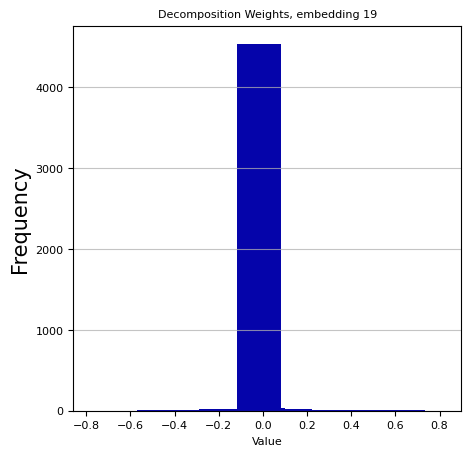

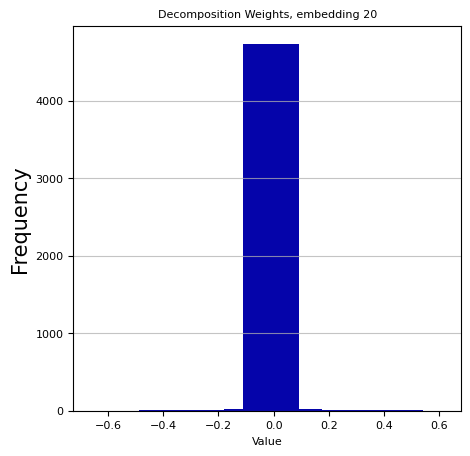

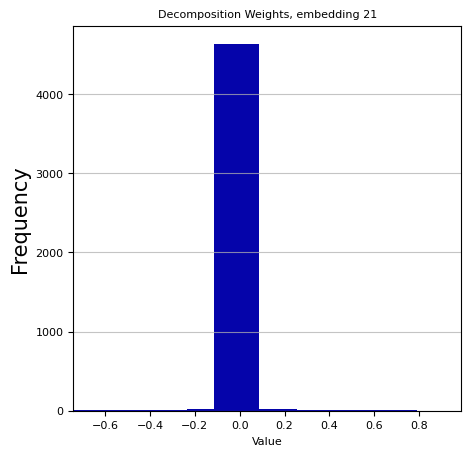

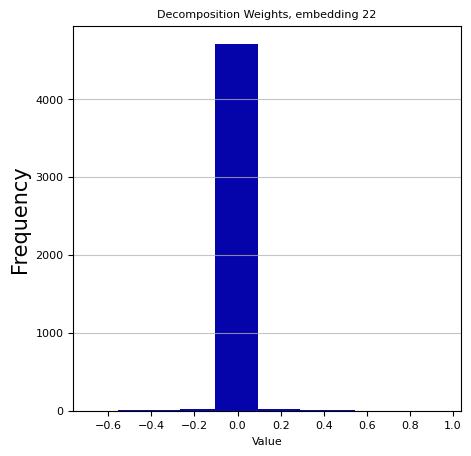

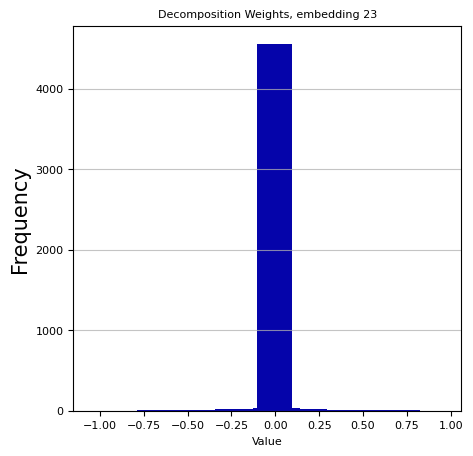

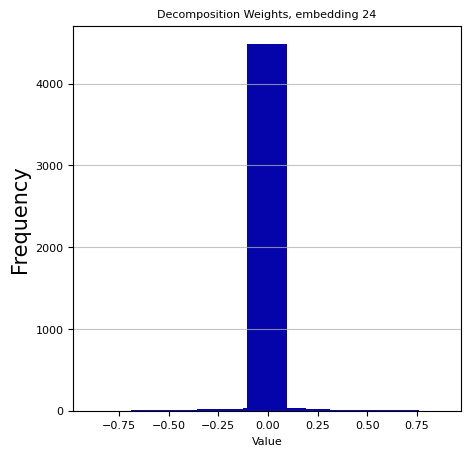

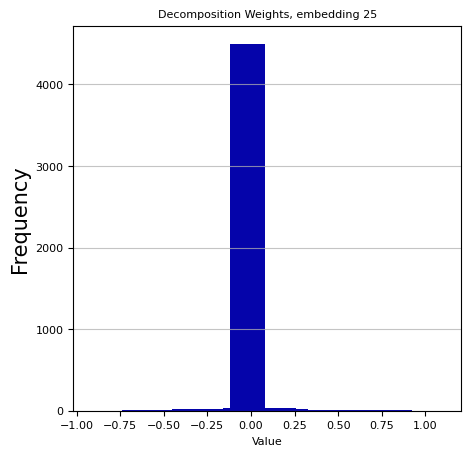

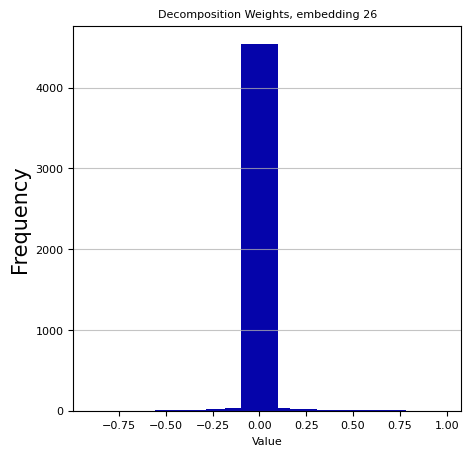

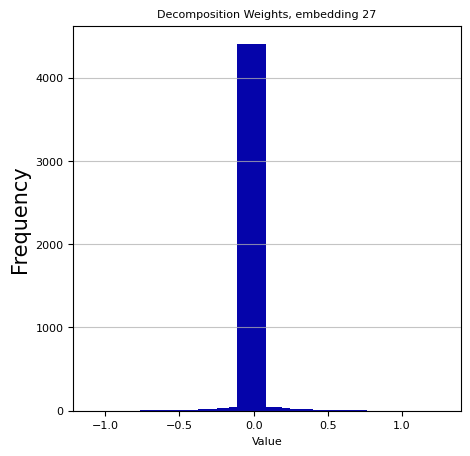

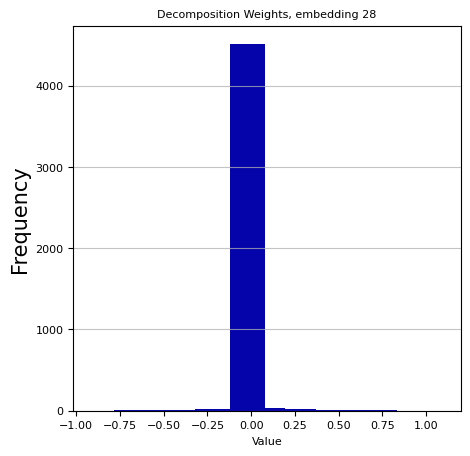

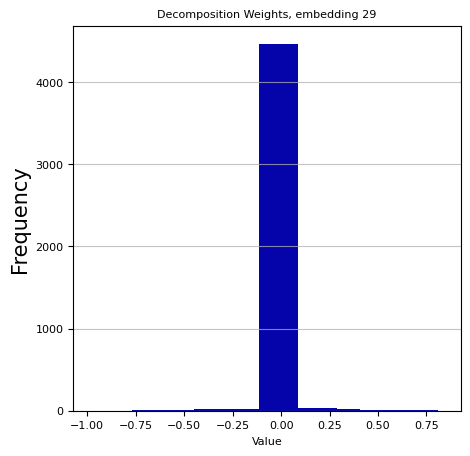

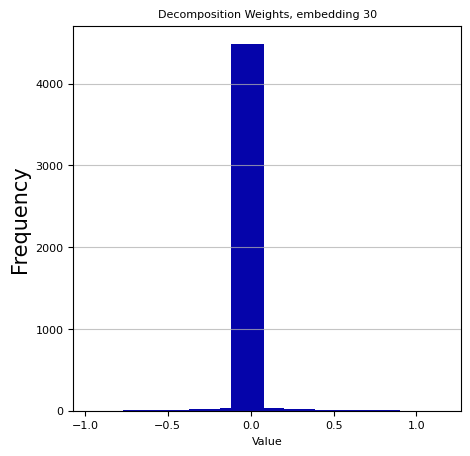

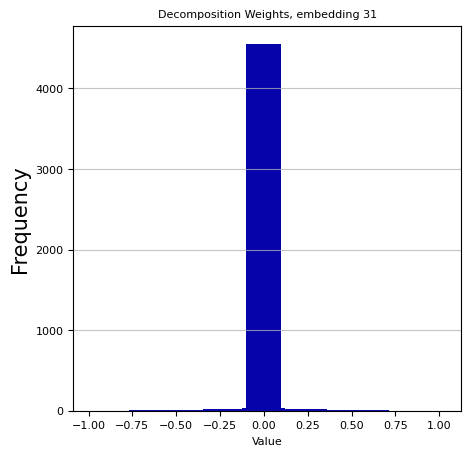

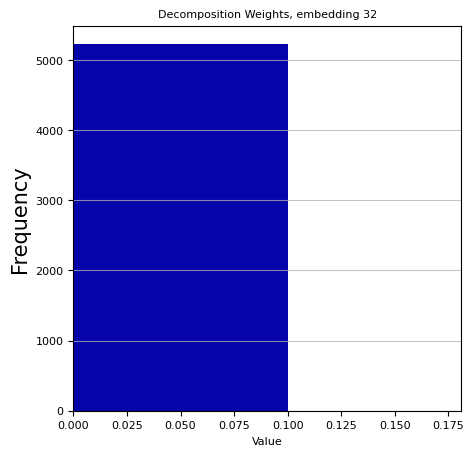

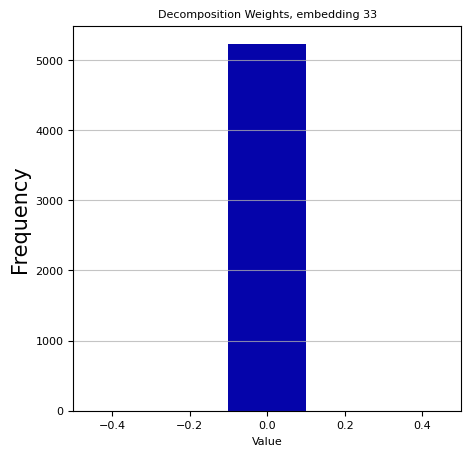

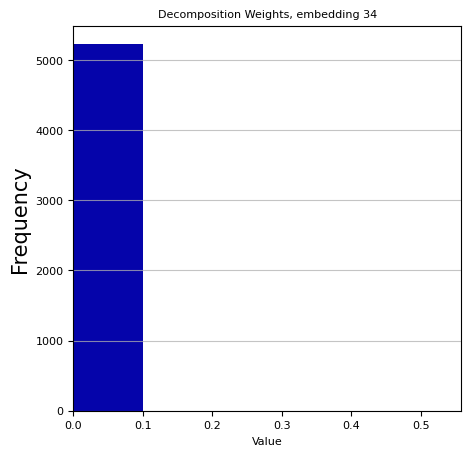

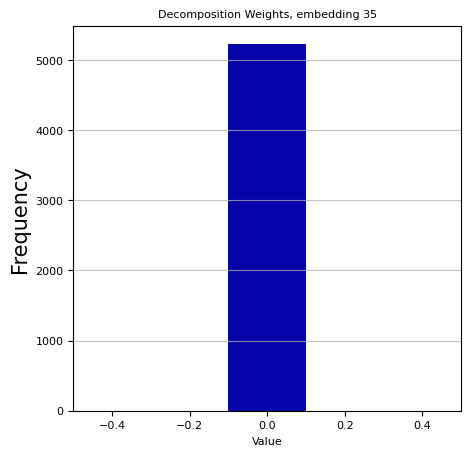

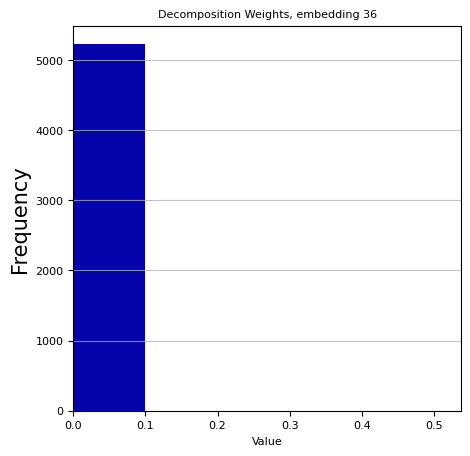

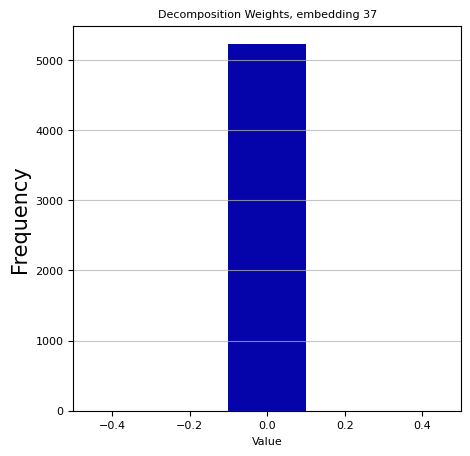

In [110]:
for i in range(len(decompositions)):
    weights = []
    for (weight, token) in decompositions[i]:
        weights.append(weight)
        
    np_hist = np.array(weights)

    hist,bin_edges = np.histogram(np_hist, bins = 100)
    plt.figure(figsize=[5,5])
    
    plt.bar(bin_edges[:-1], hist, width = 0.2, color='#0504aa',alpha=1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=8)
    plt.ylabel('Frequency',fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel('Frequency',fontsize=15)
    plt.title(f'Decomposition Weights, embedding {i}',fontsize=8)
    plt.show()

In [140]:
torch.dot(vocab_embeddings[0, 0, :], vocab_embeddings[0, 9, :]) / (torch.norm(vocab_embeddings[0, 0, :]) * torch.norm(vocab_embeddings[0, 9, :]))

tensor(0.0212, device='cuda:0', dtype=torch.float16)

### Feature decompositions

In [8]:
annotations_file = '/home/anish/vl-hallucination/data/coco/coco_karpathy_val.json'
with open(annotations_file, 'r') as f:
    karpathy_val = json.load(f)

In [9]:
karpathy_val

[{'image': 'val2014/COCO_val2014_000000184613.jpg',
  'image_id': 'COCO_val2014_000000184613.jpg',
  'references': ['A child holding a flowered umbrella and petting a yak.',
   'A young man holding an umbrella next to a herd of cattle.',
   'a young boy barefoot holding an umbrella touching the horn of a cow',
   'A young boy with an umbrella who is touching the horn of a cow.',
   'A boy holding an umbrella while standing next to livestock.']},
 {'image': 'val2014/COCO_val2014_000000403013.jpg',
  'image_id': 'COCO_val2014_000000403013.jpg',
  'references': ['A narrow kitchen filled with appliances and cooking utensils.',
   'A galley kitchen with cabinets and appliances on both sides',
   'A hallway leading into a white kitchen with appliances.',
   'Doorway view of a kitchen with a sink, stove, refrigerator and pantry.',
   'The pantry door of the small kitchen is closed.']},
 {'image': 'val2014/COCO_val2014_000000562150.jpg',
  'image_id': 'COCO_val2014_000000562150.jpg',
  'refere

In [6]:
from pycocotools.coco import COCO

In [7]:
coco_instances = COCO('/home/anish/vl-hallucination/annotations/instances_val2014.json')

loading annotations into memory...
Done (t=6.52s)
creating index...
index created!


In [10]:
cats = coco_instances.loadCats(coco_instances.getCatIds())

In [11]:
cats

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [8]:
caption = """The image depicts a man riding a brown horse through a lush green field. The man is wearing a helmet and appears to be in the process of riding the horse. There are several trees scattered throughout the field, providing shade for both the man and the horse. In addition to the man on the horse, there are two other people visible in the scene. One person is located near the left side of the image, while the other is positioned closer to the center of the field. Both individuals seem to be observing the man riding the horse."""

In [12]:
woi = [caption]
input_ids = []
# caption_tokens = []
for word in woi:
    for id in llm_tokenizer(word)["input_ids"]:
        if id not in input_ids:
            input_ids.append(id)
            # caption_tokens.append(id_to_token[id])
print(input_ids)

# # Select specific vocab tokens
# A = torch.index_select(vocab_embeddings.squeeze(0), 0, torch.tensor(input_ids).to(device))
# A = A.T.to(torch.float64).to(device)

# Use entire vocabulary
A = vocab_embeddings.squeeze(0).T.to(torch.float64).to(device)

# Invert vocabulary mapping
id_to_token = dict()
vocabulary = torch.load("vocabulary.pt")
for key in vocabulary:
    id_to_token[vocabulary[key]] = key


[1, 450, 1967, 1401, 919, 29879, 263, 767, 364, 4821, 17354, 10435, 1549, 301, 1878, 7933, 1746, 29889, 338, 591, 4362, 1081, 2527, 322, 5692, 304, 367, 297, 278, 1889, 310, 1670, 526, 3196, 10697, 29574, 10106, 29892, 13138, 528, 1943, 363, 1716, 512, 6124, 373, 727, 1023, 916, 2305, 7962, 9088, 3118, 2022, 5982, 2978, 2175, 2625, 1550, 2602, 287, 17649, 4818, 9134, 15724, 2833, 5366, 1747]


In [10]:
hidden_states = torch.load("/home/nickj/vl-hallucination/hidden_states_data/brown_horse_hidden_states.pt")

In [23]:
# reshape so that image embeddings and text embeddings put together
def reshape_hidden_states(hidden_states):
    # converts hidden states into shape (layer #s, beam count, hidden state #s, dims)
    all_embeddings = []
    for i in range(len(hidden_states)):
        if i == 0: # only get the image embeddings
            all_embeddings.append(torch.stack(hidden_states[i])[:, :, :32])
        else:
            all_embeddings.append(torch.stack(hidden_states[i]))
    all_hidden_states = torch.concat(all_embeddings, dim = 2)
    return all_hidden_states

In [12]:
all_hidden_states = reshape_hidden_states(hidden_states)

In [24]:
hidden_states_ls = all_hidden_states[:, 0, :, :]

In [84]:
y = hidden_states_ls[40, 15, :].unsqueeze(1).to(torch.float64)

stats = lasso_decomposition(y.T, A.T, vocabulary, l1_penalty=3)

In [85]:
stats

{'cosine_similarity': 0.43505777051743577,
 'nonzero': 157,
 'decomposition': [(1.351524005576224, 'тиче'),
  (1.0770968854137657, 'odox'),
  (1.050159424751499, 'cola'),
  (1.0351410610705851, '▁RE'),
  (-0.9579542998388463, '’'),
  (0.9011547504494418, '▁metadata'),
  (0.8873316396602401, 'gie'),
  (0.8720027404737661, 'äck'),
  (-0.8633542925552141, '▁Object'),
  (0.8541793576372646, 'uden'),
  (0.8434633218480568, 'ena'),
  (0.7886089949244329, '▁Johan'),
  (-0.77899252458859, '▁Barcel'),
  (-0.775970357468143, '▁bucket'),
  (-0.7647174537606728, '▁binary'),
  (-0.6956102792503884, 'ählt'),
  (-0.6901602548176525, '▁keeping'),
  (-0.6846919385404512, '▁happening'),
  (0.648064288642369, '▁effects'),
  (-0.6272112696765878, '▁Partido'),
  (-0.6240203488888886, 'Bad'),
  (-0.6213007099149622, '▁difficulty'),
  (-0.6092888013658178, 'location'),
  (0.6085055082600297, '▁Singh'),
  (0.5942198767600495, '▁hosting'),
  (0.588995943473176, '▁exercise'),
  (-0.5883764682855006, '▁crisis'),

In [21]:
import multiprocessing

In [15]:
image_embeddings[:, 1, :].shape

torch.Size([1, 5120])

In [17]:
image_embeddings_cpu = image_embeddings.to("cpu")

In [40]:
import time
from multiprocessing import Pool

def sleep_test(id, y_numpy, A_numpy, vocabulary, l1_penalty=5):
    time.sleep(5)
    return id, dict()

A_numpy = A.T.to("cpu")
# input_embeddings = hidden_states_ls[38, :3].to("cpu")
# Define your function
def sleep_and_return_result(lasso_id, target_embedding, A_numpy, vocabulary):
    # Sleep for the specified duration
    # Return the result
    stats = lasso_decomposition_no_cuda(target_embedding, A_numpy, vocabulary, l1_penalty=3)
    # stats = sleep_test(input_embeddings[lasso_id, :].unsqueeze(0).to("cpu"), A_numpy, vocabulary, l1_penalty=3)
    return lasso_id, stats

def parallelize_lasso():
    # input_embeddings: (# of embeddings, # dims)
    # Create a Pool object with the number of processes you want to use
    results_dict = dict()
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        # Define your arguments as a list of tuples (duration, value)
        arguments = [(i, image_embeddings_cpu[:, i].clone(), A_numpy.clone(), vocabulary) for i in range(1)]  # Example arguments
        
        # Use starmap function to apply your function to each tuple of arguments using multiple processes
        results = pool.starmap(sleep_and_return_result, arguments)
        print(results)
        
        # Organize the results
        for result_id, result_stats in results:
            results_dict[result_id] = result_stats

    return results_dict

In [ ]:
import time
start_time = time.time()
res = parallelize_lasso()

In [35]:
start_time = time.time()
stats = lasso_decomposition_no_cuda(image_embeddings_cpu[:, 0].clone(), A_numpy, vocabulary, l1_penalty=3)

In [ ]:
print(f"Executed in {time.time() - start_time}")

In [ ]:
# Make a heatmap, Embedding index vs. layer number
# This applies for a single image's hidden states

search_space = ["horse", "person", "people", "two", "other", "brown", "riding", "helmet", "field", "man", "tree"]
# search_token_space = set(caption_tokens)
search_token_space = set(seq_to_tokens(search_space, id_to_token))
print(f"Search tokens: {search_token_space}")

hidden_states_ls = all_hidden_states[:, 0, :, :]
words_to_rank_map = dict()
words_to_alpha_map = dict()

for tok in search_token_space:
    words_to_rank_map[tok] = []
    words_to_alpha_map[tok] = []

for embedding_ind in tqdm(range(hidden_states_ls.shape[1]), desc = "Embedding indices"):
    for tok in search_token_space:
        words_to_rank_map[tok].append([])
        words_to_alpha_map[tok].append([])
    
    for layer in range(39, hidden_states_ls.shape[0]):
        y = hidden_states_ls[layer, embedding_ind, :].unsqueeze(1).to(torch.float64)
        X = torch.linalg.lstsq(A, y).solution
        
        top_tokens = []
        for j in range(X.shape[0]):
            # top_tokens.append((X[j][0].to("cpu"), id_to_token[input_ids[j]])) # using subset of vocabulary
            top_tokens.append((X[j][0].to("cpu"), id_to_token[j])) # using entire vocabulary
        top_tokens.sort(key = lambda e: -torch.abs(e[0]))
        print(f"Embedding {embedding_ind}: {top_tokens[:10]}")

        # Find ranks and alphas of tokens in the search space
        for i in range(len(top_tokens)):
            alpha = top_tokens[i][0]
            token = top_tokens[i][1]
            if token in search_token_space:
                # print(f"Found {token}")
                words_to_rank_map[token][-1].append(i / A.shape[1])
                words_to_alpha_map[token][-1].append(alpha)
        

iding


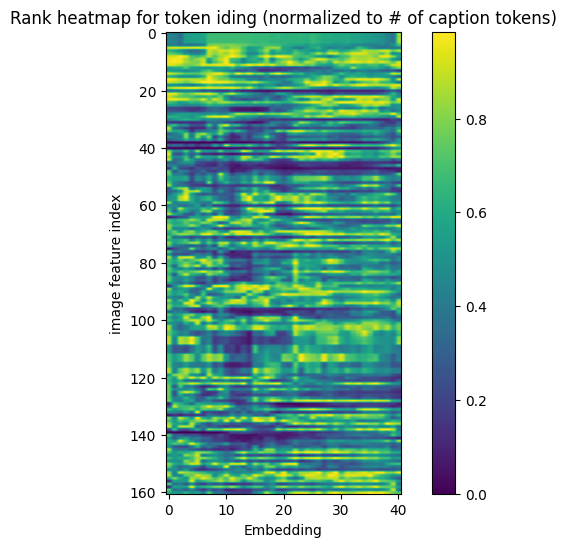

▁field


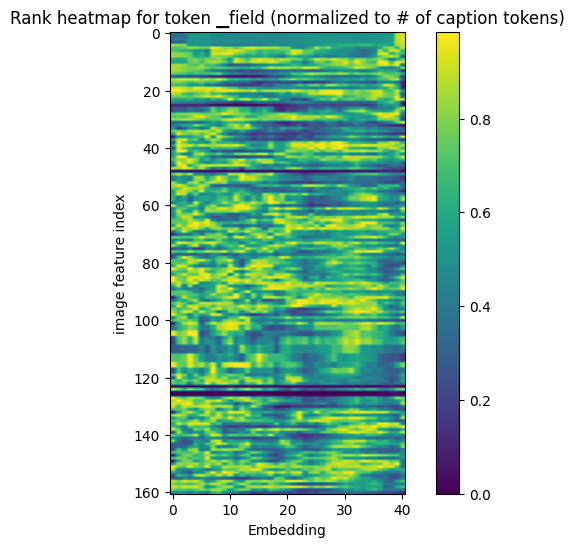

▁hel


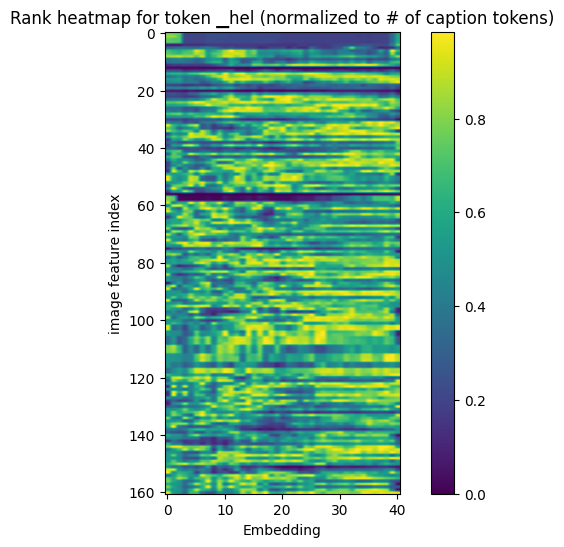

▁people


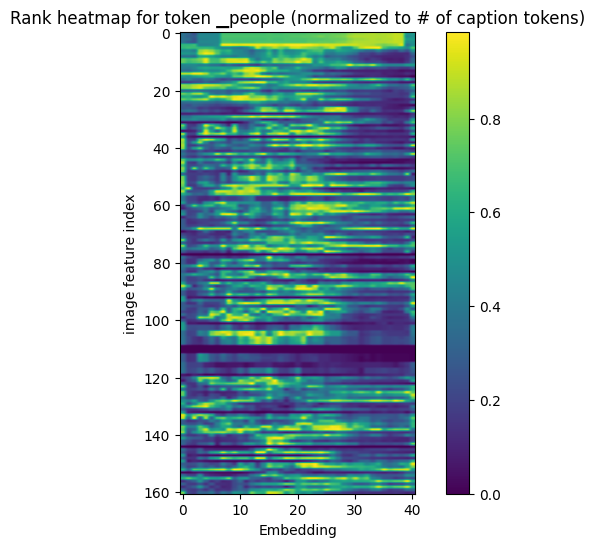

▁horse


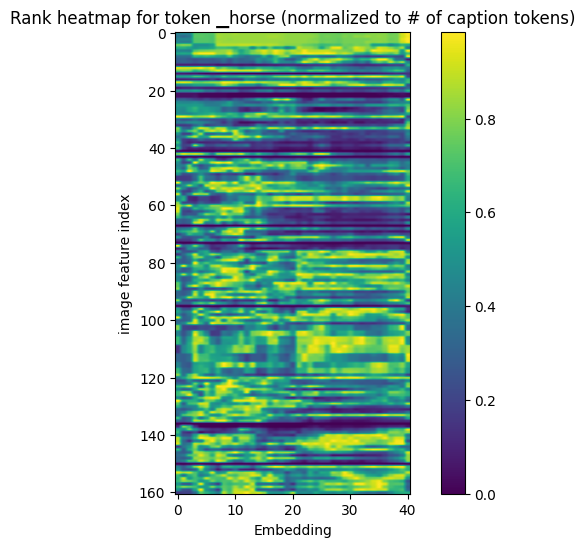

▁other


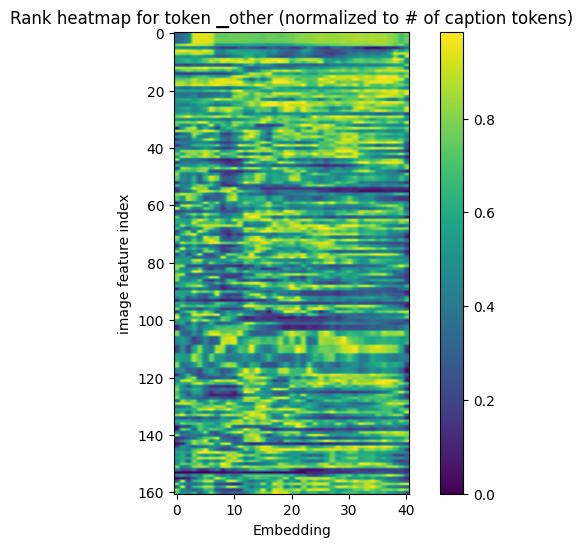

▁brown


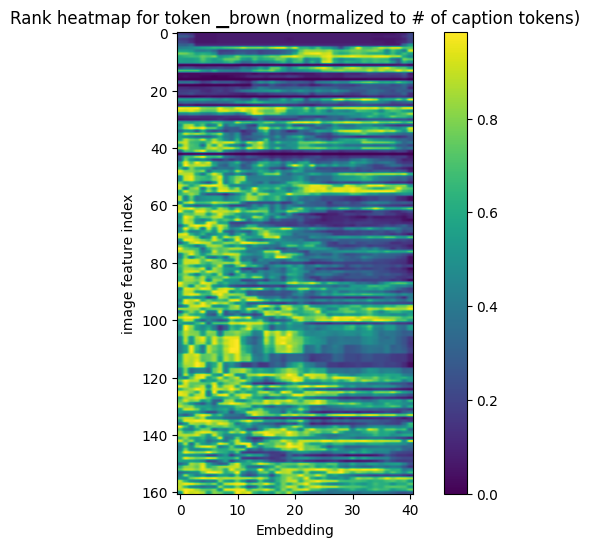

▁r


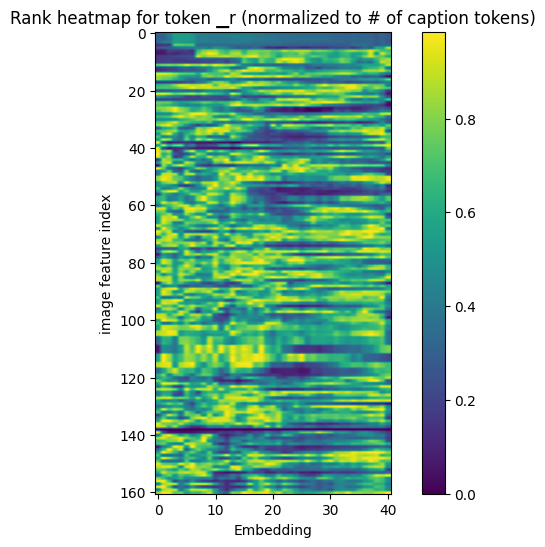

▁two


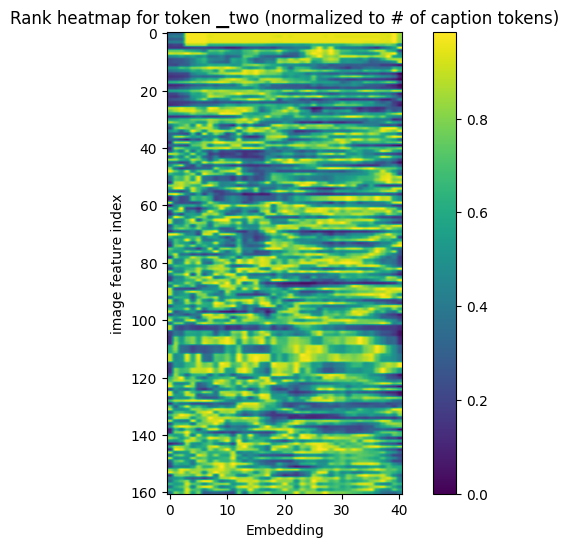

▁man


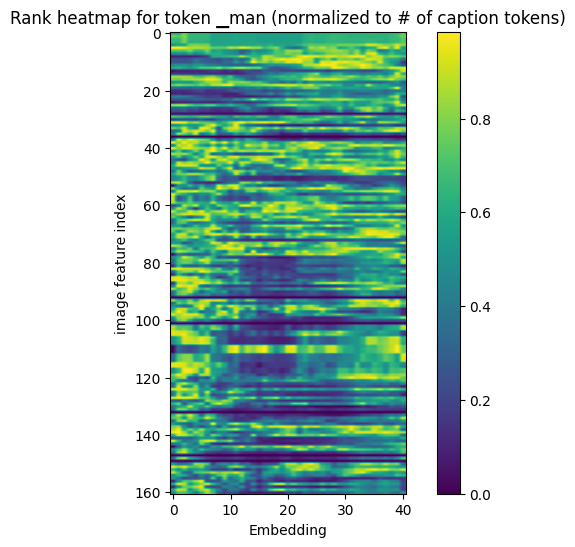

▁person


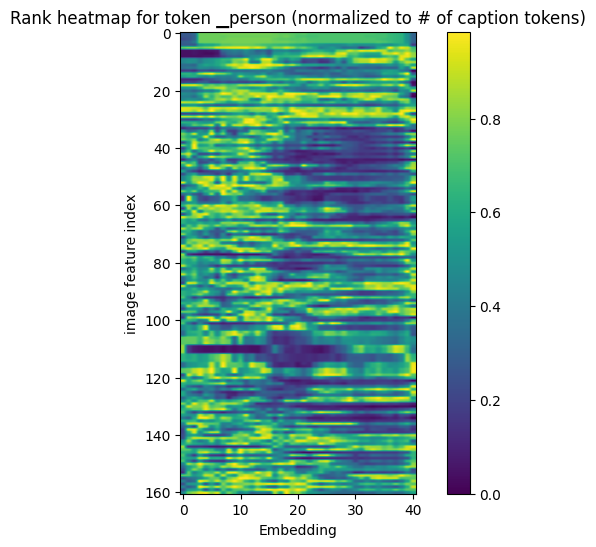

met


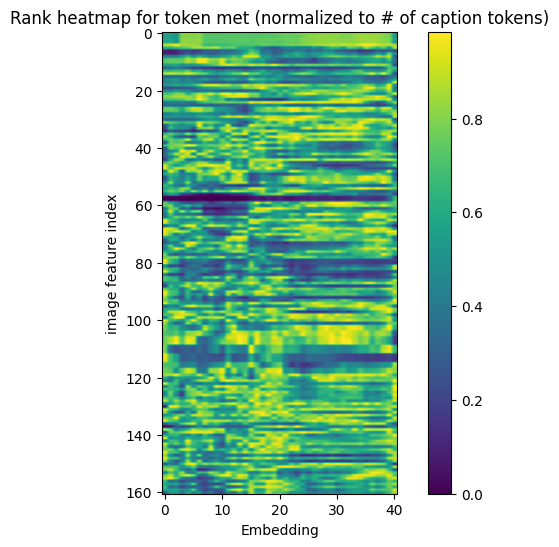

In [187]:
for word in search_token_space:
    if len(words_to_rank_map[word][0]) != 0:
        print(word)
        fig, ax = plt.subplots(figsize=(8, 6))
        # Create the heatmap with equal aspect ratio
        heatmap = ax.imshow(words_to_rank_map[word], cmap='viridis', aspect=.5)
        # Add colorbar
        cbar = ax.figure.colorbar(heatmap, ax=ax)
        # Set the title and labels
        ax.set_title(f"Rank heatmap for token {word} (normalized to # of caption tokens)")
        ax.set_xlabel("Embedding")
        ax.set_ylabel("image feature index")
        plt.show()

### Smart decompositions

In [ ]:
from torch import nn
import math
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 10000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [139]:
torch.save(image_embeddings_blue[:, 17], "image_embeddings_blue17.pt")

In [22]:
# Initialize parameters

# Start from the right tokens
initial_space = ["blue", "box", "square", "rectangle", "solid", "white background", "image", "photo", "size", "shape", "color", "appearance"]
initial_token_space = seq_to_tokens(initial_space, id_to_token)

# nearest = dict() # maps a token with a list (32000) of the closest tokens, farthest to closest


In [12]:
normalized_vocab = torch.nn.functional.normalize(vocab_embeddings.squeeze(0), dim = 1)

In [13]:
vocab_similarity = torch.mm(normalized_vocab, normalized_vocab.t())

In [26]:
# Remove tokens from the vocab list that are most different from the initial search space
vocabulary_set = set(vocabulary.keys())
k = 1000 # remove vocabulary tokens until we get to k tokens
nearest = dict()
for tok in initial_token_space:
    if tok not in nearest:
        sorted_sim, indices = torch.sort(vocab_similarity[vocabulary[tok]])
        nearest[tok] = [sorted_sim, indices, 0]

count = 0

while len(vocabulary_set) > k:
    max_dissimilar = None
    for tok in initial_token_space:
        similarities, indices, curr_ind = nearest[tok]
        while id_to_token[int(indices[curr_ind])] not in vocabulary_set:
            curr_ind += 1
        nearest[tok][2] = curr_ind

        if max_dissimilar == None:
            max_dissimilar = (similarities[curr_ind], indices[curr_ind], tok)
        elif similarities[curr_ind] < max_dissimilar[0]:
            max_dissimilar = (similarities[curr_ind], indices[curr_ind], tok)

    similarities, indices, curr_ind = nearest[max_dissimilar[2]]
    nearest[max_dissimilar[2]][2] += 1
    removed_token = id_to_token[int(max_dissimilar[1])]
    print(f"Removing most dissimilar token from {max_dissimilar[2]}: {removed_token}")
    count += 1
    vocabulary_set.remove(removed_token)
print(count, len(vocabulary) - len(vocabulary_set))

Removing most dissimilar token from ▁rectangle: ▁Ста
Removing most dissimilar token from ▁rectangle: ാ
Removing most dissimilar token from ▁rectangle: ▁urs
Removing most dissimilar token from ▁rectangle: ▁dop
Removing most dissimilar token from ▁rectangle: 记
Removing most dissimilar token from ▁rectangle: mbox
Removing most dissimilar token from ▁rectangle: 因
Removing most dissimilar token from ▁rectangle: त
Removing most dissimilar token from ▁rectangle: спо
Removing most dissimilar token from ▁rectangle: І
Removing most dissimilar token from ▁rectangle: ▁Dav
Removing most dissimilar token from ▁rectangle: ń
Removing most dissimilar token from ▁rectangle: 喜
Removing most dissimilar token from ▁rectangle: <0xCE>
Removing most dissimilar token from ▁rectangle: ▁Hend
Removing most dissimilar token from ▁rectangle: ̍
Removing most dissimilar token from ▁rectangle: ▁Ferd
Removing most dissimilar token from ▁box: dependencies
Removing most dissimilar token from ▁color: DOC
Removing most dis

In [27]:
token_ids = []
for tok in vocabulary_set:
    token_ids.append(vocabulary[tok])

# Find least squares solution
y = image_embeddings_blue[:, 16].T.to(torch.float64).to(device)
A_sub = A[:, token_ids].to(torch.float64)
X = torch.linalg.lstsq(A_sub, y).solution

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
reconstruction = A_sub @ X
cos_sim = cos(reconstruction.squeeze(1), y.squeeze(1))
print(cos_sim)
print(torch.dist(reconstruction, y))

# Expect that X is of shape (32001, 1)
top_tokens = []
for j in range(X.shape[0]):
    # top_tokens.append((X[j][0].to("cpu"), id_to_token[input_ids[j]])) # using subset of vocabulary
    top_tokens.append((X[j][0].to("cpu"), id_to_token[token_ids[j]])) # using entire vocabulary
top_tokens.sort(key = lambda e: -torch.abs(e[0]))

tensor(0.4486, device='cuda:0', dtype=torch.float64)
tensor(37.9435, device='cuda:0', dtype=torch.float64)


In [31]:
TOKEN_UNDERSCORE + "large" in vocabulary_set

True

In [32]:
[token[1] for token in top_tokens]

['ederbörd',
 '▁blue',
 '▁espa',
 '▁curl',
 '▁CGRect',
 '▁atom',
 '▁dark',
 '▁bottom',
 '▁boat',
 '▁regex',
 '▁Brand',
 '▁profiles',
 '片',
 '▁machine',
 '▁cabinet',
 '▁snapshot',
 '▁tree',
 '▁calcio',
 '▁conversion',
 '▁chamber',
 '▁showing',
 '▁attacks',
 '▁boxes',
 '▁tunnel',
 '▁gold',
 '▁brown',
 '▁punk',
 '▁entropy',
 '▁gradient',
 '▁float',
 '▁channel',
 '▁protected',
 '▁Street',
 '▁reading',
 '▁community',
 '▁Template',
 '▁toggle',
 '▁bridge',
 '▁turn',
 '▁labels',
 '▁offset',
 '▁sizes',
 'Color',
 '▁send',
 '▁bind',
 '▁household',
 '▁browser',
 '▁alto',
 '▁painted',
 '▁natural',
 '▁temper',
 '▁explore',
 '▁round',
 '▁wheel',
 '▁northern',
 '▁site',
 '▁working',
 '▁introduction',
 '▁value',
 'ång',
 '▁message',
 '▁align',
 '▁Switch',
 '▁choice',
 '▁circul',
 '▁stir',
 '▁lip',
 '▁visibility',
 '▁gallery',
 '▁Williams',
 '▁closure',
 '▁rectangle',
 '▁breath',
 '▁Selection',
 '▁signature',
 '▁semif',
 '▁червня',
 '▁hardware',
 '▁silence',
 '▁yellow',
 '▁iteration',
 '▁contents',
 '▁

In [146]:

max_iter = 500
target_sim = 0.8
iters = 0
interval_change = 5 # number of tokens to add on each time
y = image_embeddings_blue[:, 16].T.to(torch.float64).to(device)
while iters < max_iter:
    # Convert token space to ids
    token_ids = []
    for tok in initial_token_space:
        token_ids.append(vocabulary[tok])
    
    A_sub = A[:, token_ids]
    X = torch.linalg.lstsq(A_sub, y).solution

    # calculate accuracy metrics
    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    reconstruction = A_sub @ X
    cos_sim = cos(reconstruction.squeeze(1), y.squeeze(1))
    print(cos_sim)

    if cos_sim < target_sim:
        for new_token_cnt in range(interval_change):
            # Search for the nearest tokens
            max_pair = None
            for tok in initial_token_space:
                if tok not in nearest:
                    # Create the list of closest tokens
                    nearest_tokens = []
                    for i in range(vocab_embeddings.shape[1]):
                        if i == vocabulary[tok]: # don't allow comparisons with itself
                            continue
                        nearest_tokens.append((cos(vocab_embeddings[0, vocabulary[tok], :], vocab_embeddings[0, i, :]), id_to_token[i]))
                    nearest_tokens.sort()
                    nearest[tok] = nearest_tokens
                while nearest[tok][-1][1] in initial_token_space:
                    print(f"Removing {nearest[tok][-1][1]} from list")
                    nearest[tok].pop()
    
                if max_pair == None or max_pair[0][0] < nearest[tok][-1][0]:
                    max_pair = nearest[tok][-1], tok
            print(f"Found best pair closest to token {max_pair[1]}: {max_pair[0]}")
            initial_token_space.append(max_pair[0][1])
            nearest[max_pair[1]].pop()
    else:
        break
    iters += 1
    

tensor(0.1617, device='cuda:0', dtype=torch.float64)
Removing ▁%) from list
Removing %). from list
Found best pair closest to token %).: (tensor(0.4592, device='cuda:0', dtype=torch.float16), '%.')
Removing %). from list
Found best pair closest to token %.: (tensor(0.4355, device='cuda:0', dtype=torch.float16), '%,')
Removing %, from list
Removing %. from list
Found best pair closest to token %).: (tensor(0.4333, device='cuda:0', dtype=torch.float16), '/).')
Found best pair closest to token /).: (tensor(0.5952, device='cuda:0', dtype=torch.float16), '/),')
Removing /). from list
Found best pair closest to token /),: (tensor(0.5303, device='cuda:0', dtype=torch.float16), '/)')
tensor(0.1666, device='cuda:0', dtype=torch.float64)
Removing /) from list
Removing /), from list
Removing /). from list
Found best pair closest to token /).: (tensor(0.4468, device='cuda:0', dtype=torch.float16), '`).')
Removing `). from list
Removing %). from list
Found best pair closest to token `).: (tensor(0.

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 47.51 GiB total capacity; 45.58 GiB already allocated; 5.38 MiB free; 46.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [148]:
list(reversed(initial_token_space))

['▁(-',
 '▁{-',
 '{-',
 '>\\<^',
 '\\<^',
 '>\\<',
 '\\<',
 '▁\\<',
 '▁(\\<',
 '▁"\\<',
 ':/',
 '=/',
 '▁~',
 '~',
 '.~',
 'mathchar',
 '"?>',
 '>[',
 '>{',
 '$_',
 '($_',
 '▁$_',
 "'(",
 'timeout',
 '▁timeout',
 'Timeout',
 '▁setTimeout',
 '▁^',
 '▁{%',
 '{%',
 '-,',
 '══',
 '════',
 '────',
 '*}',
 'setState',
 'emplo',
 'ispiel',
 '▁Beispiel',
 'пример',
 'empio',
 '▁exemple',
 '▁esempio',
 '▁ejemplo',
 'examples',
 '▁examples',
 '▁example',
 '▁instances',
 '▁instance',
 'instance',
 'Instance',
 'getInstance',
 'getString',
 'getMessage',
 'getName',
 'getElement',
 'getValue',
 'getText',
 'setText',
 '▁[:',
 '[:',
 '(:',
 '▁(:',
 '▁{:',
 '{:',
 '▁`:',
 '▁":',
 ';\\',
 'vert',
 '../../',
 '../',
 '▁../',
 "▁'./",
 '▁./',
 './',
 '▁####',
 '▁###',
 '▁---',
 '---',
 ':@"',
 '(@"',
 '▁@"',
 '@"',
 '@",',
 '(.',
 '▁(.',
 '{.',
 '=.',
 '>\\',
 '>>',
 '(...',
 '(*)',
 '(...)',
 '...]',
 '...)',
 '▁...)',
 '▁***',
 '***',
 '(&',
 '▁`&',
 '/$',
 '-$',
 '|$',
 "''",
 "▁''",
 '▁[[',
 '[[',


In [145]:
list(reversed(nearest["blue"]))

[(tensor(0.2355, device='cuda:0', dtype=torch.float16), 'black'),
 (tensor(0.2277, device='cuda:0', dtype=torch.float16), 'gray'),
 (tensor(0.2241, device='cuda:0', dtype=torch.float16), 'yellow'),
 (tensor(0.2146, device='cuda:0', dtype=torch.float16), 'green'),
 (tensor(0.1801, device='cuda:0', dtype=torch.float16), 'white'),
 (tensor(0.1597, device='cuda:0', dtype=torch.float16), '▁grey'),
 (tensor(0.1561, device='cuda:0', dtype=torch.float16), '▁yellow'),
 (tensor(0.1549, device='cuda:0', dtype=torch.float16), '▁gray'),
 (tensor(0.1433, device='cuda:0', dtype=torch.float16), 'upper'),
 (tensor(0.1425, device='cuda:0', dtype=torch.float16), 'colors'),
 (tensor(0.1396, device='cuda:0', dtype=torch.float16), 'Upper'),
 (tensor(0.1382, device='cuda:0', dtype=torch.float16), 'Black'),
 (tensor(0.1366, device='cuda:0', dtype=torch.float16), 'four'),
 (tensor(0.1366, device='cuda:0', dtype=torch.float16), 'bottom'),
 (tensor(0.1361, device='cuda:0', dtype=torch.float16), '▁black'),
 (tens

### Gaussian Decomposition

In [68]:
rand_vocab_embeddings = torch.normal(0, 0.01, size=(1, 30000, 5120), dtype = torch.float64).squeeze().to(device)
rand_y = torch.normal(0, 0.1, size=(1, 5120), dtype = torch.float64).to(device)

In [29]:
rand_coffs

tensor([[ 0.1729],
        [ 0.0732],
        [-0.0489],
        ...,
        [-0.0677],
        [ 0.0195],
        [-0.0321]], dtype=torch.float64)

In [28]:
torch.maximum(rand_coffs, torch.zeros((num_atoms, 1)))

tensor([[0.1729],
        [0.0732],
        [0.0000],
        ...,
        [0.0000],
        [0.0195],
        [0.0000]], dtype=torch.float64)

In [29]:
import numpy as np

rand_vocab_embeddings_np = np.array(rand_vocab_embeddings).astype(np.float64)
rand_coffs_np = np.array(rand_coffs).astype(np.float64)

ATA_np = rand_vocab_embeddings_np.T @ rand_vocab_embeddings_np

ATA_inv_np = np.linalg.inv(ATA_np)

In [27]:
rand_coffs_np.astype(np.double)

AttributeError: module 'numpy' has no attribute 'double32'

In [12]:
ATA = rand_vocab_embeddings.T @ rand_vocab_embeddings

ATA_inv = torch.linalg.pinv(ATA)

# ATA @ ATA_inv
print(torch.linalg.matrix_rank(ATA))

tensor(2000)


In [16]:
X = ATA_inv @ rand_vocab_embeddings.T @ rand_coffs

In [8]:
import math

# Try cosine similarity derivative: https://math.stackexchange.com/questions/1923613/partial-derivative-of-cosine-similarity

def my_nnls(A, b, t = 0.1, max_iter = 50, device = device):
    m, n = A.shape[0], A.shape[1]
    x = torch.zeros((n, 1), dtype=torch.float64).to(device)
    zeros = torch.zeros((n, 1), dtype=torch.float64).to(device)
    ATA = A.T @ A
    ATb = A.T @ b
    for i in range(max_iter):
        grad = ATA @ x - ATb
        x = torch.maximum(x - t * grad, zeros)

        print(f"Iteration {i}: dist {torch.dist(A @ x, b)}")
    del ATA
    del ATb
    torch.cuda.empty_cache()
    return x

In [3]:
A = torch.load("/home/nickj/vl-hallucination/test_vocab.pt").to("cpu").numpy()
y = torch.load("/home/nickj/vl-hallucination/test_y.pt").to("cpu").numpy()

In [2]:
from sklearn.decomposition import SparseCoder

In [25]:
# TODO: normalize the dictionary before passing in (according to the docs)
coder = SparseCoder(dictionary = A.T, transform_algorithm="lasso_cd")

In [26]:
X = coder.transform(y.T)

In [32]:
X

array([[ 0.        ,  1.03223182, -1.12703604, ...,  0.        ,
         0.        , -0.        ]])

In [27]:
np.where(X > 0)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([    1,   134,   139, ..., 31522, 31703, 31793]))

In [28]:
X.shape

(1, 32001)

In [29]:
np.linalg.norm(X @ A.T - y.T)

44.98142600187214

In [30]:
estimated_y = (X @ A.T).squeeze(0)

In [31]:
np.dot(estimated_y, y.squeeze(1)) / (np.linalg.norm(estimated_y) * np.linalg.norm(y.squeeze(1)))

0.8476865643536181

In [24]:
apply_layernorm(A.T).T

torch.Size([5120, 32001])

In [21]:
y_norm = apply_layernorm(y.T)

In [26]:
y.T.mean(dim = -1)

tensor([1.0447e-08], device='cuda:0', dtype=torch.float64)

In [9]:
from experiments.fnnls

In [1]:
from experiments.fnnls import fnnls
import numpy as np
import torch

In [3]:
Z = np.abs(np.random.rand(5,10)) 
x = np.abs(np.random.rand(5))
weights = fnnls(Z, x)

In [4]:
weights

[array([0.        , 0.62058657, 0.        , 0.        , 0.18663786,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 0.38876363163888694]

In [20]:
np.linalg.norm(Z @ weights[0] - x)

0.3910399013132353

In [ ]:
# x = my_nnls(rand_vocab_embeddings.T, rand_y.T, t = 0.2, max_iter = 100)
x = my_nnls(A, y, t = 0.005, max_iter = 5000)

In [34]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [37]:
cos(A @ x, y)

tensor([0.3594], device='cuda:0', dtype=torch.float64)

In [19]:
from scipy.optimize import nnls

In [21]:
nnls(rand_vocab_embeddings, rand_coffs, maxiter = 20)

RuntimeError: Maximum number of iterations reached.

In [ ]:
# Trying to make the base image template from gaussian noise

In [5]:
num_atoms = 2000

In [15]:
rand_vocab_embeddings = torch.normal(0, 0.01, size=(1, num_atoms, 5120))
A = rand_vocab_embeddings.squeeze(0).T.to(torch.float32).to(device)


In [323]:
rand_coffs = torch.normal(0, 0.1, size=(num_atoms, 1)).to(device)

In [324]:
(A @ rand_coffs).norm()

tensor(3.2181, device='cuda:0')

In [325]:
torch.norm(rand_vocab_embeddings[:, 500, :])

tensor(0.7211)

In [388]:
base = torch.sum(image_embeddings, dim = 1)

In [421]:
base = image_embeddings[:, 26, :]

In [422]:
base.norm()

tensor(45.3851, device='cuda:0')

In [529]:
cos(get_image_embeddings(image_file, layernorm = True)[:, :32, :].squeeze(), apply_layernorm(constructed_embeddings).squeeze())

['A dog wearing sunglasses is sitting on a surfboard in the ocean.']
Image embeddings shape: torch.Size([1, 38, 5120])


tensor([0.7479, 0.7137, 0.7382, 0.8483, 0.5900, 0.7489, 0.6741, 0.8029, 0.5219,
        0.7190, 0.6317, 0.4616, 0.3818, 0.4716, 0.3547, 0.5204, 0.4970, 0.5026,
        0.5393, 0.3925, 0.4169, 0.3476, 0.4311, 0.6317, 0.4306, 0.5721, 0.5627,
        0.5057, 0.5398, 0.6959, 0.5272, 0.6811], device='cuda:0')

In [515]:
# image_embeddings = get_image_embeddings(image_file, layernorm = True)
decompositions = []

composition = {
    "default": "a dog sits on top of a surfboard in the ocean",
    3: "surfboard in the ocean",
    4: "the ocean",
    8: "dog",
    7: "dog",
    9: "a dog sits on",
    # 12: "surfboard",
    # 13: "surfboard",
    # 14: "ocean",
    26: "a dog sits on top",
    27: "surfboard in the ocean",
    28: "dog",
    29: "dog",

    # 12: "groom bride",
    # 13: "groom bride",
    # 26: "groom bride",
    # 27: "groom bride",
    # 28: "groom bride",
    # 29: "groom bride",
    # 30: "groom bride",
    # 31: "groom bride",
}

caption = "a cat sits on top of a surfboard in the ocean"
index = 0
interval = 9
caption_parts = caption.split(" ")

add_factor = 10

new_embeddings = []
for i in range(32):
    # rand_coffs = torch.normal(0, 0.1, size=(num_atoms, 1)).to(device)
    # y = base.T / add_factor
    new_embedding = torch.zeros((5120, 1)).to(device)
    new_embedding += image_embeddings_blank[:, i, :].T.to(device)
    if i in composition:
        tokens = seq_to_tokens([composition[i]], id_to_token)
    else:
        tokens = seq_to_tokens([composition["default"]], id_to_token)

    # tokens = []
    # for j in range(interval):
    #     tokens.append(caption_parts[index])
    #     index = (index + 1) % len(caption_parts)
    # tokens = seq_to_tokens(tokens, id_to_token)
    
    for token in tokens:
        print(f"adding {token} in embedding {i}")
        # new_embedding = apply_layernorm(new_embedding.T).T
        new_embedding += add_factor * vocab_embeddings[:, vocabulary[token], :].T
        # print(new_embedding.shape)
        # new_embedding = apply_layernorm(new_embedding.T).T
        # print(new_embedding)
    new_embedding -= add_factor * vocab_embeddings[:, vocabulary["black"], :].T
    new_embeddings.append(new_embedding.T)

constructed_embeddings = torch.cat(new_embeddings, dim = 0).unsqueeze(0)


adding ▁a in embedding 0
adding ▁dog in embedding 0
adding ▁s in embedding 0
adding its in embedding 0
adding ▁on in embedding 0
adding ▁top in embedding 0
adding ▁of in embedding 0
adding ▁a in embedding 0
adding ▁sur in embedding 0
adding f in embedding 0
adding board in embedding 0
adding ▁in in embedding 0
adding ▁the in embedding 0
adding ▁ocean in embedding 0
adding ▁a in embedding 1
adding ▁dog in embedding 1
adding ▁s in embedding 1
adding its in embedding 1
adding ▁on in embedding 1
adding ▁top in embedding 1
adding ▁of in embedding 1
adding ▁a in embedding 1
adding ▁sur in embedding 1
adding f in embedding 1
adding board in embedding 1
adding ▁in in embedding 1
adding ▁the in embedding 1
adding ▁ocean in embedding 1
adding ▁a in embedding 2
adding ▁dog in embedding 2
adding ▁s in embedding 2
adding its in embedding 2
adding ▁on in embedding 2
adding ▁top in embedding 2
adding ▁of in embedding 2
adding ▁a in embedding 2
adding ▁sur in embedding 2
adding f in embedding 2
adding

In [516]:
# cluster_embeddings_with_threshold(constructed_embeddings.squeeze(), threshold = 0.9, verbose = True)

In [517]:
inputs_embeds = constructed_embeddings
atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)

In [528]:
constructed_embeddings.shape

torch.Size([1, 32, 5120])

In [519]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
cos(inputs_embeds[:, 5, :],inputs_embeds[:, 6, :])

tensor([0.3975], device='cuda:0')

In [520]:
out = captioner.model.generate(  # type: ignore
            test_input,
            num_beams=5,
            max_length=200,
            return_embeds=True,
            atts_vision=atts_llm,
            inputs_vision=inputs_embeds, # stick input embeddings from vision here
            # pure_llm = True # meaning only text model used
        )
print(out[0])

['<s> a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of a dog on a surfboard in the ocean. a photo of']


### Lasso Regression

In [487]:
input_size

32001

In [728]:
import seaborn as sns
class LinearRegression():
    """"My custom regression class"""   
    def __init__(self, C=0.1,lr=1e-3, penalty=None, n_iter=10000, fit_intercept=True):
        self.C = C
        self.lr = lr
        self.history = []
        self.penalty = penalty 
        self.n_iter = n_iter
        self.fit_intercept= fit_intercept
        self.loss_func = nn.CosineEmbeddingLoss()
        return
    
    def add_intercept(self,x):
        a = torch.ones(x.size()[0],1).to(device)
        return torch.cat((x,a),axis=1)
    
    def linreg(self, x):
        """"Linear regression function"""  
        return x @ self.w.t() + self.b            # matrix multiply inputs (x) with the transposed weights (w) and add the intercept (b)
    
    def loss(self, y, y_hat):
        """"Calculate loss"""
        mse = torch.mean((y-y_hat)**2)            # mean squared error
        
        if self.penalty == 'l2':
            penalty = self.C * torch.sum(self.w**2) # lambda multiplied by the sum of squared weights 
        
        if self.penalty == 'l1':
            penalty = self.C * torch.sum(torch.abs(self.w))    # lambda multiplied by the sum of weights 
        
        if self.penalty == None:
            penalty = 0 
        
        return mse + penalty 
    
    def cast_to_tensor(self, x):
        return torch.tensor(x).float()
    
        
    def fit(self,x,y):
        """"Fit model"""  
        x = self.cast_to_tensor(x)
        y = self.cast_to_tensor(y)
        
        if self.fit_intercept:
            x = self.add_intercept(x)
        
        self.w = torch.randn(x.size()[1], requires_grad=True, device=device) #instantiate weights
        self.b = torch.randn(1, requires_grad=True, device=device)           #instantiate bias
        
        for i in range(self.n_iter):
            y_hat = self.linreg(x)    # make predictions
            loss = self.loss(y,y_hat) # calculate loss function
            loss.backward()           # backprop
            
            with torch.no_grad(): 
                self.w -= self.w.grad * self.lr #update weights
                self.b -= self.b.grad * self.lr #update bias
                self.w.grad.zero_()
                self.b.grad.zero_()
            
            self.history.append(loss.item())
        print(f"After {self.n_iter} epochs, loss is {loss}")
            
    def predict(self, x):
        """"Predict"""  
        x = self.cast_to_tensor(x)
        
        if self.fit_intercept:
            x = self.add_intercept(x)
        
        return self.linreg(x).detach().numpy()
    

    
    def plot_history(self):
        """"Plot loss function over time"""  
        return sns.lineplot(x=[i+1 for i in range(len(self.history))],y=self.history).set(xlabel='Iteration', ylabel='Loss',title='History')

In [751]:
torch.manual_seed(0)

In [768]:
clf = LinearRegression(penalty="l1", C = 0.01, lr = 0.1, n_iter = 4000, fit_intercept=False)  # Penalty can be one of: None for  OLS, 'l1' for LASSO or 'l2' for Ridge
X = A  # Your input features
y = image_embeddings_red[:, 0]  # Your target variable
clf.fit(X, y)

/tmp/ipykernel_3739299/1205652699.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x).float()


After 4000 epochs, loss is 0.9165841937065125


[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'History')]

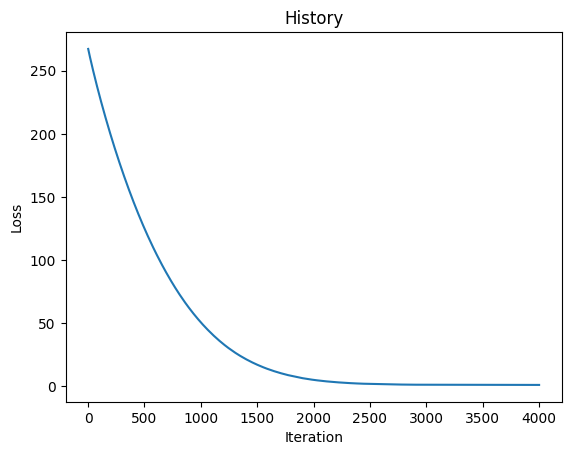

In [769]:
clf.plot_history()                    # Plot loss over time

In [781]:
thres = 0.001

In [782]:
torch.sum(abs(clf.w) <= thres, dim = 0)

tensor(31332, device='cuda:0')

In [783]:
for i in range(clf.w.shape[0]):
    if abs(clf.w[i]) >= thres:
        print(id_to_token[i])

<0x8B>
<0xA0>
ur
te
od
▁le
our
ens
ont
ma
item
▁get
▁au
▁▁▁▁▁▁▁▁▁▁▁▁▁
ement
ual
▁try
▁same
ep
▁sim
raph
▁read
oun
ione
▁log
▁Р
aus
чи
▁link
ender
▁med
$,
uc
▁Ver
▁program
ateg
ouble
▁charact
▁Amer
▁lar
▁able
pen
▁top
****
aint
▁З
outh
▁Sc
ending
off
chen
png
ious
▁See
су
▁wer
aug
▁links
▁bes
▁University
▁Lu
Le
▁Gener
version
Gr
▁ве
iro
▁бо
ky
▁för
▁Janu
iden
sqrt
});
▁Mil
UN
DB
▁King
▁returned
▁guess
ться
Dis
▁\(
▁shown
▁difference
▁Lin
match
append
ным
ских
▁ener
sf
▁Di
▁aver
tex
▁problems
▁Error
born
display
▁`$
▁requ
▁whose
lor
system
mary
▁particip
▁Def
▁Using
▁History
ivil
▁noch
pes
▁repe
Call
▁taking
that
▁WHERE
eds
NAME
▁Instit
bern
support
▁claim
Server
TA
▁Я
then
dp
Vis
IG
▁leur
/.
▁role
▁Cour
organ
▁ps
▁sun
sort
▁rout
▁choose
Down
irk
▁grande
Mode
issions
▁rules
look
▁seconds
Big
nis
asion
PS
▁Ку
That
▁ін
gres
▁zwei
ston
ût
▁async
aupt
etic
▁Source
cut
▁Č
urity
zk
▁deriv
aga
total
argo
mysql
▁FC
{(
enso
▁wire
▁throws
DER
ASE
▁cro
controller
▁Kn
anced
isches
handle
▁oraz
Bo
})

In [795]:
# Check actual error
l1_reconstruction = A @ clf.w

print(torch.norm(l1_reconstruction), torch.dist(l1_reconstruction, y.squeeze(0)), cos(l1_reconstruction, y.squeeze(0)))

# apply threshold
above_threshold = (abs(clf.w) >= thres).float()
l1_thres_w = clf.w * above_threshold
l1_thres = A @ l1_thres_w
print(f"Removed {torch.sum(above_threshold, dim = 0)} / {above_threshold.shape[0]} sparse entries below {thres}")
print(torch.norm(l1_thres), torch.dist(l1_thres, y.squeeze(0)), cos(l1_thres, y.squeeze(0)))


tensor(0.1945, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(62.2702, device='cuda:0', grad_fn=<DistBackward0>) tensor(0.1711, device='cuda:0', grad_fn=<SumBackward1>)
Removed 669.0 / 32001 sparse entries below 0.001
tensor(0.0820, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(62.2847, device='cuda:0', grad_fn=<DistBackward0>) tensor(0.2254, device='cuda:0', grad_fn=<SumBackward1>)


In [755]:
l1_reconstruction = A @ clf.w

In [789]:
l1_reconstruction * (abs(l1_reconstruction) <= thres).float()

tensor([0.0000e+00, -0.0000e+00, 3.2332e-05,  ..., -0.0000e+00, -0.0000e+00,
        -0.0000e+00], device='cuda:0', grad_fn=<MulBackward0>)

In [756]:
torch.norm(l1_reconstruction)

tensor(0.1794, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [492]:
import numpy as np
np.sum(lasso_coefficients >= 0.1, axis = 1)

array([0])

### Reconstruct image embeddings

In [176]:
for ind in range(len(top_tokens)):
    # print(top_tokens[ind][1])
    if "grass" in top_tokens[ind][1]:
        print(ind)

1563


In [415]:
ord(search_tokens[0][0])

9601

In [418]:
chr(9601) + "rain"

'▁rain'

Delete tokens: []
Add tokens: []
Search tokens: {'▁brown'}
Token ▁brown has rank 12 with weight -0.8429262737288571


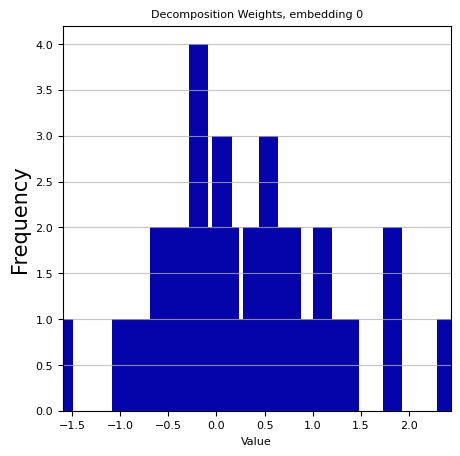

Embedding 0 (dist: 53.522640228271484, reconstructed error: 0.12276230752468109): [(tensor(2.4292, dtype=torch.float64), '.'), (tensor(1.8580, dtype=torch.float64), '▁the'), (tensor(1.8277, dtype=torch.float64), 'ush'), (tensor(-1.5922, dtype=torch.float64), '</s>'), (tensor(1.4054, dtype=torch.float64), '▁both'), (tensor(1.2561, dtype=torch.float64), '▁and'), (tensor(1.2102, dtype=torch.float64), '▁in'), (tensor(1.1312, dtype=torch.float64), '▁for'), (tensor(1.1249, dtype=torch.float64), ','), (tensor(1.0530, dtype=torch.float64), '▁a')]
Token ▁brown has rank 19 with weight -0.6985918374420995


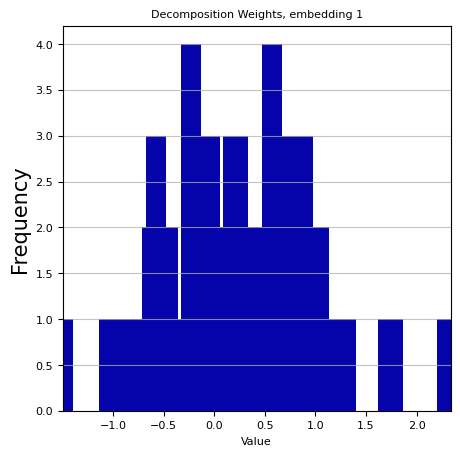

Embedding 1 (dist: 53.91433334350586, reconstructed error: 0.12139637768268585): [(tensor(2.3358, dtype=torch.float64), '.'), (tensor(1.7723, dtype=torch.float64), 'ush'), (tensor(1.7498, dtype=torch.float64), '▁the'), (tensor(-1.4941, dtype=torch.float64), '</s>'), (tensor(1.3400, dtype=torch.float64), '▁both'), (tensor(1.1692, dtype=torch.float64), '▁for'), (tensor(1.0690, dtype=torch.float64), '▁and'), (tensor(1.0469, dtype=torch.float64), '▁in'), (tensor(-1.0296, dtype=torch.float64), '▁Both'), (tensor(0.9936, dtype=torch.float64), '▁a')]
Token ▁brown has rank 12 with weight -0.8926845524455775


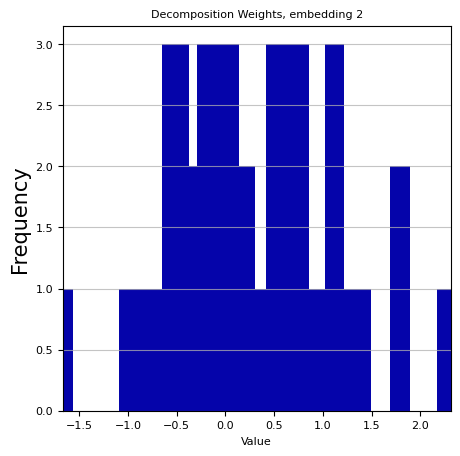

Embedding 2 (dist: 53.798954010009766, reconstructed error: 0.12315703928470612): [(tensor(2.3110, dtype=torch.float64), '.'), (tensor(1.7996, dtype=torch.float64), 'ush'), (tensor(1.7965, dtype=torch.float64), '▁the'), (tensor(-1.6659, dtype=torch.float64), '</s>'), (tensor(1.4162, dtype=torch.float64), '▁both'), (tensor(1.1990, dtype=torch.float64), '▁in'), (tensor(1.1557, dtype=torch.float64), '▁and'), (tensor(1.1403, dtype=torch.float64), '▁for'), (tensor(1.1361, dtype=torch.float64), ','), (tensor(1.0914, dtype=torch.float64), '▁a')]
Token ▁brown has rank 16 with weight -0.7980522552711343


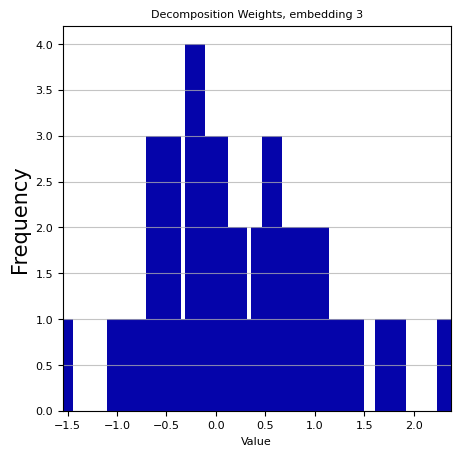

Embedding 3 (dist: 54.32487869262695, reconstructed error: 0.12049871683120728): [(tensor(2.3733, dtype=torch.float64), '.'), (tensor(1.8350, dtype=torch.float64), 'ush'), (tensor(1.7406, dtype=torch.float64), '▁the'), (tensor(-1.5464, dtype=torch.float64), '</s>'), (tensor(1.4118, dtype=torch.float64), '▁both'), (tensor(1.2880, dtype=torch.float64), '▁and'), (tensor(1.1225, dtype=torch.float64), ','), (tensor(1.0548, dtype=torch.float64), '▁in'), (tensor(1.0475, dtype=torch.float64), '▁for'), (tensor(1.0301, dtype=torch.float64), '▁a')]
Token ▁brown has rank 21 with weight 0.5401215449955624


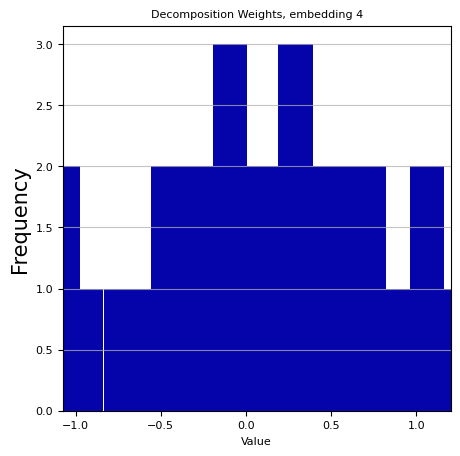

Embedding 4 (dist: 47.691314697265625, reconstructed error: 0.12432581186294556): [(tensor(1.2013, dtype=torch.float64), 'ush'), (tensor(1.0806, dtype=torch.float64), '▁a'), (tensor(-1.0735, dtype=torch.float64), '▁the'), (tensor(1.0655, dtype=torch.float64), '▁hel'), (tensor(-1.0565, dtype=torch.float64), ','), (tensor(1.0400, dtype=torch.float64), 'aring'), (tensor(-1.0168, dtype=torch.float64), '</s>'), (tensor(-0.9604, dtype=torch.float64), '▁The'), (tensor(-0.9197, dtype=torch.float64), '▁and'), (tensor(0.8607, dtype=torch.float64), '▁dep')]
Token ▁brown has rank 31 with weight 0.6539858526131382


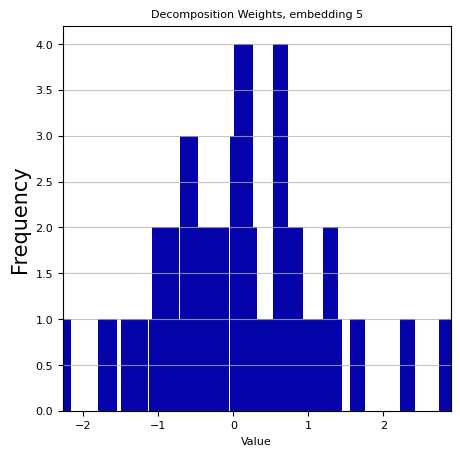

Embedding 5 (dist: 65.07929992675781, reconstructed error: 0.12861664593219757): [(tensor(2.8947, dtype=torch.float64), ','), (tensor(2.3658, dtype=torch.float64), '▁of'), (tensor(-2.2724, dtype=torch.float64), '.'), (tensor(-1.6868, dtype=torch.float64), '▁in'), (tensor(1.6618, dtype=torch.float64), '▁There'), (tensor(-1.6185, dtype=torch.float64), 's'), (tensor(1.3583, dtype=torch.float64), '▁scattered'), (tensor(-1.3545, dtype=torch.float64), '▁and'), (tensor(1.3361, dtype=torch.float64), '▁The'), (tensor(1.3122, dtype=torch.float64), '▁two')]
Token ▁brown has rank 39 with weight -0.3278163533190685


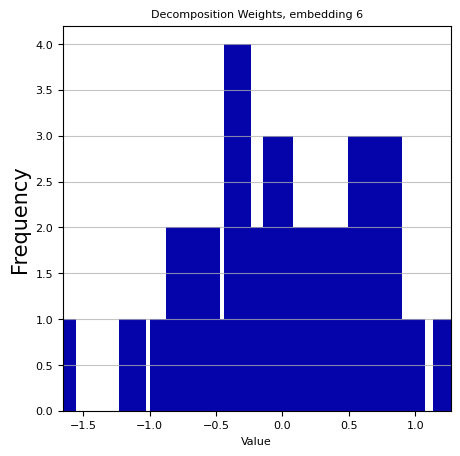

Embedding 6 (dist: 54.869815826416016, reconstructed error: 0.1087518185377121): [(tensor(-1.6508, dtype=torch.float64), '▁Both'), (tensor(1.2655, dtype=torch.float64), 'ush'), (tensor(-1.1050, dtype=torch.float64), '▁we'), (tensor(0.9936, dtype=torch.float64), '▁person'), (tensor(-0.8749, dtype=torch.float64), 'met'), (tensor(0.8453, dtype=torch.float64), '▁r'), (tensor(0.8188, dtype=torch.float64), '▁visible'), (tensor(0.8027, dtype=torch.float64), '▁green'), (tensor(0.8009, dtype=torch.float64), '▁both'), (tensor(-0.7588, dtype=torch.float64), '▁l')]
Token ▁brown has rank 52 with weight -0.18575104795413777


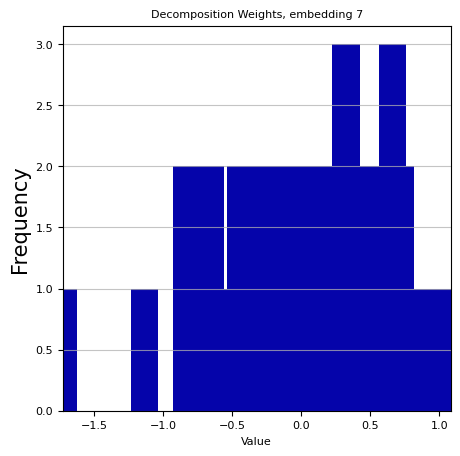

Embedding 7 (dist: 54.00067138671875, reconstructed error: 0.11091221868991852): [(tensor(-1.7239, dtype=torch.float64), '▁Both'), (tensor(-1.1280, dtype=torch.float64), '▁we'), (tensor(1.0809, dtype=torch.float64), 'ush'), (tensor(0.9996, dtype=torch.float64), '▁person'), (tensor(0.8840, dtype=torch.float64), '▁r'), (tensor(0.8153, dtype=torch.float64), '▁green'), (tensor(-0.8119, dtype=torch.float64), 'met'), (tensor(-0.8007, dtype=torch.float64), ','), (tensor(-0.7376, dtype=torch.float64), '▁l'), (tensor(0.7332, dtype=torch.float64), '▁image')]
Token ▁brown has rank 41 with weight 0.337235378420499


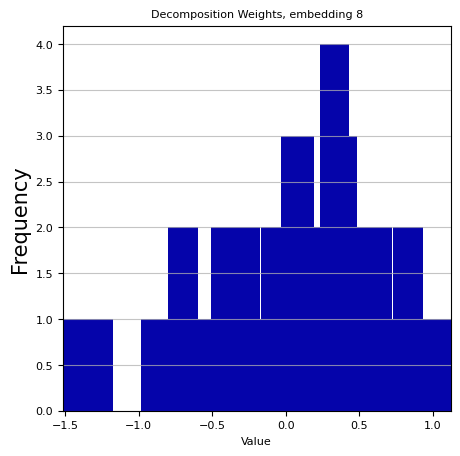

Embedding 8 (dist: 52.726768493652344, reconstructed error: 0.12242867052555084): [(tensor(-1.5136, dtype=torch.float64), '▁Both'), (tensor(-1.3903, dtype=torch.float64), '▁and'), (tensor(-1.2708, dtype=torch.float64), '▁in'), (tensor(1.1208, dtype=torch.float64), '▁person'), (tensor(1.0183, dtype=torch.float64), '▁of'), (tensor(0.9637, dtype=torch.float64), '▁In'), (tensor(0.9479, dtype=torch.float64), '▁man'), (tensor(-0.8674, dtype=torch.float64), '▁we'), (tensor(0.8573, dtype=torch.float64), 'ush'), (tensor(0.8368, dtype=torch.float64), '▁image')]
Token ▁brown has rank 38 with weight 0.3021846778061364


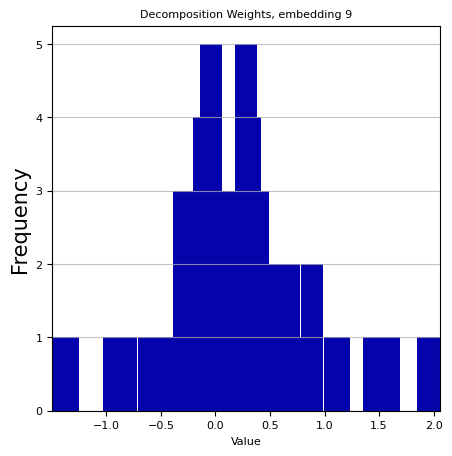

Embedding 9 (dist: 38.7083740234375, reconstructed error: 0.15024062991142273): [(tensor(2.0575, dtype=torch.float64), ','), (tensor(1.9747, dtype=torch.float64), '.'), (tensor(1.6136, dtype=torch.float64), '▁a'), (tensor(-1.4953, dtype=torch.float64), '▁and'), (tensor(1.4617, dtype=torch.float64), '▁of'), (tensor(-1.3337, dtype=torch.float64), '▁Both'), (tensor(1.1607, dtype=torch.float64), '</s>'), (tensor(1.1049, dtype=torch.float64), '▁There'), (tensor(0.9054, dtype=torch.float64), 'ed'), (tensor(-0.9040, dtype=torch.float64), '▁there')]
Token ▁brown has rank 38 with weight 0.30218560992554694


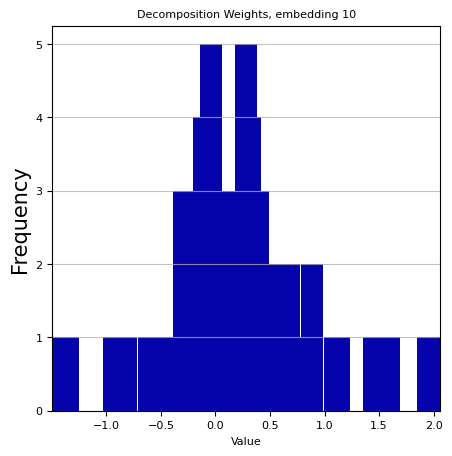

Embedding 10 (dist: 38.70836639404297, reconstructed error: 0.15024101734161377): [(tensor(2.0575, dtype=torch.float64), ','), (tensor(1.9748, dtype=torch.float64), '.'), (tensor(1.6136, dtype=torch.float64), '▁a'), (tensor(-1.4953, dtype=torch.float64), '▁and'), (tensor(1.4617, dtype=torch.float64), '▁of'), (tensor(-1.3337, dtype=torch.float64), '▁Both'), (tensor(1.1607, dtype=torch.float64), '</s>'), (tensor(1.1049, dtype=torch.float64), '▁There'), (tensor(0.9054, dtype=torch.float64), 'ed'), (tensor(-0.9040, dtype=torch.float64), '▁there')]
Token ▁brown has rank 0 with weight 2.2774915215226623


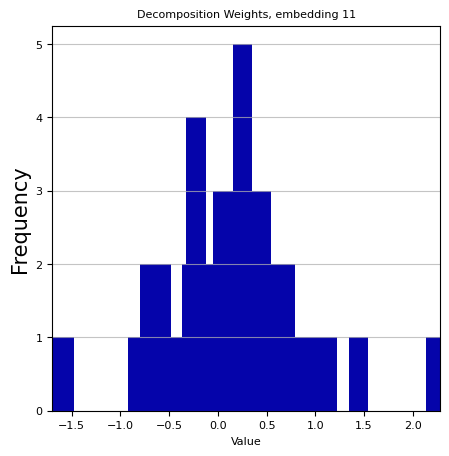

Embedding 11 (dist: 45.08803939819336, reconstructed error: 0.15085884928703308): [(tensor(2.2775, dtype=torch.float64), '▁brown'), (tensor(-1.6985, dtype=torch.float64), '▁The'), (tensor(-1.6497, dtype=torch.float64), '▁and'), (tensor(-1.5427, dtype=torch.float64), '▁in'), (tensor(1.4627, dtype=torch.float64), '▁In'), (tensor(1.1401, dtype=torch.float64), '▁horse'), (tensor(1.0486, dtype=torch.float64), '▁on'), (tensor(0.8990, dtype=torch.float64), '▁of'), (tensor(-0.8073, dtype=torch.float64), '</s>'), (tensor(0.7126, dtype=torch.float64), '▁sh')]
Token ▁brown has rank 16 with weight 0.5725089140380107


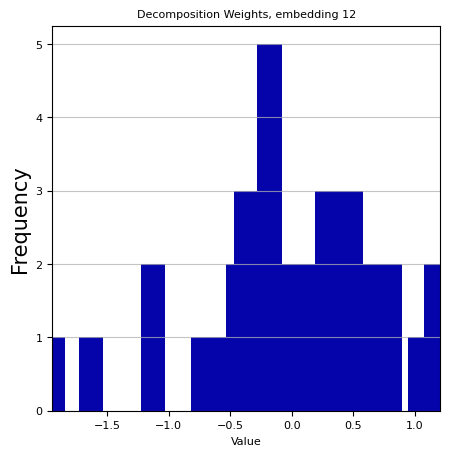

Embedding 12 (dist: 44.4221076965332, reconstructed error: 0.13100668787956238): [(tensor(-1.9468, dtype=torch.float64), '▁the'), (tensor(-1.6122, dtype=torch.float64), '▁and'), (tensor(1.2054, dtype=torch.float64), '▁hel'), (tensor(1.1782, dtype=torch.float64), '▁dep'), (tensor(-1.1143, dtype=torch.float64), '</s>'), (tensor(-1.0987, dtype=torch.float64), '▁There'), (tensor(1.0599, dtype=torch.float64), '▁a'), (tensor(0.8160, dtype=torch.float64), 'ict'), (tensor(0.8089, dtype=torch.float64), '▁of'), (tensor(0.7841, dtype=torch.float64), '▁there')]
Token ▁brown has rank 46 with weight 0.2354862846301139


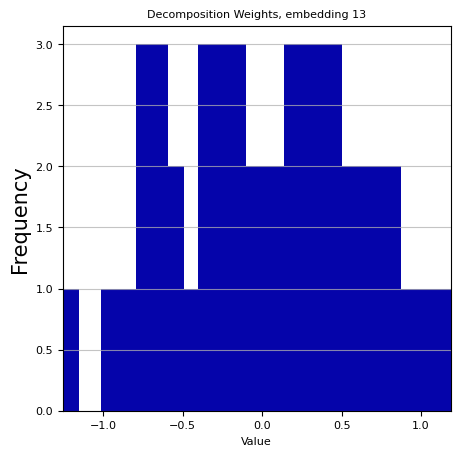

Embedding 13 (dist: 45.26803207397461, reconstructed error: 0.1300370991230011): [(tensor(-1.2528, dtype=torch.float64), '▁and'), (tensor(1.1853, dtype=torch.float64), '▁dep'), (tensor(1.0334, dtype=torch.float64), 'aring'), (tensor(0.9182, dtype=torch.float64), '▁man'), (tensor(0.9153, dtype=torch.float64), 'ush'), (tensor(-0.8880, dtype=torch.float64), '</s>'), (tensor(-0.8837, dtype=torch.float64), ','), (tensor(0.8353, dtype=torch.float64), '▁green'), (tensor(0.7823, dtype=torch.float64), '▁r'), (tensor(0.7790, dtype=torch.float64), '▁trees')]
Token ▁brown has rank 2 with weight 1.4642390702561856


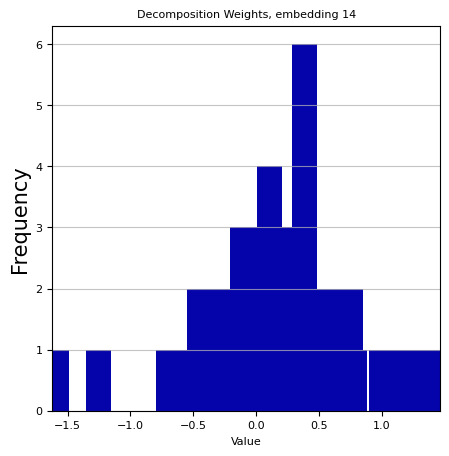

Embedding 14 (dist: 41.093589782714844, reconstructed error: 0.14356589317321777): [(tensor(-1.6203, dtype=torch.float64), '▁in'), (tensor(-1.5890, dtype=torch.float64), '▁and'), (tensor(1.4642, dtype=torch.float64), '▁brown'), (tensor(1.3177, dtype=torch.float64), '▁on'), (tensor(-1.2435, dtype=torch.float64), '▁The'), (tensor(1.2128, dtype=torch.float64), '▁horse'), (tensor(1.0276, dtype=torch.float64), '▁In'), (tensor(0.8014, dtype=torch.float64), ','), (tensor(0.7565, dtype=torch.float64), '▁man'), (tensor(0.7554, dtype=torch.float64), 'aring')]
Token ▁brown has rank 2 with weight 1.1538154466697188


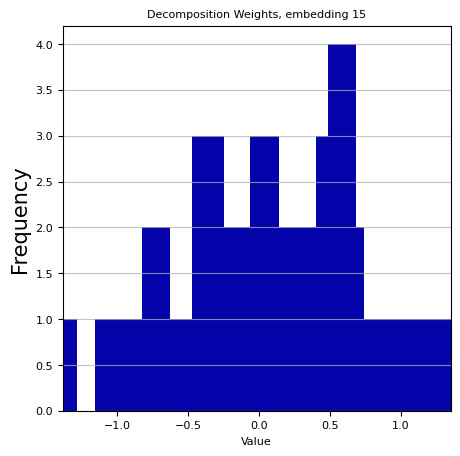

Embedding 15 (dist: 46.45857238769531, reconstructed error: 0.1365213245153427): [(tensor(-1.3829, dtype=torch.float64), '▁in'), (tensor(1.3520, dtype=torch.float64), '▁trees'), (tensor(1.1538, dtype=torch.float64), '▁brown'), (tensor(1.1137, dtype=torch.float64), 'ush'), (tensor(1.0587, dtype=torch.float64), '▁located'), (tensor(-1.0452, dtype=torch.float64), '▁The'), (tensor(0.9927, dtype=torch.float64), '▁In'), (tensor(-0.9110, dtype=torch.float64), '</s>'), (tensor(0.8686, dtype=torch.float64), '▁be'), (tensor(0.8372, dtype=torch.float64), '▁both')]
Token ▁brown has rank 0 with weight 2.2164496064727235


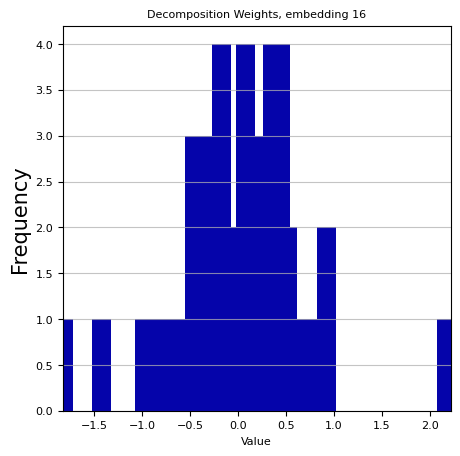

Embedding 16 (dist: 44.74558639526367, reconstructed error: 0.1415882259607315): [(tensor(2.2164, dtype=torch.float64), '▁brown'), (tensor(-1.8278, dtype=torch.float64), '▁and'), (tensor(-1.4179, dtype=torch.float64), '▁The'), (tensor(0.9544, dtype=torch.float64), '▁In'), (tensor(0.9452, dtype=torch.float64), '▁be'), (tensor(-0.9451, dtype=torch.float64), '▁the'), (tensor(0.8734, dtype=torch.float64), '▁horse'), (tensor(-0.8090, dtype=torch.float64), '▁in'), (tensor(0.7904, dtype=torch.float64), '▁person'), (tensor(0.7408, dtype=torch.float64), '▁sh')]
Token ▁brown has rank 27 with weight 0.4636172130286589


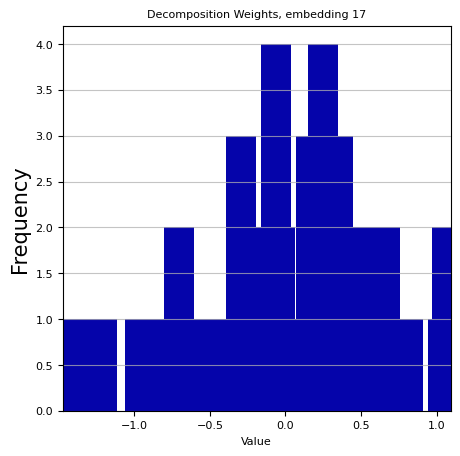

Embedding 17 (dist: 45.92485046386719, reconstructed error: 0.12679439783096313): [(tensor(-1.4718, dtype=torch.float64), '▁and'), (tensor(-1.2931, dtype=torch.float64), '</s>'), (tensor(-1.2094, dtype=torch.float64), '▁the'), (tensor(1.0919, dtype=torch.float64), 'aring'), (tensor(1.0683, dtype=torch.float64), '▁dep'), (tensor(1.0616, dtype=torch.float64), '▁In'), (tensor(-0.9531, dtype=torch.float64), '▁There'), (tensor(-0.8930, dtype=torch.float64), '▁The'), (tensor(-0.8502, dtype=torch.float64), '.'), (tensor(0.8101, dtype=torch.float64), '▁r')]
Token ▁brown has rank 0 with weight 1.3200998530261234


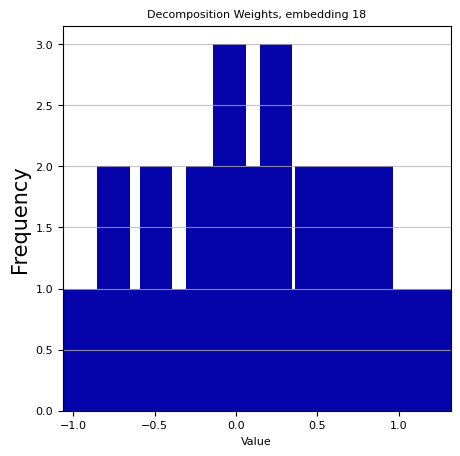

Embedding 18 (dist: 46.53938293457031, reconstructed error: 0.12741921842098236): [(tensor(1.3201, dtype=torch.float64), '▁brown'), (tensor(1.2170, dtype=torch.float64), '▁trees'), (tensor(-1.0641, dtype=torch.float64), ','), (tensor(1.0269, dtype=torch.float64), '▁dep'), (tensor(0.9533, dtype=torch.float64), 'aring'), (tensor(-0.8827, dtype=torch.float64), '▁The'), (tensor(0.8787, dtype=torch.float64), 'ush'), (tensor(0.8747, dtype=torch.float64), '▁two'), (tensor(-0.8704, dtype=torch.float64), '▁to'), (tensor(0.8400, dtype=torch.float64), '▁obser')]
Token ▁brown has rank 8 with weight 1.021484840196531


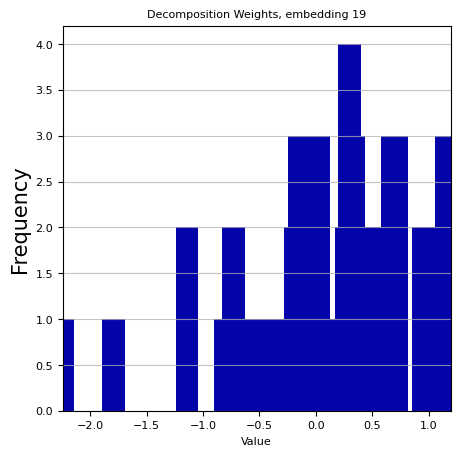

Embedding 19 (dist: 44.47457504272461, reconstructed error: 0.1513495147228241): [(tensor(-2.2397, dtype=torch.float64), '▁in'), (tensor(-1.7754, dtype=torch.float64), '▁the'), (tensor(1.1929, dtype=torch.float64), '▁of'), (tensor(1.1872, dtype=torch.float64), '▁In'), (tensor(1.1626, dtype=torch.float64), '▁horse'), (tensor(-1.1361, dtype=torch.float64), 's'), (tensor(-1.1164, dtype=torch.float64), '▁and'), (tensor(1.0314, dtype=torch.float64), '▁trees'), (tensor(1.0215, dtype=torch.float64), '▁brown'), (tensor(0.9620, dtype=torch.float64), '▁seem')]
Token ▁brown has rank 11 with weight 0.7308981790467545


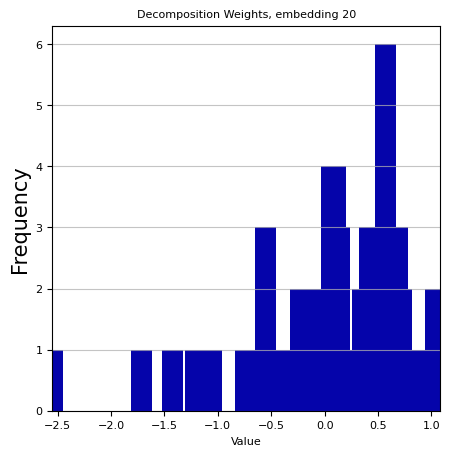

Embedding 20 (dist: 44.373233795166016, reconstructed error: 0.1428191214799881): [(tensor(-2.5497, dtype=torch.float64), '▁the'), (tensor(-1.6812, dtype=torch.float64), '▁and'), (tensor(-1.3935, dtype=torch.float64), '</s>'), (tensor(-1.1927, dtype=torch.float64), '▁in'), (tensor(1.0803, dtype=torch.float64), '▁hel'), (tensor(1.0642, dtype=torch.float64), '▁on'), (tensor(-1.0627, dtype=torch.float64), '▁There'), (tensor(-1.0454, dtype=torch.float64), '▁to'), (tensor(1.0133, dtype=torch.float64), '▁dep'), (tensor(0.8357, dtype=torch.float64), '▁a')]
Token ▁brown has rank 13 with weight 0.5339383490018865


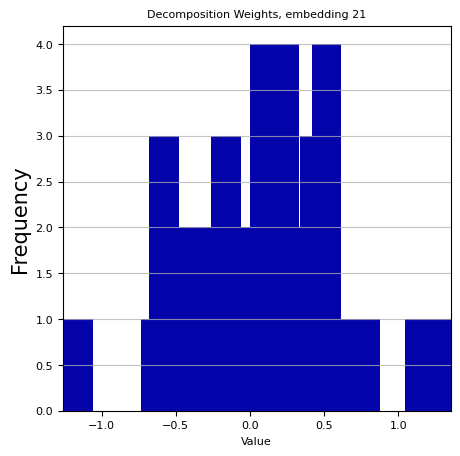

Embedding 21 (dist: 38.048187255859375, reconstructed error: 0.13296212255954742): [(tensor(1.3519, dtype=torch.float64), '▁on'), (tensor(-1.2597, dtype=torch.float64), '▁in'), (tensor(1.1540, dtype=torch.float64), '▁horse'), (tensor(-1.1523, dtype=torch.float64), '▁and'), (tensor(0.7883, dtype=torch.float64), '▁a'), (tensor(0.7041, dtype=torch.float64), '▁man'), (tensor(0.6861, dtype=torch.float64), 'aring'), (tensor(-0.6180, dtype=torch.float64), '▁the'), (tensor(-0.5990, dtype=torch.float64), '▁several'), (tensor(-0.5646, dtype=torch.float64), '▁The')]
Token ▁brown has rank 0 with weight 1.4538262257826866


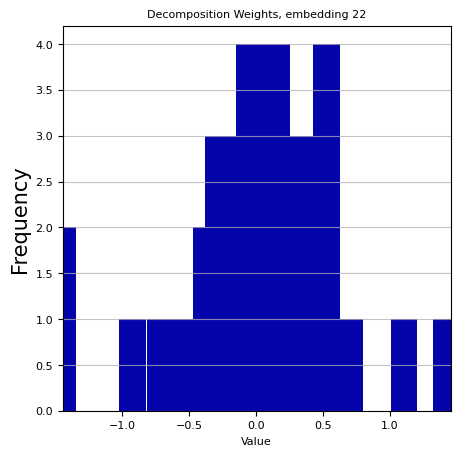

Embedding 22 (dist: 39.24245834350586, reconstructed error: 0.1351689100265503): [(tensor(1.4538, dtype=torch.float64), '▁brown'), (tensor(-1.4426, dtype=torch.float64), '▁and'), (tensor(-1.4368, dtype=torch.float64), '▁The'), (tensor(1.1080, dtype=torch.float64), '▁horse'), (tensor(-0.9076, dtype=torch.float64), '▁in'), (tensor(-0.7129, dtype=torch.float64), '▁scattered'), (tensor(0.7028, dtype=torch.float64), '▁a'), (tensor(0.6847, dtype=torch.float64), '▁process'), (tensor(-0.6761, dtype=torch.float64), '▁There'), (tensor(0.6059, dtype=torch.float64), 'aring')]
Token ▁brown has rank 38 with weight 0.30218510129132803


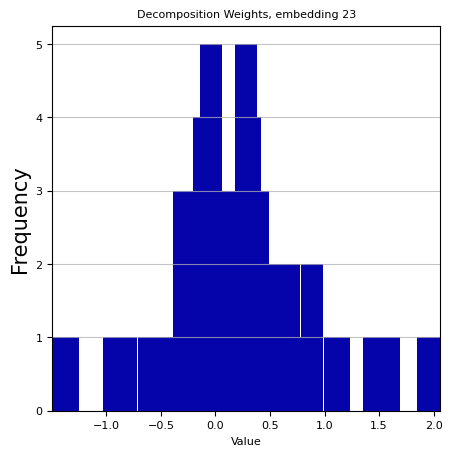

Embedding 23 (dist: 38.70836639404297, reconstructed error: 0.15024130046367645): [(tensor(2.0575, dtype=torch.float64), ','), (tensor(1.9748, dtype=torch.float64), '.'), (tensor(1.6136, dtype=torch.float64), '▁a'), (tensor(-1.4953, dtype=torch.float64), '▁and'), (tensor(1.4617, dtype=torch.float64), '▁of'), (tensor(-1.3337, dtype=torch.float64), '▁Both'), (tensor(1.1607, dtype=torch.float64), '</s>'), (tensor(1.1049, dtype=torch.float64), '▁There'), (tensor(0.9054, dtype=torch.float64), 'ed'), (tensor(-0.9040, dtype=torch.float64), '▁there')]
Token ▁brown has rank 23 with weight 0.5718976093887393


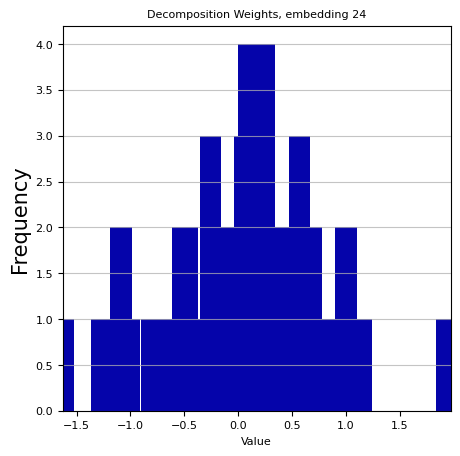

Embedding 24 (dist: 47.467838287353516, reconstructed error: 0.1519773006439209): [(tensor(1.9703, dtype=torch.float64), '▁trees'), (tensor(-1.6259, dtype=torch.float64), '▁the'), (tensor(-1.2381, dtype=torch.float64), '▁to'), (tensor(-1.1623, dtype=torch.float64), '▁and'), (tensor(1.1435, dtype=torch.float64), '▁man'), (tensor(-1.1122, dtype=torch.float64), '▁in'), (tensor(1.1117, dtype=torch.float64), '▁seem'), (tensor(-1.0626, dtype=torch.float64), '</s>'), (tensor(-1.0556, dtype=torch.float64), '.'), (tensor(-1.0470, dtype=torch.float64), '▁The')]
Token ▁brown has rank 4 with weight 1.0558831315849706


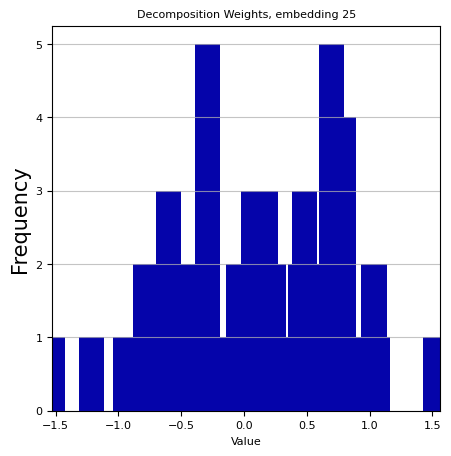

Embedding 25 (dist: 46.488712310791016, reconstructed error: 0.147394061088562): [(tensor(1.5605, dtype=torch.float64), '▁trees'), (tensor(-1.5252, dtype=torch.float64), '▁in'), (tensor(-1.1885, dtype=torch.float64), '</s>'), (tensor(1.0854, dtype=torch.float64), '▁located'), (tensor(1.0559, dtype=torch.float64), '▁brown'), (tensor(1.0512, dtype=torch.float64), '▁In'), (tensor(0.9936, dtype=torch.float64), '▁field'), (tensor(0.9679, dtype=torch.float64), '▁of'), (tensor(-0.9249, dtype=torch.float64), '▁The'), (tensor(0.8274, dtype=torch.float64), '▁two')]
Token ▁brown has rank 67 with weight 0.012067888749317744


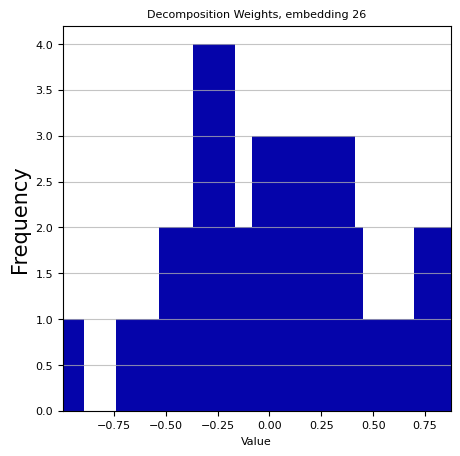

Embedding 26 (dist: 39.37685775756836, reconstructed error: 0.10217051953077316): [(tensor(-0.9963, dtype=torch.float64), 's'), (tensor(0.8738, dtype=torch.float64), '▁of'), (tensor(0.8534, dtype=torch.float64), '▁visible'), (tensor(0.8355, dtype=torch.float64), 'ush'), (tensor(0.8147, dtype=torch.float64), '</s>'), (tensor(0.8123, dtype=torch.float64), '▁the'), (tensor(0.6928, dtype=torch.float64), '▁located'), (tensor(-0.6271, dtype=torch.float64), '▁obser'), (tensor(-0.6154, dtype=torch.float64), '▁One'), (tensor(0.5710, dtype=torch.float64), '▁scene')]
Token ▁brown has rank 62 with weight 0.06868795248690834


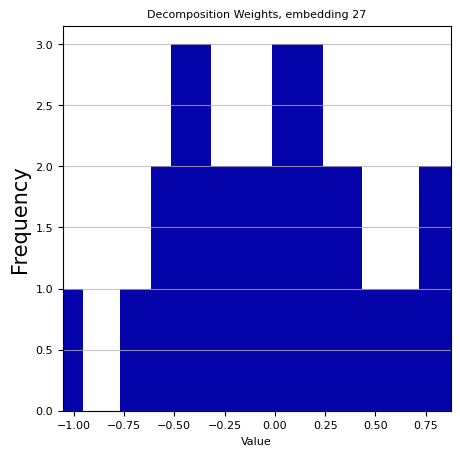

Embedding 27 (dist: 38.97012710571289, reconstructed error: 0.10446502268314362): [(tensor(-1.0527, dtype=torch.float64), 's'), (tensor(0.8730, dtype=torch.float64), '▁visible'), (tensor(0.8663, dtype=torch.float64), 'ush'), (tensor(0.8285, dtype=torch.float64), '▁of'), (tensor(0.8158, dtype=torch.float64), '▁the'), (tensor(0.7705, dtype=torch.float64), '</s>'), (tensor(0.6664, dtype=torch.float64), '▁located'), (tensor(-0.6575, dtype=torch.float64), '▁and'), (tensor(-0.6136, dtype=torch.float64), '▁One'), (tensor(-0.5886, dtype=torch.float64), '▁obser')]
Token ▁brown has rank 29 with weight 0.4399052502547887


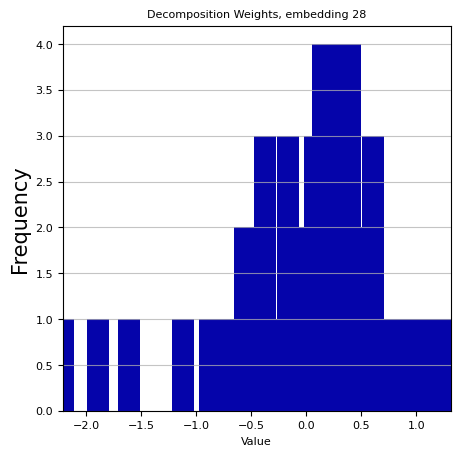

Embedding 28 (dist: 48.730125427246094, reconstructed error: 0.1440276801586151): [(tensor(-2.2101, dtype=torch.float64), '▁and'), (tensor(-1.8855, dtype=torch.float64), '▁the'), (tensor(-1.5831, dtype=torch.float64), '</s>'), (tensor(1.3104, dtype=torch.float64), '▁dep'), (tensor(1.2554, dtype=torch.float64), '▁man'), (tensor(1.1141, dtype=torch.float64), '▁of'), (tensor(-1.0906, dtype=torch.float64), '▁in'), (tensor(0.9868, dtype=torch.float64), '▁people'), (tensor(0.9353, dtype=torch.float64), '▁for'), (tensor(0.9063, dtype=torch.float64), '▁obser')]
Token ▁brown has rank 7 with weight 0.8610231947026804


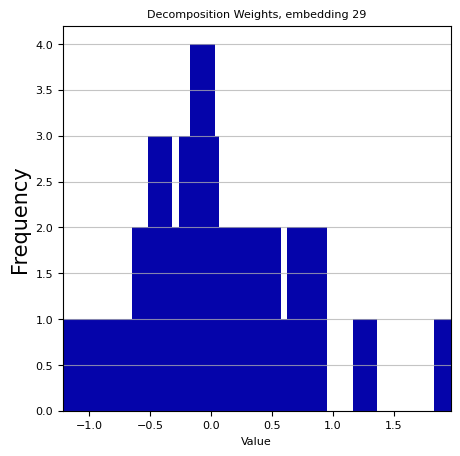

Embedding 29 (dist: 46.25642395019531, reconstructed error: 0.13008058071136475): [(tensor(1.9682, dtype=torch.float64), '▁trees'), (tensor(1.2788, dtype=torch.float64), 'ush'), (tensor(-1.2162, dtype=torch.float64), ','), (tensor(-1.1677, dtype=torch.float64), '▁in'), (tensor(-0.9777, dtype=torch.float64), '▁to'), (tensor(-0.9459, dtype=torch.float64), '▁The'), (tensor(0.8728, dtype=torch.float64), '▁is'), (tensor(0.8610, dtype=torch.float64), '▁brown'), (tensor(-0.8299, dtype=torch.float64), '.'), (tensor(0.8079, dtype=torch.float64), '▁two')]
Token ▁brown has rank 4 with weight 1.1536643421895476


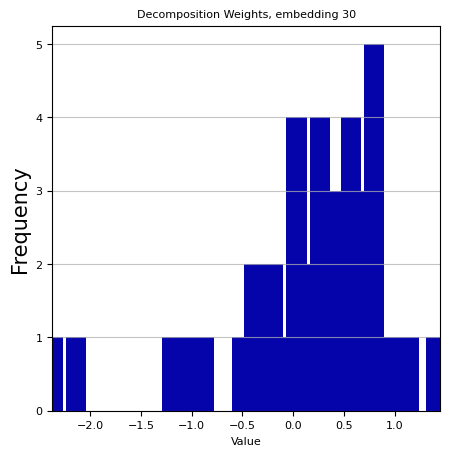

Embedding 30 (dist: 46.71310806274414, reconstructed error: 0.1540983021259308): [(tensor(-2.3752, dtype=torch.float64), '▁the'), (tensor(-2.1308, dtype=torch.float64), '▁in'), (tensor(1.4479, dtype=torch.float64), '▁of'), (tensor(-1.1644, dtype=torch.float64), '▁and'), (tensor(1.1537, dtype=torch.float64), '▁brown'), (tensor(-1.1013, dtype=torch.float64), 's'), (tensor(-1.0176, dtype=torch.float64), '</s>'), (tensor(1.0108, dtype=torch.float64), ','), (tensor(0.9197, dtype=torch.float64), '▁on'), (tensor(0.9058, dtype=torch.float64), '▁In')]
Token ▁brown has rank 42 with weight -0.18777367941417758


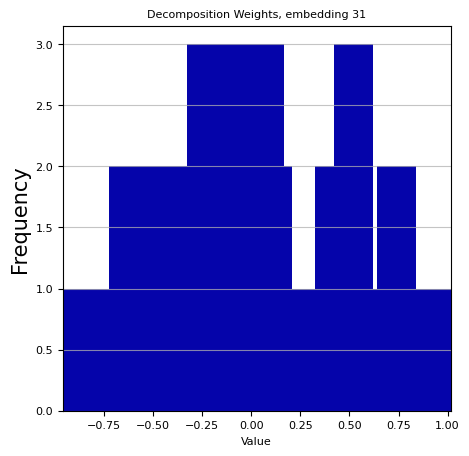

Embedding 31 (dist: 42.5162239074707, reconstructed error: 0.10291251540184021): [(tensor(1.0150, dtype=torch.float64), '▁of'), (tensor(-0.9591, dtype=torch.float64), '.'), (tensor(0.9404, dtype=torch.float64), '</s>'), (tensor(-0.8306, dtype=torch.float64), 's'), (tensor(-0.8117, dtype=torch.float64), '▁people'), (tensor(0.7724, dtype=torch.float64), '▁located'), (tensor(0.7526, dtype=torch.float64), '▁visible'), (tensor(0.7518, dtype=torch.float64), 'ush'), (tensor(-0.7165, dtype=torch.float64), '▁obser'), (tensor(0.6677, dtype=torch.float64), '▁seem')]
Token ▁brown has rank 17 with weight 1.9625959860851165e-17


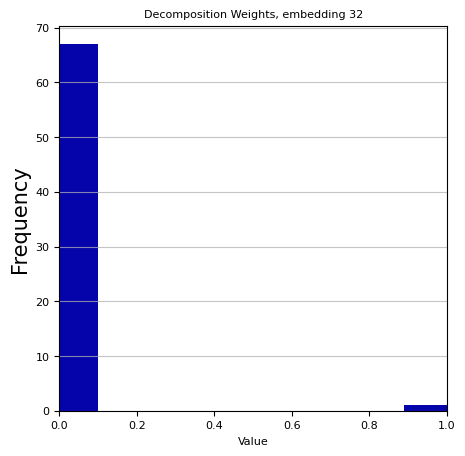

Embedding 32 (dist: 0.0, reconstructed error: 1.0): [(tensor(1.0000, dtype=torch.float64), '</s>'), (tensor(-1.1442e-16, dtype=torch.float64), '.'), (tensor(6.8192e-17, dtype=torch.float64), ','), (tensor(5.2914e-17, dtype=torch.float64), '▁the'), (tensor(4.4091e-17, dtype=torch.float64), '▁for'), (tensor(-4.2374e-17, dtype=torch.float64), '▁in'), (tensor(3.9701e-17, dtype=torch.float64), '▁person'), (tensor(3.2392e-17, dtype=torch.float64), '▁of'), (tensor(-2.7180e-17, dtype=torch.float64), '▁The'), (tensor(2.6286e-17, dtype=torch.float64), '▁obser')]
Token ▁brown has rank 31 with weight 0.020386709972613888


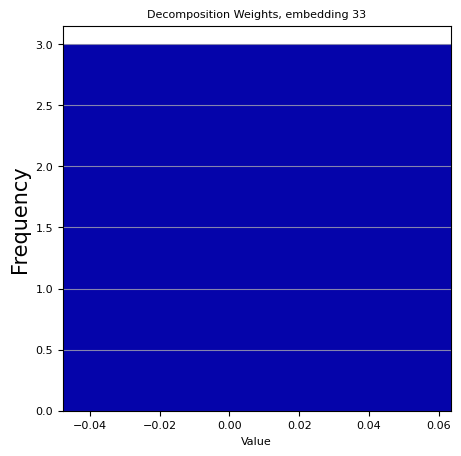

Embedding 33 (dist: 1.420447826385498, reconstructed error: 0.19715875387191772): [(tensor(0.0633, dtype=torch.float64), '▁obser'), (tensor(0.0503, dtype=torch.float64), '▁Both'), (tensor(0.0480, dtype=torch.float64), '▁In'), (tensor(-0.0477, dtype=torch.float64), '▁individuals'), (tensor(0.0449, dtype=torch.float64), '.'), (tensor(0.0442, dtype=torch.float64), '▁image'), (tensor(-0.0428, dtype=torch.float64), '▁dep'), (tensor(0.0420, dtype=torch.float64), '▁while'), (tensor(0.0403, dtype=torch.float64), '</s>'), (tensor(-0.0403, dtype=torch.float64), 'ed')]
Token ▁brown has rank 19 with weight 1.7974290170956417e-17


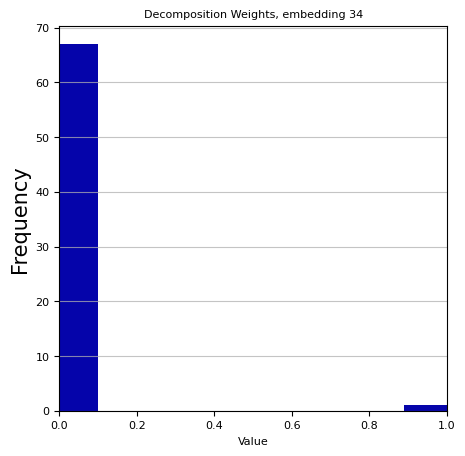

Embedding 34 (dist: 0.0, reconstructed error: 1.0): [(tensor(1.0000, dtype=torch.float64), '▁a'), (tensor(-1.4593e-16, dtype=torch.float64), '▁in'), (tensor(-1.2561e-16, dtype=torch.float64), '.'), (tensor(-8.8937e-17, dtype=torch.float64), '▁for'), (tensor(-6.0630e-17, dtype=torch.float64), ','), (tensor(-5.3387e-17, dtype=torch.float64), '▁the'), (tensor(-4.5347e-17, dtype=torch.float64), '▁on'), (tensor(3.4901e-17, dtype=torch.float64), '▁of'), (tensor(2.8441e-17, dtype=torch.float64), 'ed'), (tensor(2.6859e-17, dtype=torch.float64), '</s>')]
Token ▁brown has rank 15 with weight 0.025031841656443916


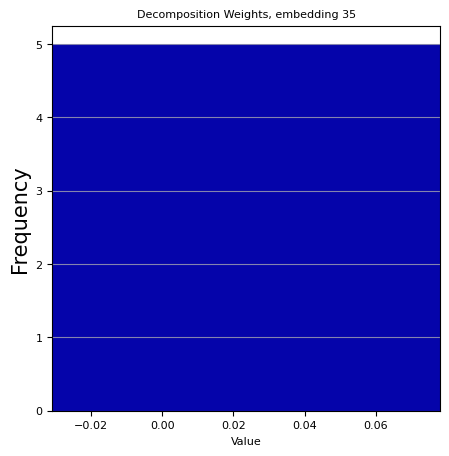

Embedding 35 (dist: 1.4712138175964355, reconstructed error: 0.20893685519695282): [(tensor(0.0781, dtype=torch.float64), '▁scattered'), (tensor(0.0601, dtype=torch.float64), '▁throughout'), (tensor(0.0569, dtype=torch.float64), '▁located'), (tensor(0.0461, dtype=torch.float64), '▁while'), (tensor(0.0453, dtype=torch.float64), '▁dep'), (tensor(0.0418, dtype=torch.float64), '▁appears'), (tensor(0.0367, dtype=torch.float64), '▁obser'), (tensor(0.0347, dtype=torch.float64), '▁green'), (tensor(0.0321, dtype=torch.float64), '▁closer'), (tensor(-0.0310, dtype=torch.float64), '▁man')]
Token ▁brown has rank 12 with weight 0.034172100482895956


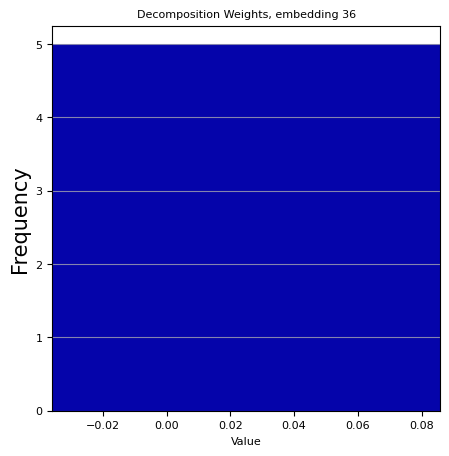

Embedding 36 (dist: 1.4359617233276367, reconstructed error: 0.21955445408821106): [(tensor(0.0858, dtype=torch.float64), '▁image'), (tensor(0.0507, dtype=torch.float64), '▁there'), (tensor(0.0502, dtype=torch.float64), '▁process'), (tensor(0.0495, dtype=torch.float64), '▁providing'), (tensor(0.0427, dtype=torch.float64), '▁scene'), (tensor(0.0411, dtype=torch.float64), '▁addition'), (tensor(0.0407, dtype=torch.float64), '▁throughout'), (tensor(0.0387, dtype=torch.float64), '▁dep'), (tensor(-0.0358, dtype=torch.float64), 'ed'), (tensor(-0.0357, dtype=torch.float64), '▁be')]
Token ▁brown has rank 67 with weight -2.370805856330239e-19


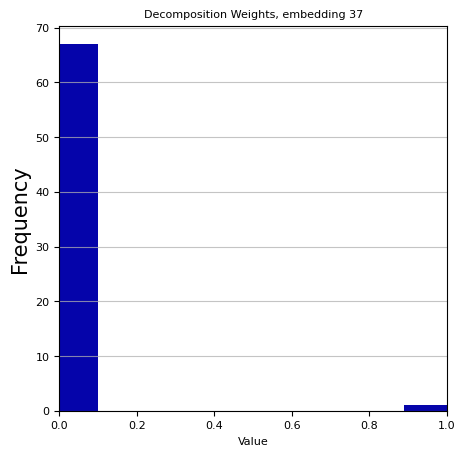

Embedding 37 (dist: 0.0, reconstructed error: 1.0): [(tensor(1.0000, dtype=torch.float64), '.'), (tensor(-1.6375e-16, dtype=torch.float64), '▁the'), (tensor(8.9304e-17, dtype=torch.float64), '▁for'), (tensor(-8.3405e-17, dtype=torch.float64), ','), (tensor(-7.6190e-17, dtype=torch.float64), '▁of'), (tensor(7.1850e-17, dtype=torch.float64), '▁a'), (tensor(5.8661e-17, dtype=torch.float64), '▁The'), (tensor(4.7768e-17, dtype=torch.float64), '▁and'), (tensor(-3.8212e-17, dtype=torch.float64), '▁in'), (tensor(-3.2434e-17, dtype=torch.float64), '▁is')]


In [85]:
# Reconstruct embeddings
reconstruct_embeddings = None
top_k = 2000
delete_factor = 10
add_factor = 6

# Delete tokens
delete_space = []
delete_token_space = seq_to_tokens(delete_space, id_to_token)
print(f"Delete tokens: {delete_token_space}")

# Add tokens
add_space = []
add_token_space = seq_to_tokens(add_space, id_to_token)
print(f"Add tokens: {add_token_space}")

# Search tokens - extract rank + weight
search_space = ["brown"]
search_token_space = set(seq_to_tokens(search_space, id_to_token))
print(f"Search tokens: {search_token_space}")


embedding_indices = []

for i in range(image_embeddings.shape[1]):
    top_tokens = decompositions[i]
    y = image_embeddings[:, i].T.to(torch.float32).to(device)

    # find any tokens we need to add or delete
    delete_tokens = []
    add_tokens = []
    for ind in range(len(top_tokens)):
        for tok in delete_token_space:
            if top_tokens[ind][1] == tok:
                delete_tokens.append(top_tokens[ind][1])
        for tok in add_token_space:
            if top_tokens[ind][1] == tok:
                add_tokens.append(top_tokens[ind][1])
        for tok in search_token_space:
            if top_tokens[ind][1] == tok:
                print(f"Token {tok} has rank {ind} with weight {top_tokens[ind][0]}")
                if ind < 5 and top_tokens[ind][0] > 0:
                    embedding_indices.append(i)
    
    # reconstruct embeddings
    new_embedding = torch.zeros(image_embeddings.shape[2]).unsqueeze(1).to(device)
    selected_input_ids = []
    weights = []
    for j in range(len(top_tokens[:top_k])):
        weight, token = top_tokens[j]
        weights.append(weight)
        selected_input_ids.append(vocabulary[token])
        new_embedding += weight * vocab_embeddings[:, vocabulary[token], :].T
        
    # A = torch.index_select(vocab_embeddings.squeeze(0), 0, torch.tensor(selected_input_ids).to(device))
    # A = A.T.to(torch.float32).to(device)
    # X = torch.linalg.lstsq(A, y).solution
    # new_embedding = A @ X

    # #plot a histogram
    # selected_weights = []
    # for j in range(X.shape[0]):
    #     selected_weights.append(X[j][0].to("cpu")) # using subset of vocabulary
    np_hist = np.array(weights)

    hist,bin_edges = np.histogram(np_hist, bins = 100)
    plt.figure(figsize=[5,5])
    
    plt.bar(bin_edges[:-1], hist, width = 0.2, color='#0504aa',alpha=1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=8)
    plt.ylabel('Frequency',fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel('Frequency',fontsize=15)
    plt.title(f'Decomposition Weights, embedding {i}',fontsize=8)
    plt.show()

    # Subtract out any text embeddings
    for token in delete_tokens:
        print(f"Removing {token}")
        # mult_factor = 2 * remove_factor if token[0] != TOKEN_UNDERSCORE else remove_factor
        new_embedding -= delete_factor * vocab_embeddings[:, vocabulary[token], :].T

    # Add text embeddings
    for token in add_tokens:
        print(f"Adding {token}")
        new_embedding += add_factor * vocab_embeddings[:, vocabulary[token], :].T
    
    if reconstruct_embeddings == None:
        reconstruct_embeddings = new_embedding
    else:
        reconstruct_embeddings = torch.concat([reconstruct_embeddings, new_embedding], dim = 1)

    # calculate cosine similarity
    # we expect new_embedding and y to be of shape (5120, 1)
    cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    print(f"Embedding {i} (dist: {torch.dist(new_embedding, y)}, reconstructed error: {cos(new_embedding.squeeze(1), y.squeeze(1))}): {top_tokens[:10]}")
    print("\n")

In [86]:
embedding_indices

[11, 14, 15, 16, 18, 22, 25, 30]

In [126]:
(A @ X).shape

torch.Size([5120, 1])

In [98]:
reconstruct_embeddings.shape

torch.Size([5120, 38])

In [115]:
test_input = {"image": torch.ones(1).to("cuda"), "prompt": captioner.prompt}
inputs_embeds = image_embeddings[:, :32] - 7 * reconstruct_embeddings.T.unsqueeze(0)[:, :32]
# inputs_embeds = image_embeddings[:, :32, :]
# inputs_embeds[:, 16, :].zero_()
# inputs_embeds[:, 16, :] = vocab_embeddings[:, vocabulary["red"], :]

# inputs_embeds[:, 0, :] = l1_thres.unsqueeze(0)
atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)

In [116]:
out = captioner.model.generate(  # type: ignore
            test_input,
            num_beams=5,
            max_length=200,
            return_embeds=True,
            atts_vision=atts_llm,
            inputs_vision=inputs_embeds, # stick input embeddings from vision here
            # pure_llm = True # meaning only text model used
        )
print(out[0])

['<s> A detailed description is a comprehensive, step-by-step account of a subject or situation, often used in scientific or technical writing or research. The term "detailed" refers to a thorough, comprehensive and complete examination or explanation of a subject or situation, often used in scientific or technical writing or research. The term "detailed" refers to a thorough, comprehensive and detailed examination or explanation of a subject or situation, often used in scientific or technical writing or research. The term "detailed" refers to a thorough, comprehensive and detailed examination or explanation of a subject or situation, often used in scientific or technical writing or research. The term "detailed" refers to a thorough, comprehensive and detailed examination or explanation of a subject or situation, often used in scientific or technical writing or research. The term "detailed" refers to a, comprehensive and detailed examination or explanation of a subject or situation, of

In [122]:
torch.norm(reconstruct_embeddings[:, 10])

tensor(5.8822, device='cuda:0')

In [111]:
torch.randn((1, 10000, 5120)).shape

torch.Size([1, 10000, 5120])

### Synthetic Images

In [73]:
id_to_token = dict()
vocabulary = captioner.tokenizer.get_vocab()
for key in vocabulary:
    id_to_token[vocabulary[key]] = key

In [74]:
top_tokens = []
vocabulary = captioner.tokenizer.get_vocab()
for i in range(X.shape[0]):
    top_tokens.append((X[i][0].to("cpu"), id_to_token[i]))


In [57]:
captioner.tokenizer._convert_id_to_token(0)

'<unk>'

In [76]:
top_tokens.sort(key = lambda e: -torch.abs(e[0]))
top_tokens[:10]

[(tensor(0.8884), 'limp'),
 (tensor(0.8707), '▁aware'),
 (tensor(0.8102), 'Since'),
 (tensor(0.7998), '▁About'),
 (tensor(0.7883), '▁sind'),
 (tensor(0.7777), '▁Entry'),
 (tensor(-0.7633), '▁novel'),
 (tensor(0.7610), '▁More'),
 (tensor(-0.7278), 'oration'),
 (tensor(-0.7260), '▁tools')]

In [33]:
captioner.model.llm_tokenizer._convert_id_to_token(2)

'</s>'

In [27]:
torch.sum(torch.abs(X) < 0.03)

tensor(4597, device='cuda:0')

In [14]:
best_x

tensor([[ 55616.3203],
        [ 70614.2266],
        [-66882.3203],
        ...,
        [-27113.7852],
        [ 19889.7617],
        [-52409.8984]], device='cuda:0')

In [17]:
torch.inverse(A.T @ A)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.82 GiB (GPU 0; 47.51 GiB total capacity; 43.18 GiB already allocated; 351.25 MiB free; 46.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [82]:
torch.dist(A @ X, y)

tensor(8.7643e-07, device='cuda:0')

In [30]:
A.to(torch.float32)

tensor([[ 2.2650e-06,  1.5045e-02, -2.1225e-02,  ..., -9.8495e-03,
          1.3763e-02,  2.0477e-02],
        [ 3.6716e-05, -2.8030e-02,  6.0654e-03,  ..., -6.0806e-03,
         -2.3544e-02, -2.6779e-02],
        [ 6.0701e-04,  1.2549e-01, -4.7638e-02,  ..., -2.5673e-03,
         -1.3855e-02, -1.5244e-02],
        ...,
        [ 4.8399e-04, -1.3054e-02,  3.4065e-03,  ...,  1.5621e-03,
         -1.3908e-02,  1.5549e-02],
        [-9.8169e-05,  1.3742e-03, -4.5395e-03,  ..., -3.6545e-03,
          2.7786e-02, -1.8677e-02],
        [ 3.8338e-04,  6.9008e-03,  2.8400e-03,  ..., -1.1795e-02,
          2.8854e-02, -3.3142e-02]], device='cuda:0')

In [31]:
A.dtype

torch.float16

In [43]:
# image_file = "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"

# image_embeddings = get_image_embeddings(image_file).to("cpu")
# image_embeddings = image_embeddings.squeeze()
# image_embeddings = image_embeddings / torch.norm(image_embeddings, dim=1).reshape(-1, 1)

token_embeddings = get_vocab_embeddings()
token_embeddings = token_embeddings.squeeze().float()
token_embeddings = token_embeddings / torch.norm(token_embeddings, dim=1).reshape(-1, 1)

similarity = image_embeddings @ token_embeddings.T

similarity_values, similar_indices = torch.topk(similarity, 100)

for i, token_indices in enumerate(similar_indices):
    tokens = captioner.tokenizer.batch_decode(token_indices)
    print(i, tokens, similarity_values[i].tolist())

OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB (GPU 0; 47.51 GiB total capacity; 27.79 GiB already allocated; 1.50 MiB free; 27.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
token_embeddings.to("cpu")

tensor([[[ 2.2650e-06,  3.6716e-05,  6.0701e-04,  ...,  4.8399e-04,
          -9.8169e-05,  3.8338e-04],
         [ 1.5045e-02, -2.8030e-02,  1.2549e-01,  ..., -1.3054e-02,
           1.3742e-03,  6.9008e-03],
         [-2.1225e-02,  6.0654e-03, -4.7638e-02,  ...,  3.4065e-03,
          -4.5395e-03,  2.8400e-03],
         ...,
         [-9.8495e-03, -6.0806e-03, -2.5673e-03,  ...,  1.5621e-03,
          -3.6545e-03, -1.1795e-02],
         [ 1.3763e-02, -2.3544e-02, -1.3855e-02,  ..., -1.3908e-02,
           2.7786e-02,  2.8854e-02],
         [ 1.0452e-02,  3.5152e-03,  2.9037e-02,  ..., -1.2512e-02,
          -1.7853e-02,  6.2828e-03]]], dtype=torch.float16)

In [24]:
help(captioner.model.llm_model.get_input_embeddings())

Help on Embedding in module torch.nn.modules.sparse object:

class Embedding(torch.nn.modules.module.Module)
 |  Embedding(num_embeddings: int, embedding_dim: int, padding_idx: Optional[int] = None, max_norm: Optional[float] = None, norm_type: float = 2.0, scale_grad_by_freq: bool = False, sparse: bool = False, _weight: Optional[torch.Tensor] = None, _freeze: bool = False, device=None, dtype=None) -> None
 |  
 |  A simple lookup table that stores embeddings of a fixed dictionary and size.
 |  
 |  This module is often used to store word embeddings and retrieve them using indices.
 |  The input to the module is a list of indices, and the output is the corresponding
 |  word embeddings.
 |  
 |  Args:
 |      num_embeddings (int): size of the dictionary of embeddings
 |      embedding_dim (int): the size of each embedding vector
 |      padding_idx (int, optional): If specified, the entries at :attr:`padding_idx` do not contribute to the gradient;
 |                                   th

In [20]:
help(captioner.tokenizer)

Help on LlamaTokenizer in module transformers.models.llama.tokenization_llama object:

class LlamaTokenizer(transformers.tokenization_utils.PreTrainedTokenizer)
 |  LlamaTokenizer(vocab_file, unk_token='<unk>', bos_token='<s>', eos_token='</s>', pad_token=None, sp_model_kwargs: Optional[Dict[str, Any]] = None, add_bos_token=True, add_eos_token=False, clean_up_tokenization_spaces=False, use_default_system_prompt=False, spaces_between_special_tokens=False, legacy=None, **kwargs)
 |  
 |  Construct a Llama tokenizer. Based on byte-level Byte-Pair-Encoding. The default padding token is unset as there is
 |  no padding token in the original model.
 |  
 |  Args:
 |      vocab_file (`str`):
 |          Path to the vocabulary file.
 |      unk_token (`str` or `tokenizers.AddedToken`, *optional*, defaults to `"<unk>"`):
 |          The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
 |          token instead.
 |      bos_token (`str` or `

In [ ]:
help(captioner.tokenizer)

### Hallucinations Data

In [8]:
import torch
import os
from pycocotools.coco import COCO
import numpy as np
import json

data = torch.load("/home/nickj/vl-hallucination/hallucination_data.pt")

annotations_file = '/home/anish/vl-hallucination/data/coco/coco_karpathy_val.json'
with open(annotations_file, 'r') as f:
    karpathy_val = json.load(f)

# for j, img_mdata in enumerate(karpathy_val):
#     coco_imid = int(img_mdata['image_id'].split('_')[-1].split('.')[0])
#     if coco_imid not in data:
#         print("Not here yet.")
#         break

#      # access things like data[coco_imid]['baseline_hallucinations']['mscoco_hallucinated_words']
#      # data[coco_imid]['cluster_centroids'][2]

In [9]:
coco_classes = torch.load("coco_classes.pt")

In [14]:
coco_vocab = []
coco_vocabulary = dict()
id_to_token = dict()
i = 0
for coco_class in coco_classes:
    coco_class_embedding = get_phrase_embedding(coco_class, vocab_embeddings)
    coco_vocab.append(coco_class_embedding)

    coco_vocabulary[coco_class] = i
    id_to_token[i] = coco_class
    i += 1

coco_vocab_embeddings = torch.cat(coco_vocab, dim = 0).unsqueeze(0)
A = coco_vocab_embeddings.squeeze(0).T.to(torch.float64).to(device)

In [18]:
# test if coco classes appear in the top k of the input image embeddings
k = 5
results = []

for img_id in data:
    gt_classes = data[img_id]["cluster_captions"][0]["hallucinations"]["mscoco_gt_words"]
    img_embeddings = data[img_id]["image_embeddings"]
    classes_found = dict()
    for gt_class in gt_classes:
        classes_found[gt_class] = 0

    num_interesting_embeddings = 0
    for i in range(img_embeddings.shape[1]):
        y = img_embeddings[:, i].T.to(torch.float64).to(device)
        X = torch.linalg.lstsq(A, y).solution
        
        top_tokens = []
        for j in range(X.shape[0]):
            # top_tokens.append((X[j][0].to("cpu"), id_to_token[input_ids[j]])) # using subset of vocabulary
            top_tokens.append((X[j][0].to("cpu"), id_to_token[j])) # using entire vocabulary
        top_tokens.sort(key = lambda e: -torch.abs(e[0]))

        for j in range(k):
            if top_tokens[j][1] in gt_classes:
                num_interesting_embeddings += 1
                break
    
        # print(top_tokens[:10])
    results.append([num_interesting_embeddings, img_embeddings.shape[1]])
    # print("----------")

In [22]:
results_np = np.array(results)

In [25]:
results_np.shape

(5000, 2)

In [27]:
np.sum(results_np, axis = 0)

array([ 51435, 160000])

In [12]:
coco_classes = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [25]:
import pickle
from io import BytesIO

In [32]:
evaluator = pickle.load(open('chair.pkl', 'rb'))

ModuleNotFoundError: No module named 'metric'

In [29]:
data[184613]

{'image_id': 184613,
 'caption': "The scene depicts a large group of people gathered in a grassy area, possibly at a fair or festival. A young boy with an umbrella is standing in the middle of the crowd, interacting with one of the bulls. The boy is holding the umbrella over the bull's head to protect it from the sun. There are several other people scattered throughout the scene, some closer to the boy and the bull, while others are further away. Some of the people are holding umbrellas as well, providing shade for themselves and others in the crowd.",
 'image_embeddings': tensor([[[-0.4552,  0.4294,  1.3612,  ...,  0.2250,  0.4676, -0.2863],
          [-0.4250,  0.4836,  1.4460,  ...,  0.2615,  0.4432, -0.1329],
          [-0.4531,  0.4339,  1.4074,  ...,  0.2418,  0.4793, -0.2733],
          ...,
          [ 0.2001, -0.1693, -0.8205,  ..., -0.3934, -0.3352, -0.8592],
          [-0.5013, -0.5814, -1.2637,  ...,  0.1076, -0.3173, -0.1109],
          [-0.0920, -1.0722,  0.2483,  ..., -0

In [31]:
img_id = str(184613)
file_name = f"COCO_val2014_{(12 - len(img_id)) * '0' + img_id}"

In [35]:
img_path = f"/home/nickj/vl-hallucination/data/coco/val2014/{file_name}.jpg"
get_image_embeddings(img_path)

["The scene depicts a large gathering of people in a grassy area, possibly at a fair or festival. A young boy is standing in the middle of the crowd, holding an umbrella over his head as he interacts with a bull. The bull is standing close to the boy, and they seem to be enjoying each other's company. In addition to the boy and the bull, there are several other people scattered throughout the scene, some closer to the boy and the bull, while others are further away. Some of the people appear to be watching the interaction between the boy and the bull, while others may be engaging in other activities or simply observing the scene."]
Image embeddings shape: torch.Size([1, 38, 5120])


tensor([[[-4.5522e-01,  4.2938e-01,  1.3612e+00,  ...,  2.2497e-01,
           4.6760e-01, -2.8627e-01],
         [-4.2499e-01,  4.8356e-01,  1.4460e+00,  ...,  2.6146e-01,
           4.4316e-01, -1.3289e-01],
         [-4.5308e-01,  4.3392e-01,  1.4074e+00,  ...,  2.4176e-01,
           4.7935e-01, -2.7329e-01],
         ...,
         [ 2.5253e-02,  9.5596e-03,  3.1525e-02,  ..., -1.2405e-02,
          -1.3344e-02, -2.6062e-02],
         [-1.1757e-02,  1.3680e-02, -4.0245e-03,  ..., -1.4809e-02,
          -9.5520e-03, -4.9706e-03],
         [ 5.0163e-03,  5.6982e-04,  3.8185e-03,  ..., -2.4052e-03,
          -6.5327e-05,  1.5616e-05]]], device='cuda:0')

In [15]:
# Run feature decompositions over each COCO image's hidden states (only the first 32 image embeddings), vocab = coco classes, method = least squares

tries = 0
results_decomposition = dict()
for img_id in data:
    if tries > 100:
        break

    if random.random() < 0.01: # randomly look at coco images
        continue
    
    gt_classes = data[img_id]["cluster_captions"][0]["hallucinations"]["mscoco_gt_words"]

    file_name = f"COCO_val2014_{(12 - len(str(img_id))) * '0' + str(img_id)}"
    img_path = f"/home/nickj/vl-hallucination/data/coco/val2014/{file_name}.jpg"
    
    test_input = {"image": torch.ones(1).to("cuda"), "prompt": captioner.prompt}
    image_embeddings = get_image_embeddings(img_path)
    inputs_embeds = image_embeddings[:, :32]
    atts_llm = torch.ones(inputs_embeds.size()[:-1], dtype=torch.long).to(inputs_embeds.device)
    
    out = captioner.model.generate(  # type: ignore
                test_input,
                num_beams=5,
                max_length=200,
                return_embeds=True,
                atts_vision=atts_llm,
                inputs_vision=inputs_embeds, # stick input embeddings from vision here
                return_dict=True
                # pure_llm = True # meaning only text model used
            )

    del image_embeddings

    # Process the hidden states of this image
    img_hidden_states = reshape_hidden_states(out[4].hidden_states)[:, 0] # take the first beam

    search_token_space = coco_classes # track where each class is going

    words_to_rank_map = dict()
    words_to_alpha_map = dict()

    for tok in search_token_space:
        words_to_rank_map[tok] = []
        words_to_alpha_map[tok] = []

    for embedding_ind in tqdm(range(32), desc = "Embedding indices"):
        for tok in search_token_space:
            words_to_rank_map[tok].append([])
            words_to_alpha_map[tok].append([])
        
        for layer in range(img_hidden_states.shape[0]):
            y = img_hidden_states[layer, embedding_ind, :].unsqueeze(1).to(torch.float64)
            X = torch.linalg.lstsq(A, y).solution
            
            top_tokens = []
            for j in range(X.shape[0]):
                # top_tokens.append((X[j][0].to("cpu"), id_to_token[input_ids[j]])) # using subset of vocabulary
                top_tokens.append((X[j][0].to("cpu"), id_to_token[j])) # using entire vocabulary
            top_tokens.sort(key = lambda e: -torch.abs(e[0]))
            # print(f"Embedding {embedding_ind}: {top_tokens[:10]}")
    
            # Find ranks and alphas of tokens in the search space
            for i in range(len(top_tokens)):
                alpha = top_tokens[i][0]
                token = top_tokens[i][1]
                if token in search_token_space:
                    words_to_rank_map[token][-1].append(i / A.shape[1])
                    words_to_alpha_map[token][-1].append(alpha)

        # convert into numpy arrays for smaller storage
        for tok in search_token_space:
            words_to_rank_map[tok] = np.array(words_to_rank_map[tok])
            words_to_alpha_map[tok] = np.array(words_to_alpha_map[tok])

    gt_classes = data[img_id]["cluster_captions"][0]["hallucinations"]["mscoco_gt_words"]
    results_decomposition[img_id] = [out[0], words_to_rank_map, words_to_alpha_map, gt_classes]

    tries += 1

["The scene depicts a large gathering of people in a grassy area, possibly at a fair or festival. A young boy is standing in the middle of the crowd, holding an umbrella over his head as he interacts with a bull. The bull is standing close to the boy, and they seem to be enjoying each other's company. In addition to the boy and the bull, there are several other people scattered throughout the scene, some closer to the boy and the bull, while others are further away. Some of the people appear to be watching the interaction between the boy and the bull, while others may be engaging in other activities or simply observing the scene."]


Embedding indices: 100%|█| 32/32 [00:08<


['The kitchen in this image is spacious and well-lit, with white cabinets and countertops. There are several appliances in the kitchen, including a refrigerator, a stove, and a microwave oven. The microwave oven is positioned near the center of the kitchen, while the refrigerator and stove are located towards the left and right sides of the room, respectively. In addition to the appliances, there are several other items scattered throughout the kitchen, such as pots, pans, and utensils. A door can be seen at the end of the kitchen, leading to another room.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image features a young girl standing outside, holding a small kitten in her arms. The girl is wearing a yellow dress and has her hair styled in pigtails. She is holding the kitten close to her chest, smiling as she poses for the camera. There are two bicycles visible in the scene, one on the left side of the image and another on the right side. Both bicycles appear to be parked near the girl and the kitten.']


Embedding indices: 100%|█| 32/32 [00:08<


['The scene takes place in a small, cramped bathroom with peeling paint on the walls. A white toilet sits in the center of the room, occupying a significant portion of the space. There are two bottles placed near the toilet, one on the left side and another on the right side. In addition to the toilet and bottles, there are several other items scattered around the bathroom, including a trash can, a hand towel, and a tissue box. The overall appearance of the bathroom suggests that it is in need of some cleaning and maintenance.']


Embedding indices: 100%|█| 32/32 [00:09<


['The image depicts a spacious, industrial-style bathroom with two stainless steel sinks. One sink is located near the left side of the room, while the other is positioned closer to the right side. Both sinks are accompanied by mirrors above them, providing ample space for personal grooming. In addition to the sinks and mirrors, there are two fire extinguishers present in the bathroom. One fire extinguisher is located near the left side of the room, while the other is positioned closer to the right side. Both fire extinguishers are within close proximity to the sinks, ensuring that they are easily accessible in case of an emergency.']


Embedding indices: 100%|█| 32/32 [00:08<


['The image depicts a woman riding a bicycle down a city street. She is wearing a white jacket and carrying a basket on the back of her bike. There are several cars parked along the side of the road, as well as other vehicles such as trucks and buses in the background. In addition to the woman on the bike, there are several other people visible in the scene, some of whom are walking or standing near the roadside. One person is closer to the center of the image, while others are scattered throughout the scene.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene takes place on a busy city street, where multiple parking meters are lined up along the sidewalk. There are several cars parked in front of the parking meters, indicating that they have been used for parking purposes. Some of the parking meters are positioned closer to the edge of the sidewalk, while others are more towards the middle of the row. In addition to the parking meters and cars, there are also a few pedestrians visible in the scene, walking along the sidewalk or crossing the street. One of the pedestrians is carrying a handbag, which can be seen hanging from their shoulder. Overall, the scene depicts a bustling city street with a mix of vehicles and pedestrians going about their day-to-day activities.']


Embedding indices: 100%|█| 32/32 [00:08<


["The image depicts a well-appointed bathroom with a large bathtub situated in the center of the room. The bathtub is accompanied by a sink and a toilet, creating a functional space for personal hygiene. In addition to the bathroom fixtures, there are several mirrors placed throughout the room, providing ample opportunities for grooming and checking one's appearance. A clock can also be seen on the wall, offering a convenient way to keep track of time while in the bathroom."]


Embedding indices: 100%|█| 32/32 [00:07<


['The image features a yellow toilet with a red boxing glove attached to it. The glove is positioned on top of the toilet, as if it has been placed there for decorative purposes. The toilet appears to be situated in an outdoor setting, possibly in a park or backyard. There are several other objects scattered around the area, including a couple of chairs, one of which is closer to the toilet. Another chair can be seen further away from the toilet, near the left side of the image.']


Embedding indices: 100%|█| 32/32 [00:08<


['The image features a vintage turquoise car parked on a grassy field. The car has a surfboard attached to its roof, adding a unique touch to its appearance. There are several people present in the scene, with some standing near the car and others further away. Some of the people are closer to the front of the car, while others are positioned towards the back.']


Embedding indices: 100%|█| 32/32 [00:08<


["The image depicts a cat standing on top of a toilet bowl in a bathroom. The cat's front paws are on the edge of the toilet bowl, as if it is about to jump into the water. There are two trash cans visible in the scene, one on the left side of the image and the other on the right side. In addition to the cat and trash cans, there are several other objects scattered around the bathroom, including a bottle, a cup, and a handbag."]


Embedding indices: 100%|█| 32/32 [00:08<


['The scene takes place through a window, showcasing a breathtaking view of a large clock tower with a steeple. The clock tower is positioned in the center of the image and dominates the skyline. Several birds can be seen flying around the clock tower, adding to the serene atmosphere of the scene. In addition to the clock tower, there are several other buildings visible in the background, providing a glimpse into the surrounding cityscape. Some of these buildings are positioned closer to the clock tower, while others are further away, contributing to the overall depth of the scene.']


Embedding indices: 100%|█| 32/32 [00:10<


['The scene takes place on a city street where a woman is riding a motorcycle. She is wearing a helmet and appears to be enjoying the ride. A red car can be seen in the background, traveling in the same direction as the motorcycle. There are several pedestrians scattered throughout the scene, some closer to the motorcycle and others further away. In total, there are six people visible in the scene, including the woman on the motorcycle, the driver of the red car, and the pedestrians.']


Embedding indices: 100%|█| 32/32 [00:08<


['The image depicts a woman sitting at a desk in front of a computer monitor. She is wearing glasses and appears to be engrossed in her work. The desk is cluttered with various items, including books, magazines, and other papers. There are multiple bookshelves visible in the background, filled with books and other items. A pencil can also be seen on the desk, possibly used for taking notes or jotting down ideas.']


Embedding indices: 100%|█| 32/32 [00:08<


['The image depicts a large cardboard box filled with bananas. The bananas are tightly packed inside the box and covered with plastic wrap to keep them fresh. There are several bunches of bananas in the box, with some located at the top, middle, and bottom of the box. Some of the bananas are closer to the front of the box, while others are more towards the back.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image depicts a vintage airplane on a runway, with its propeller spinning as it prepares to take off. The airplane is positioned at the end of the runway and appears to be getting ready to ascend into the sky. There are several people present in the scene, some of them standing close to the airplane, while others are further away. They seem to be observing the airplane as it prepares for takeoff. Some of the people are closer to the front of the airplane, while others are more towards the back. Overall, the scene captures a moment of excitement and anticipation as the vintage airplane prepares to soar into the air.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene takes place at an airport, where a large white airplane is parked on the tarmac. Several people can be seen around the airplane, with some standing close to it and others further away. One person is positioned near the front of the airplane, while another is closer to the back. There are also several cars parked in the vicinity of the airplane, possibly belonging to passengers or airport staff. In addition to the airplane and cars, there is a truck parked on the tarmac, which may be used for loading or unloading luggage or other items. Overall, the airport appears to be bustling with activity as people go about their work and prepare for flights.']


Embedding indices: 100%|█| 32/32 [00:12<


['The scene takes place on a city street where a man is crossing the road. He is wearing a black jacket and carrying a backpack as he walks towards the other side of the street. A white car can be seen in the background, parked on the side of the road. In addition to the man and the car, there are several other pedestrians scattered throughout the scene, some closer to the man and others further away. Some of the pedestrians are carrying bags or backpacks, indicating they may be on their way to or from work or shopping. Overall, the scene depicts a busy city street with a mix of vehicles and pedestrians going about their daily routines.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene depicts a busy city street at night, with multiple cars driving down the road. There are two traffic lights, one on the left side of the street and the other on the right side, guiding the vehicles through the intersection. In addition to the traffic lights, there are several pedestrians scattered throughout the scene, likely crossing the street or walking along the sidewalks. Some of the pedestrians are closer to the left side of the street, while others are closer to the right side. Overall, the scene captures the hustle and bustle of a city at night, with both vehicles and pedestrians navigating the roads and sidewalks.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image depicts a small white and red airplane flying high in the sky. The plane is positioned towards the left side of the image, with its propeller spinning as it moves through the air. There are several other planes visible in the background, but they appear to be much larger than the one in the foreground. Some of these planes are closer to the bottom of the image, while others are positioned higher up in the sky.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene takes place on a busy city street with tall buildings towering in the background. There are several cars parked along the side of the road, creating a bustling atmosphere. In the foreground, two people can be seen walking down the street, likely enjoying the sights and sounds of the city. One person is closer to the left side of the image, while the other is closer to the right side. Additionally, a traffic light can be seen hanging above the intersection, controlling the flow of traffic in the area.']


Embedding indices: 100%|█| 32/32 [00:07<


["The scene features a large, blue Scott Brown campaign bus parked in a parking lot. The bus is adorned with posters and banners promoting Scott Brown's political campaign. In addition to the bus, there are several people scattered throughout the parking lot, likely supporters or volunteers for the campaign. Some of the people are closer to the bus, while others are further away. There is also a car parked near the bus, possibly belonging to one of the supporters or volunteers."]


Embedding indices: 100%|█| 32/32 [00:07<


['The scene features two giraffes standing next to each other in a grassy field. One giraffe is closer to the left side of the image, while the other is closer to the right side. Both giraffes have their necks stretched out and appear to be interacting with each other. There are several trees scattered throughout the field, providing shade for the giraffes.']


Embedding indices: 100%|█| 32/32 [00:11<


["The scene takes place in a giraffe enclosure, where two giraffes are present. One of the giraffes is laying down on the ground, while the other one is standing upright. Both giraffes appear to be relaxing and enjoying their time in the enclosure. In addition to the giraffes, there are several rocks scattered around the area, possibly used as part of the enclosure's design or for the giraffes to interact with. A potted plant can also be seen near one of the giraffes, adding a touch of greenery to the scene."]


Embedding indices: 100%|█| 32/32 [00:07<


['The scene depicts two giraffes standing next to each other in a grassy field. One giraffe is closer to the left side of the image, while the other is closer to the right side. Both giraffes appear to be interacting with each other, possibly rubbing their necks against each other. There are several trees scattered throughout the field, providing shade for the giraffes. In addition to the giraffes, a person can be seen walking towards the left side of the image, possibly observing or interacting with the giraffes.']


Embedding indices: 100%|█| 32/32 [00:07<


["The scene takes place on a city street with a fire hydrant in the middle of the sidewalk. The fire hydrant has been decorated with eyes, making it appear as if it's smiling. There are several cars parked along the street, some closer to the fire hydrant and others further away. In addition to the cars, there is a bicycle parked on the sidewalk near the fire hydrant."]


Embedding indices: 100%|█| 32/32 [00:06<


['The image depicts a red fire hydrant located on the side of a street, with water flowing out of it. The hydrant is spraying water onto the pavement, creating a small puddle. There are several cars parked along the street, some closer to the hydrant and others further away. A person can be seen standing near the hydrant, possibly observing the situation. Additionally, there are several trees scattered throughout the scene, providing shade and greenery to the area.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image depicts a yellow and blue fire hydrant located on the sidewalk of a street in Las Vegas, Nevada. The fire hydrant is positioned close to the edge of the sidewalk, making it easily accessible in case of an emergency. There are several cars parked along the street, some closer to the fire hydrant and others further away. In addition to the cars, there are two pedestrians visible in the scene, walking along the sidewalk. One of the pedestrians is closer to the fire hydrant, while the other is farther away.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image features a close-up view of a street sign indicating a low-gear warning. The sign is positioned on the left side of the image, and there are several trees visible in the background. In addition to the street sign, there are two pedestrians visible in the scene. One pedestrian is closer to the left side of the image, while the other is closer to the right side. Both pedestrians are walking towards the center of the image, creating a sense of movement in the scene.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene depicts a large herd of white sheep grazing on a hillside. The sheep are spread out across the area, with some closer to the foreground and others further in the background. There are at least 13 sheep visible in the image, each one contributing to the overall presence of the herd. Some of the sheep are closer to the left side of the image, while others are more towards the center or right side.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene takes place on a busy highway, where a large white and red bus is driving down the road. There are several other vehicles on the road, including cars and trucks, traveling alongside the bus. Some of the vehicles are closer to the left side of the image, while others are closer to the right side. In total, there are at least four cars and two trucks visible in the scene.']


Embedding indices: 100%|█| 32/32 [00:12<


['The scene depicts a group of giraffes in an enclosed area, possibly a zoo or a wildlife reserve. There are several giraffes visible, with some closer to the camera than others. One giraffe is positioned near the center of the image, while other giraffes are scattered throughout the scene. Some of the giraffes are closer to the left side of the image, while others are closer to the right side. The giraffes appear to be enjoying their surroundings and interacting with each other.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image features a gray and white pigeon sitting on a branch of a tree. The bird is perched near the top of the tree and appears to be enjoying its surroundings. In addition to the pigeon, there are several other birds present in the scene, although they are not as prominent as the main subject. One bird is located closer to the left side of the image, while another bird can be seen further to the right.']


Embedding indices: 100%|█| 32/32 [00:06<


['The scene takes place on a city street, where a large blue and white mural adorns the side of a building. The mural reads "ARE YOU ALIVE? MAKE A BETTER WORLD POSSIBLE." The mural is prominently displayed on the side of the building, attracting attention from passersby. There are several people visible in the scene, with some standing near the mural and others walking down the street. Some of the people are closer to the mural, while others are further away.']


Embedding indices: 100%|█| 32/32 [00:06<


['The image features a beautiful blue and white bird perched on a branch in a tree. The bird is positioned near the top of the tree and appears to be enjoying its surroundings. There are several other birds visible in the scene, but the blue and white bird stands out due to its vibrant colors. In addition to the birds, there are several potted plants scattered throughout the scene, adding a touch of greenery to the environment.']


Embedding indices: 100%|█| 32/32 [00:06<


['The scene takes place in front of a large billboard advertisement for Eagle Outfitters. The billboard is prominently displayed on the left side of the image, showcasing various clothing items and styles. On the right side of the image, there is a busy intersection with multiple traffic lights controlling the flow of cars and pedestrians. Numerous people can be seen walking around the area, some closer to the billboard and others further away. There are also several cars parked along the street, adding to the bustling atmosphere of the scene.']


Embedding indices: 100%|█| 32/32 [00:06<


['The scene depicts a train traveling on a bridge over a body of water, possibly a river or a lake. The train is visible in the center of the image and appears to be crossing the bridge. There are multiple cars on the train, with some cars closer to the front and others towards the back of the train. In addition to the train, there are several people scattered throughout the scene, likely observing the train as it travels across the bridge. Some people are positioned closer to the front of the train, while others are more towards the back.']


Embedding indices: 100%|█| 32/32 [00:06<


['The scene takes place on a city street, where a stop sign has been vandalized with graffiti. The graffiti reads "You couldn\'t stop the Red Sox," which is a reference to the Boston Red Sox, a professional baseball team based in Boston, Massachusetts. In addition to the graffiti, there are two bottles visible in the scene. One bottle is located near the bottom left corner of the image, while the other is closer to the top right corner. Both bottles appear to be soda cans.']


Embedding indices: 100%|█| 32/32 [00:06<


['The scene depicts a group of people gathered around a parking meter on a sidewalk. A man in a yellow vest is using a drill to fix the parking meter, while others are observing the process. There are at least 12 people in the scene, with some standing closer to the parking meter and others positioned further away. Some of the people are holding cameras, possibly capturing the repair work or documenting the event. Additionally, several handbags can be seen scattered throughout the scene, indicating that some of the people may have brought their personal belongings with them.']


Embedding indices: 100%|█| 32/32 [00:06<


['The image depicts a cat sitting on top of a wooden structure, possibly a boat or a dock. The cat is positioned towards the left side of the image and appears to be observing its surroundings. There are two other cats visible in the scene, one closer to the left side of the image and the other closer to the right side. In addition to the cats, there are several chairs scattered throughout the scene. One chair is located near the left side of the image, while another is closer to the center. A third chair can be seen towards the right side of the image.']


Embedding indices: 100%|█| 32/32 [00:05<


['The scene takes place on a small boat in the middle of a river. There are two cats sitting on the boat, one on the left side and the other on the right side. In addition to the cats, there are two dogs on the boat as well. One dog is positioned near the front of the boat, while the other is closer to the back. Both cats and dogs seem to be enjoying their time on the water.']


Embedding indices: 100%|█| 32/32 [00:10<


["The scene depicts a dog and a cat resting on a couch together. The dog is positioned near the left side of the couch, while the cat is closer to the center of the couch. Both animals appear to be relaxing and enjoying each other's company. In addition to the dog and cat, there are two people sitting on the couch as well. One person is located near the left end of the couch, while the other person is seated at the right end of the couch."]


Embedding indices: 100%|█| 32/32 [00:05<


['In the image, there are two cats sitting on a stuffed chair. One cat is positioned near the top of the chair, while the other cat is closer to the bottom of the chair. Both cats appear to be enjoying their time lounging on the stuffed chair. There is another cat in the scene, but it is not clear if it is interacting with the two cats on the chair or simply present in the room.']


Embedding indices: 100%|█| 32/32 [00:05<


["The image features two cats sitting on top of a pair of white sneakers. One cat is positioned closer to the left side of the image, while the other cat is closer to the right side. Both cats seem to be enjoying each other's company while resting on the sneakers. In the background, there are several potted plants scattered throughout the scene, adding a touch of nature to the setting."]


Embedding indices: 100%|█| 32/32 [00:05<


["The image depicts a cat sitting comfortably inside a suitcase filled with clothes. The cat is positioned in the middle of the suitcase, surrounded by various items of clothing such as shirts, pants, and socks. The cat seems to be enjoying its cozy spot inside the luggage. Additionally, there is a handbag placed on the left side of the suitcase, possibly belonging to the cat's owner."]


Embedding indices: 100%|█| 32/32 [00:05<


['The scene depicts a cozy living room with a large purple recliner chair in the center of the room. A cat is comfortably resting on the armrest of the recliner, enjoying its peaceful surroundings. There are two lamps in the room, one on the left side and another on the right side, providing ample lighting for the space. In addition to the cat, there are two other chairs in the room, one located near the left side of the recliner and the other near the right side of the recliner. A television is also present in the room, positioned near the left side of the recliner. The overall atmosphere of the living room is warm and inviting, making it an ideal spot for both the cat and its owners to relax and enjoy their time together.']


Embedding indices: 100%|█| 32/32 [00:05<


['The scene depicts a herd of cows grazing in a grassy field. There are several cows scattered across the field, with some closer to the foreground and others further away. The cows appear to be enjoying their time in the pasture as they move around and feed on the lush grass. In addition to the cows, there are several trees scattered throughout the field, providing shade and shelter for the animals. Some of the trees are closer to the edge of the field, while others are more centrally located. The overall atmosphere is peaceful and idyllic, showcasing the natural beauty of the countryside.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image depicts a street scene with a white truck towing a trailer filled with bicycles. The truck is parked on the side of the road, and the trailer is attached to the back of the truck. There are several bicycles visible in the trailer, with some positioned closer to the front of the trailer and others towards the back. In addition to the truck and trailer, there are several cars parked along the street, as well as a few pedestrians walking around. One of the pedestrians is carrying a backpack, while another has a handbag slung over their shoulder.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image depicts two cows grazing on a grassy hillside. One cow is standing closer to the left side of the image, while the other cow is positioned further to the right. Both cows appear to be enjoying the scenic view of the mountains in the background. In addition to the cows, there are several trees scattered throughout the scene, providing shade for the animals and adding to the natural beauty of the environment.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image features a small black kitten lying on a plaid blanket next to two remote controls. The kitten is positioned near the left side of the blanket and appears to be sleeping or resting. One of the remote controls is placed closer to the center of the blanket, while the other remote control is positioned towards the right side of the blanket. Both remote controls are within close proximity to the kitten.']


Embedding indices: 100%|█| 32/32 [00:07<


["The image depicts a man riding an elephant down a dirt road. The elephant is carrying two large gas cylinders on its back, likely for transportation purposes. The man is sitting on the elephant's back and appears to be enjoying the ride. There are several other people scattered around the scene, some of them closer to the man and the elephant, while others are further away. In total, there are at least 12 people in the scene, including the man riding the elephant."]


Embedding indices: 100%|█| 32/32 [00:08<


['The image depicts an adorable young elephant standing in a field of tall, dry grass. The elephant appears to be reaching out with its trunk to grab some leaves from a nearby bush. There are several other elephants visible in the scene, scattered throughout the grassy area. One elephant is closer to the left side of the image, while another is located on the right side. Another elephant can be seen in the background, further away from the foreground.']


Embedding indices: 100%|█| 32/32 [00:08<


["The scene depicts a herd of elephants gathered around a watering hole in a grassy field. There are several elephants scattered throughout the area, with some closer to the water and others further away. Some of the elephants have their trunks submerged in the water, while others appear to be drinking or standing near the water's edge. The overall atmosphere is peaceful and serene, with the elephants calmly enjoying their time at the watering hole."]


Embedding indices: 100%|█| 32/32 [00:07<


['The scene depicts a group of elephants enjoying a refreshing swim in a shallow river. There are several elephants visible in the water, ranging from small calves to larger adults. Some of the elephants are closer to the shore, while others are further out in the water. The overall atmosphere is peaceful and relaxing, as the elephants seem to be enjoying their time together in the river.']


Embedding indices: 100%|█| 32/32 [00:07<


['The image depicts a herd of elephants grazing in a grassy field surrounded by trees. There are several elephants scattered throughout the scene, with some closer to the foreground and others further in the background. Some of the elephants appear to be adults, while others might be juveniles or calves. In addition to the elephants, there are a few people present in the scene. They are likely observing the elephants from a distance, enjoying the sight of these majestic creatures in their natural habitat.']


Embedding indices: 100%|█| 32/32 [00:07<


['The scene features two adult elephants and a baby elephant walking together in a grassy field. The adult elephants are positioned closer to the left side of the image, while the baby elephant is closer to the right side. One of the adult elephants is closer to the front of the image, while the other adult elephant and the baby elephant are further back. All three elephants appear to be walking towards the right side of the image.']


Embedding indices: 100%|█| 32/32 [00:08<


['The scene depicts an elephant standing next to a tree in a grassy field. The elephant is positioned near the left side of the image and appears to be leaning against the tree for support. There are two other elephants visible in the background, with one closer to the left side of the image and the other closer to the right side. In total, there are three elephants present in the scene.']


Embedding indices: 100%|█| 32/32 [00:08<


["The scene takes place in an elephant enclosure, where two large elephants are interacting with each other. One elephant is reaching out its trunk to touch the other elephant's trunk, creating a heartwarming moment between the two animals. There are several trees scattered throughout the enclosure, providing shade and a natural environment for the elephants. In addition to the two main elephants, there are several other elephants visible in the background, some closer to the fence and others further away. Some of the elephants are closer to the left side of the image, while others are closer to the right side."]


Embedding indices: 100%|█| 32/32 [00:08<


['The scene takes place in a park, where a woman and a young girl are playing with a frisbee. The woman is throwing the frisbee towards the girl, who is positioned closer to the left side of the image. Both the woman and the girl are actively participating in the game, with the woman holding the frisbee and the girl ready to catch it. In addition to the woman and the girl, there are several other people scattered throughout the park, likely enjoying the outdoor activities or watching the frisbee game.']


Embedding indices: 100%|█| 32/32 [00:08<


["The scene depicts a group of five people standing on a grassy field near a body of water, possibly a lake or a river. They appear to be playing frisbee, with one person holding a frisbee in their hand. The group is spread out across the field, with some members closer to the water's edge and others further away. There are several chairs scattered around the field, likely used by the group for resting or watching the frisbee game. Additionally, a handbag can be seen on the ground, possibly belonging to one of the people in the group. Overall, it appears to be an enjoyable day spent outdoors with friends, playing frisbee and enjoying the scenic surroundings."]


Embedding indices: 100%|█| 32/32 [00:08<


["The scene depicts two dogs engaged in a playful fight, with one dog biting the other's ear. Both dogs are brown and appear to be medium-sized. They are positioned close to each other, with one dog on the left side of the image and the other on the right side. In the background, there are several chairs placed around the area where the dogs are playing. Some of the chairs are closer to the left side of the image, while others are closer to the right side. The presence of the chairs suggests that this is an outdoor setting, possibly a park or a backyard, where the dogs are enjoying their playtime."]


Embedding indices: 100%|█| 32/32 [00:08<


['The scene takes place in a park where a young boy is playing with a frisbee. He is wearing an orange shirt and holding the frisbee in his hand, ready to throw it. In the background, several people can be seen lounging on the grass or sitting on benches, enjoying their time in the park. Some of them are closer to the boy, while others are further away. There are also a few chairs scattered around the area, providing additional seating options for the visitors. Overall, it appears to be a peaceful and enjoyable day in the park.']


Embedding indices:  25%|▎| 8/32 [00:02<0


KeyboardInterrupt: 

In [31]:
for img_id in results_decomposition:
    results_decomposition[img_id][1] = results_decomposition[img_id][1].tolist()
    results_decomposition[img_id][2] = results_decomposition[img_id][2].tolist()

    for word in results_decomposition[img_id][1]:
        results_decomposition[img_id][1][word] = np.array(results_decomposition[img_id][1][word])
    for word in results_decomposition[img_id][2]:
        results_decomposition[img_id][2][word] = np.array(results_decomposition[img_id][2][word])

In [29]:
python_dict = {key: value.tolist() for key, value in results_decomposition[184613][1].items()}

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [32]:
results_decomposition[184613][1]

{'person': array([[0.05  , 0.05  , 0.0375, ..., 0.5125, 0.2375, 0.075 ],
        [0.0375, 0.0375, 0.0375, ..., 0.5   , 0.225 , 0.075 ],
        [0.025 , 0.025 , 0.0375, ..., 0.5125, 0.2125, 0.0625],
        ...,
        [0.65  , 0.6625, 0.6375, ..., 0.6125, 0.625 , 0.4   ],
        [0.2   , 0.2125, 0.1625, ..., 0.05  , 0.0375, 0.025 ],
        [0.25  , 0.2625, 0.275 , ..., 0.3625, 0.4625, 0.7375]]),
 'bicycle': array([[0.7375, 0.7375, 0.75  , ..., 0.7125, 0.8125, 0.9375],
        [0.7125, 0.6875, 0.6875, ..., 0.7125, 0.825 , 0.95  ],
        [0.775 , 0.7125, 0.7   , ..., 0.7125, 0.8   , 0.925 ],
        ...,
        [0.35  , 0.325 , 0.325 , ..., 0.1375, 0.1375, 0.275 ],
        [0.9625, 0.8875, 0.8625, ..., 0.2125, 0.2875, 0.55  ],
        [0.4375, 0.45  , 0.4   , ..., 0.5625, 0.475 , 0.375 ]]),
 'car': array([[0.6875, 0.6375, 0.45  , ..., 0.    , 0.025 , 0.725 ],
        [0.925 , 0.8625, 0.675 , ..., 0.    , 0.0375, 0.7625],
        [0.7   , 0.6375, 0.45  , ..., 0.    , 0.025 , 0.7375

In [33]:
torch.save(results_decomposition, "coco_feature_decomp_partial.pt")

In [18]:
import matplotlib

for img_id in results_decomposition:
    caption, words_to_rank_map, words_to_alpha_map, gt_classes = results_decomposition[img_id]

    img_search_space = gt_classes + rand_class_not_in_caption(coco_classes, caption)
    for word in img_search_space:
        if len(words_to_rank_map[word][0]) != 0:
            print(word)
            fig, ax = plt.subplots(figsize=(8, 6))
            # Create the heatmap with equal aspect ratio
            heatmap = ax.imshow(words_to_rank_map[word], cmap='viridis', aspect=.5)
            # Add colorbar
            # cbar = ax.figure.colorbar(heatmap, ax=ax)
            # Set the title and labels
            ax.set_title(f"Rank heatmap for token {word} ({'GT' if word in gt_classes else 'Not in GT'}), img {img_id}")
            ax.set_xlabel("Embedding")
            ax.set_ylabel("image feature index")
            plt.savefig(f"./experiments/long_experiments/data/heatmap_{'GT' if word in gt_classes else 'NGT'}_{img_id}_{word}.png")
            matplotlib.pyplot.close()


person
umbrella
cow
horse
dining table
giraffe
microwave
refrigerator
oven
sink
bowl
chair
boat
sink
person
cat
bicycle
mouse
cup
cup
toilet
sink
traffic light
baseball glove
vase
sink
keyboard
skis
sink
person
handbag
traffic light
car
motorcycle
bicycle
toothbrush
backpack
bed
parking meter
car
chair
bus
tie
clock
bottle
book
vase
sink
bowl
tie
cat
book
toilet
teddy bear
handbag
carrot
person
cell phone
car
surfboard
suitcase
bird
toilet
cat
toilet
bowl
wine glass
elephant
frisbee
clock
bird
apple
broccoli
laptop
person
handbag
car
motorcycle
cow
microwave
baseball glove
person
keyboard
dining table
laptop
chair
tv
book
bird
car
microwave
banana
cell phone
sports ball
chair
airplane
car
toaster
bottle
bird
person
airplane
truck
stop sign
toothbrush
horse
person
traffic light
car
cake
airplane
cake
traffic light
car
stop sign
carrot
sports ball
chair
airplane
sports ball
dining table
laptop
person
traffic light
car
surfboard
bench
skateboard
person
bus
remote
tv
sheep
giraffe
sink
lap

IndexError: list index out of range

In [17]:
import random
def rand_class_not_in_caption(classes, caption, num_classes = 3):
    max_tries = 150
    res = []
    while max_tries > 0:
        rand_ind = random.randint(0, len(classes))
        if classes[rand_ind] not in caption:
            res.append(classes[rand_ind])
            if len(res) >= num_classes:
                return res

    return []

In [50]:
rand_class_not_in_caption(coco_classes, "The dog was at the park")

['fire hydrant', 'bench', 'backpack']